# CSC311 project part



## Housekeeping ...

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
base_dir = '/home/alwyn/Developer/ut/CSC311H1/csc311-project/'
starter_code_dir = base_dir + 'part_a/'
data_dir = base_dir + 'data/'
import os
os.listdir(base_dir)
os.listdir(starter_code_dir)
os.listdir(data_dir)

['question_meta.csv',
 'student_meta.csv',
 'subject_meta.csv',
 'test_data.csv',
 'train_data.csv',
 'train_sparse.npz',
 'valid_data.csv']

In [2]:
import sys
sys.path.append(base_dir)
sys.path.append(data_dir)

In [3]:
from utils import *
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import numpy as np
import torch


In [4]:
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def load_data(base_path="../data"):
    """ Load the data in PyTorch Tensor.

    :return: (zero_train_matrix, train_data, valid_data, test_data)
        WHERE:
        zero_train_matrix: 2D sparse matrix where missing entries are
        filled with 0.
        train_data: 2D sparse matrix
        valid_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
        test_data: A dictionary {user_id: list,
        user_id: list, is_correct: list}
    """
    train_matrix = load_train_sparse(base_path).toarray()
    valid_data = load_valid_csv(base_path)
    test_data = load_public_test_csv(base_path)

    zero_train_matrix = train_matrix.copy()
    # Fill in the missing entries to 0.
    zero_train_matrix[np.isnan(train_matrix)] = 0
    # Change to Float Tensor for PyTorch.
    zero_train_matrix = torch.FloatTensor(zero_train_matrix)
    train_matrix = torch.FloatTensor(train_matrix)

    return zero_train_matrix, train_matrix, valid_data, test_data

In [7]:
def train(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            # loss = loss + lamb * model.get_weight_norm()**2.
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))

In [8]:
def evaluate(model, train_data, valid_data):
    """ Evaluate the valid_data on the current model.

    :param model: Module
    :param train_data: 2D FloatTensor
    :param valid_data: A dictionary {user_id: list,
    question_id: list, is_correct: list}
    :return: float
    """
    # Tell PyTorch you are evaluating the model.
    model.eval()

    total = 0
    correct = 0

    for i, u in enumerate(valid_data["user_id"]):
        inputs = Variable(train_data[u]).unsqueeze(0)
        output = model(inputs)

        guess = output[0][valid_data["question_id"][i]].item() >= 0.5
        if guess == valid_data["is_correct"][i]:
            correct += 1
        total += 1
    return correct / float(total)

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, num_question, k=100):
        """ Initialize a class AutoEncoder.

        :param num_question: int
        :param k: int
        """
        super(AutoEncoder, self).__init__()

        # Define linear functions.
        self.g = nn.Linear(num_question, k)
        self.h = nn.Linear(k, num_question)

    def get_weight_norm(self):
        """ Return ||W^1||^2 + ||W^2||^2.

        :return: float
        """
        g_w_norm = torch.norm(self.g.weight, 2) ** 2
        h_w_norm = torch.norm(self.h.weight, 2) ** 2
        return g_w_norm + h_w_norm

    def forward(self, inputs):
        """ Return a forward pass given inputs.

        :param inputs: user vector.
        :return: user vector.
        """
        #####################################################################
        # TODO:                                                             #
        # Implement the function as described in the docstring.             #
        # Use sigmoid activations for f and g.                              #
        #####################################################################
        # print(inputs.shape)
        out = inputs.clone()
        out = self.g(out)
        out = F.sigmoid(out)
        out = self.h(out)
        out = F.sigmoid(out)
        # print(out.shape)
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return out

load data

In [115]:
zero_train_matrix, train_matrix, valid_data, test_data = load_data(data_dir)

modified the train function to plot the errors

In [11]:
def train_plot(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            # loss = loss + lamb * model.get_weight_norm()**2.
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

try run

Epoch: 0 	Training Cost: 14506.429256	 Valid Acc: 0.5100197572678521
Epoch: 1 	Training Cost: 14400.445168	 Valid Acc: 0.5101608806096528
Epoch: 2 	Training Cost: 14330.580817	 Valid Acc: 0.5125599774202653
Epoch: 3 	Training Cost: 14276.920037	 Valid Acc: 0.514817950889077
Epoch: 4 	Training Cost: 14231.393978	 Valid Acc: 0.5183460344340954


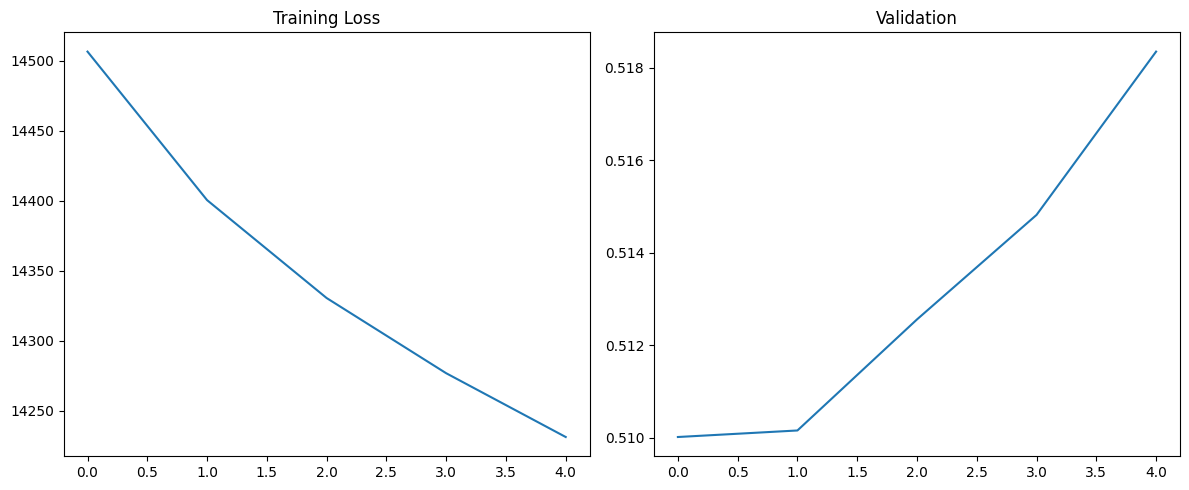

highest valid acc:  0.5183460344340954  in epoch:  4
lowest training err:  14231.393977880478  in epoch  4


In [12]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 5
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

## Non-regularized



### K = 10
best lr 0.001, num_epoches: 100

valid. acc. 0.6

generally bad at predicting

Epoch: 0 	Training Cost: 14504.483255	 Valid Acc: 0.503669206886819
Epoch: 1 	Training Cost: 14393.272331	 Valid Acc: 0.5079029071408411
Epoch: 2 	Training Cost: 14319.326038	 Valid Acc: 0.5101608806096528
Epoch: 3 	Training Cost: 14261.915677	 Valid Acc: 0.5118543607112617
Epoch: 4 	Training Cost: 14212.710832	 Valid Acc: 0.5141123341800734
Epoch: 5 	Training Cost: 14167.955988	 Valid Acc: 0.5167936776742873
Epoch: 6 	Training Cost: 14125.710890	 Valid Acc: 0.519051651143099
Epoch: 7 	Training Cost: 14084.867430	 Valid Acc: 0.5231442280553203
Epoch: 8 	Training Cost: 14044.752950	 Valid Acc: 0.5266723116003387
Epoch: 9 	Training Cost: 14004.948665	 Valid Acc: 0.5316116285633644
Epoch: 10 	Training Cost: 13965.192067	 Valid Acc: 0.5337284786903754
Epoch: 11 	Training Cost: 13925.319182	 Valid Acc: 0.5369743155517923
Epoch: 12 	Training Cost: 13885.228643	 Valid Acc: 0.5352808354501835
Epoch: 13 	Training Cost: 13844.861289	 Valid Acc: 0.5399379057296076
Epoch: 14 	Training Cost: 13804.

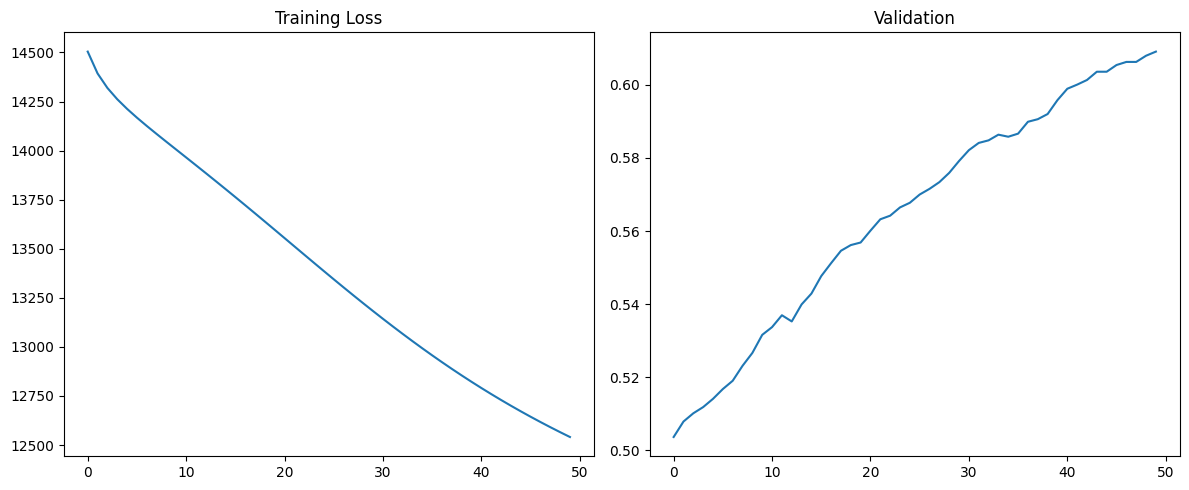

highest valid acc:  0.6090883432119673  in epoch:  49
lowest training err:  12540.726779699326  in epoch  49


In [14]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

The learning rate seems too low

Epoch: 0 	Training Cost: 14356.518601	 Valid Acc: 0.528648038385549
Epoch: 1 	Training Cost: 14098.691118	 Valid Acc: 0.5410668924640135
Epoch: 2 	Training Cost: 13902.485296	 Valid Acc: 0.554050239909681
Epoch: 3 	Training Cost: 13703.264432	 Valid Acc: 0.5659046006209427
Epoch: 4 	Training Cost: 13499.300935	 Valid Acc: 0.5760654812305955
Epoch: 5 	Training Cost: 13298.775431	 Valid Acc: 0.5860852384984476
Epoch: 6 	Training Cost: 13108.479907	 Valid Acc: 0.5951171323736946
Epoch: 7 	Training Cost: 12934.128509	 Valid Acc: 0.6004798193621225
Epoch: 8 	Training Cost: 12778.225441	 Valid Acc: 0.6051368896415467
Epoch: 9 	Training Cost: 12640.792759	 Valid Acc: 0.6095117132373694
Epoch: 10 	Training Cost: 12520.667275	 Valid Acc: 0.6158622636184025
Epoch: 11 	Training Cost: 12415.712373	 Valid Acc: 0.6193903471634208
Epoch: 12 	Training Cost: 12323.559871	 Valid Acc: 0.6202370872142252
Epoch: 13 	Training Cost: 12242.002727	 Valid Acc: 0.6222128139994355
Epoch: 14 	Training Cost: 12169.

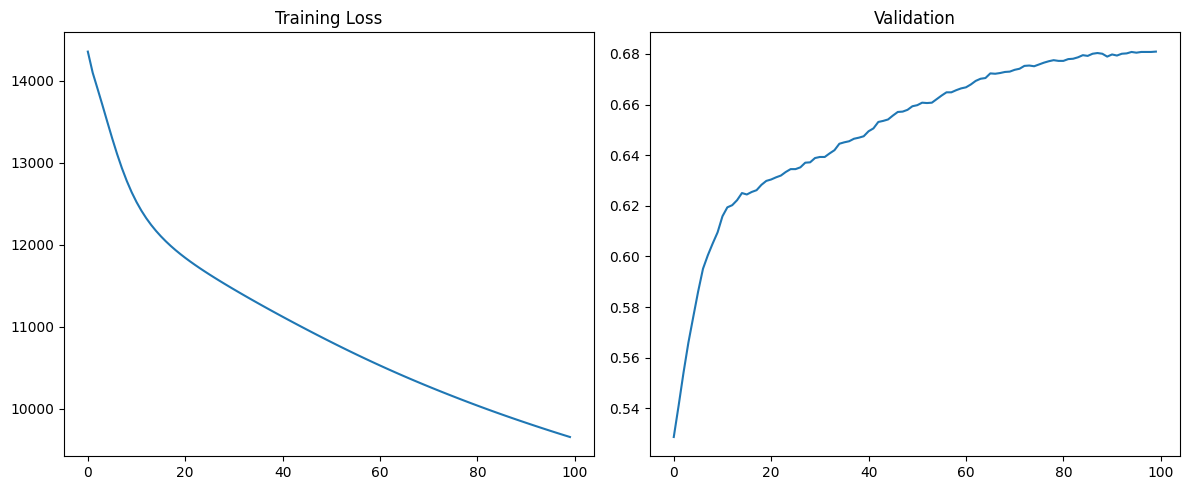

highest valid acc:  0.6809201241885408  in epoch:  99
lowest training err:  9653.871480464935  in epoch  99


In [15]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

try a bit larger lr

Epoch: 0 	Training Cost: 14336.925882	 Valid Acc: 0.5282246683601468
Epoch: 1 	Training Cost: 14032.736346	 Valid Acc: 0.5431837425910245
Epoch: 2 	Training Cost: 13806.327264	 Valid Acc: 0.5553203499858876
Epoch: 3 	Training Cost: 13568.284157	 Valid Acc: 0.5704205475585662
Epoch: 4 	Training Cost: 13318.412396	 Valid Acc: 0.5814281682190234
Epoch: 5 	Training Cost: 13072.124060	 Valid Acc: 0.5955405023990968
Epoch: 6 	Training Cost: 12844.530415	 Valid Acc: 0.6021732994637313
Epoch: 7 	Training Cost: 12645.176413	 Valid Acc: 0.6073948631103585
Epoch: 8 	Training Cost: 12476.946513	 Valid Acc: 0.6147332768839966
Epoch: 9 	Training Cost: 12336.738570	 Valid Acc: 0.6196725938470223
Epoch: 10 	Training Cost: 12218.935627	 Valid Acc: 0.6222128139994355
Epoch: 11 	Training Cost: 12117.995360	 Valid Acc: 0.6257408975444538
Epoch: 12 	Training Cost: 12029.277729	 Valid Acc: 0.6257408975444538
Epoch: 13 	Training Cost: 11949.284343	 Valid Acc: 0.6279988710132656
Epoch: 14 	Training Cost: 1187

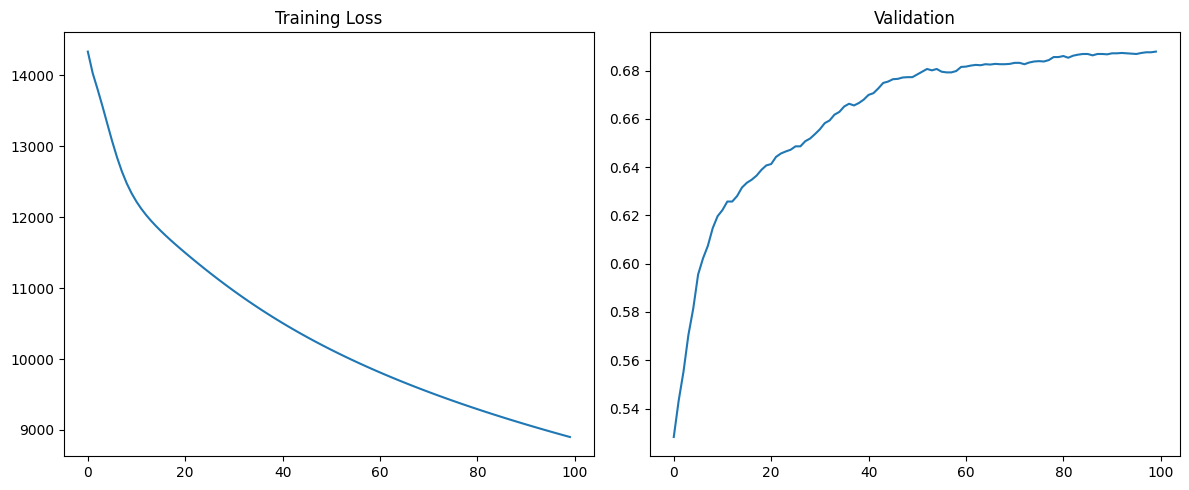

highest valid acc:  0.6878351679367768  in epoch:  99
lowest training err:  8900.486783385277  in epoch  99


In [16]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.0075
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

In [ ]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

larger lr seems to lead to lower valid acc, try smaller lr with more epoches

Epoch: 0 	Training Cost: 14499.601299	 Valid Acc: 0.5086085238498448
Epoch: 1 	Training Cost: 14392.142603	 Valid Acc: 0.5110076206604572
Epoch: 2 	Training Cost: 14321.571427	 Valid Acc: 0.5149590742308778
Epoch: 3 	Training Cost: 14267.439399	 Valid Acc: 0.5176404177250917
Epoch: 4 	Training Cost: 14221.563414	 Valid Acc: 0.5186282811176969
Epoch: 5 	Training Cost: 14180.270149	 Valid Acc: 0.5208862545865086
Epoch: 6 	Training Cost: 14141.657845	 Valid Acc: 0.5228619813717189
Epoch: 7 	Training Cost: 14104.630478	 Valid Acc: 0.5258255715495342
Epoch: 8 	Training Cost: 14068.507019	 Valid Acc: 0.5279424216765453
Epoch: 9 	Training Cost: 14032.839861	 Valid Acc: 0.5311882585379621
Epoch: 10 	Training Cost: 13997.321427	 Valid Acc: 0.5355630821337849
Epoch: 11 	Training Cost: 13961.732744	 Valid Acc: 0.5400790290714084
Epoch: 12 	Training Cost: 13925.915061	 Valid Acc: 0.5431837425910245
Epoch: 13 	Training Cost: 13889.755079	 Valid Acc: 0.5460062094270393
Epoch: 14 	Training Cost: 1385

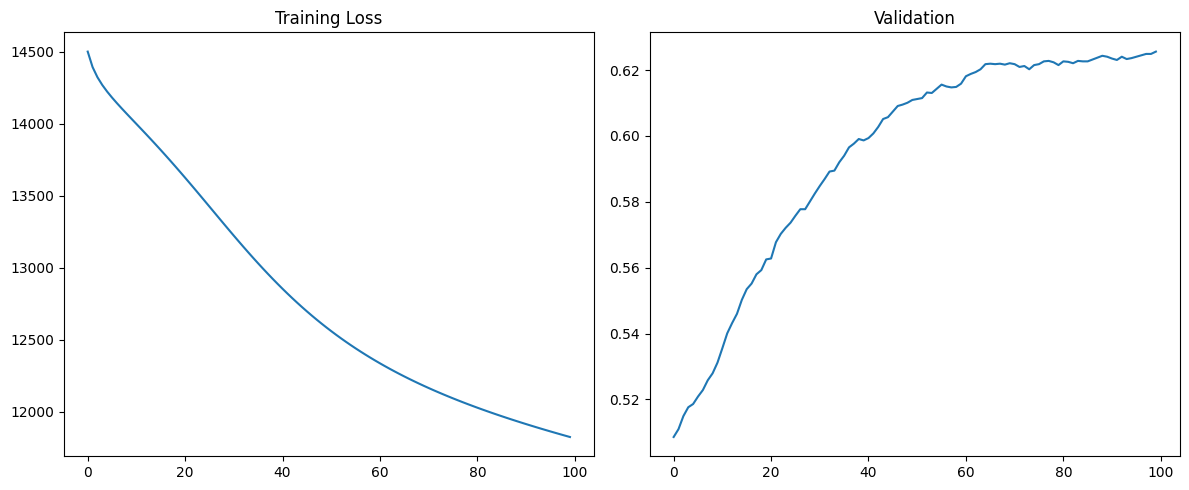

highest valid acc:  0.6255997742026531  in epoch:  99
lowest training err:  11824.528222560883  in epoch  99


In [17]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

### K = 50

best: 68.5
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)


lr = 0.01
num_epoch = 250
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14337.902604	 Valid Acc: 0.5194750211685013
Epoch: 1 	Training Cost: 14115.768084	 Valid Acc: 0.530200395145357
Epoch: 2 	Training Cost: 13921.826097	 Valid Acc: 0.5407846457804121
Epoch: 3 	Training Cost: 13745.322168	 Valid Acc: 0.5601185436071127
Epoch: 4 	Training Cost: 13580.536355	 Valid Acc: 0.5675980807225515
Epoch: 5 	Training Cost: 13425.123491	 Valid Acc: 0.5767710979395992
Epoch: 6 	Training Cost: 13278.815147	 Valid Acc: 0.5876375952582558
Epoch: 7 	Training Cost: 13142.367161	 Valid Acc: 0.5945526390064917
Epoch: 8 	Training Cost: 13016.757579	 Valid Acc: 0.6013265594129269
Epoch: 9 	Training Cost: 12902.685517	 Valid Acc: 0.6058425063505504
Epoch: 10 	Training Cost: 12800.360533	 Valid Acc: 0.6102173299463731
Epoch: 11 	Training Cost: 12709.499363	 Valid Acc: 0.6130397967823878
Epoch: 12 	Training Cost: 12629.432730	 Valid Acc: 0.615015523567598
Epoch: 13 	Training Cost: 12559.243849	 Valid Acc: 0.6154388935930003
Epoch: 14 	Training Cost: 12497.

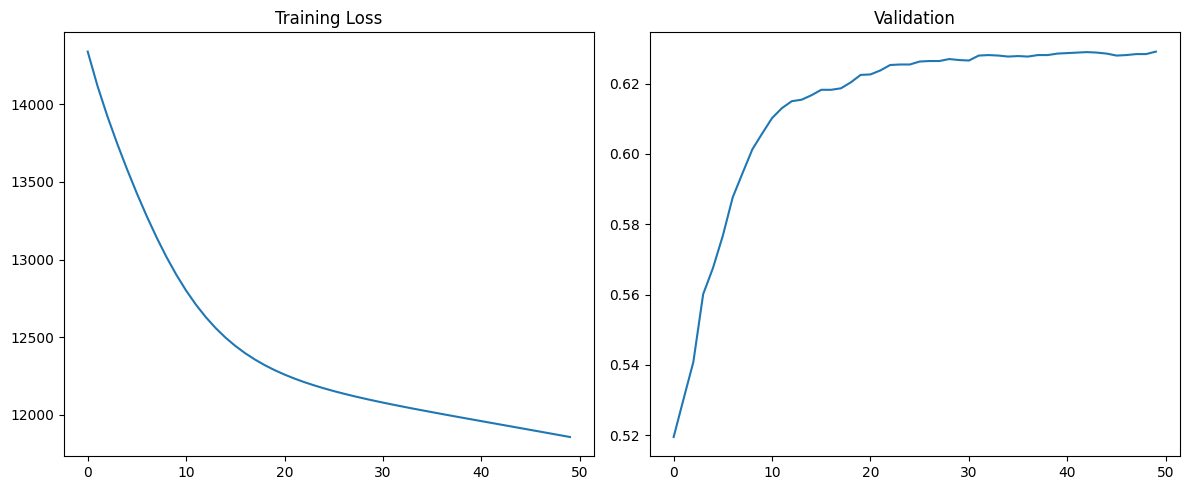

highest valid acc:  0.6291278577476714  in epoch:  49
lowest training err:  11858.39245069027  in epoch  49


In [18]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14052.407356	 Valid Acc: 0.5777589613322044
Epoch: 1 	Training Cost: 13294.083048	 Valid Acc: 0.6058425063505504
Epoch: 2 	Training Cost: 12784.896171	 Valid Acc: 0.6213660739486311
Epoch: 3 	Training Cost: 12494.350699	 Valid Acc: 0.6254586508608524
Epoch: 4 	Training Cost: 12337.425985	 Valid Acc: 0.6234829240756421
Epoch: 5 	Training Cost: 12240.539659	 Valid Acc: 0.6248941574936494
Epoch: 6 	Training Cost: 12167.610059	 Valid Acc: 0.628281117696867
Epoch: 7 	Training Cost: 12103.556142	 Valid Acc: 0.6285633643804686
Epoch: 8 	Training Cost: 12042.403653	 Valid Acc: 0.6291278577476714
Epoch: 9 	Training Cost: 11981.826875	 Valid Acc: 0.6292689810894722
Epoch: 10 	Training Cost: 11920.870058	 Valid Acc: 0.6296923511148744
Epoch: 11 	Training Cost: 11859.062695	 Valid Acc: 0.6298334744566751
Epoch: 12 	Training Cost: 11796.106427	 Valid Acc: 0.630962461191081
Epoch: 13 	Training Cost: 11731.773977	 Valid Acc: 0.6315269545582839
Epoch: 14 	Training Cost: 11665.

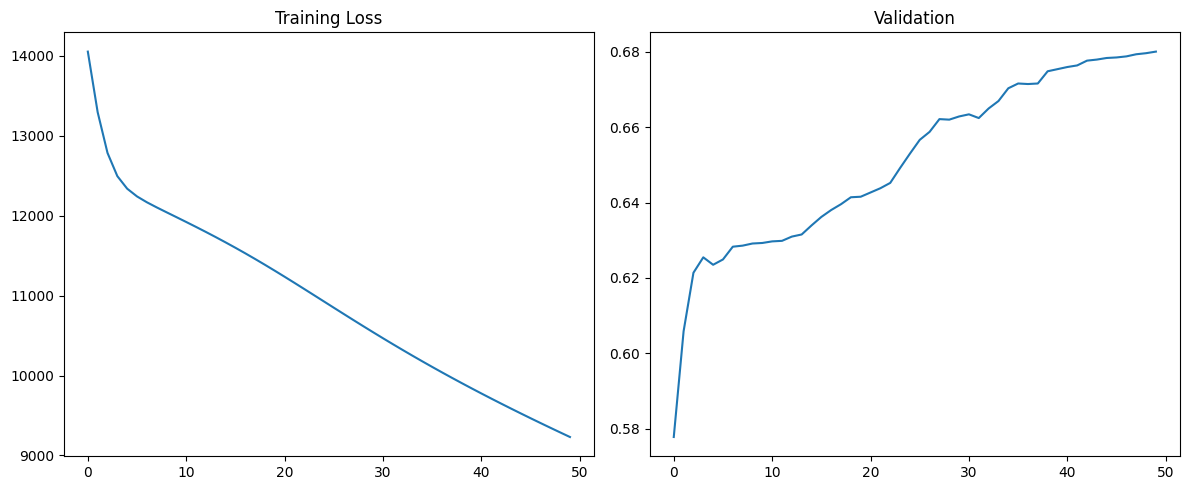

highest valid acc:  0.6800733841377364  in epoch:  49
lowest training err:  9231.005569338799  in epoch  49


In [19]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 50
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14099.511910	 Valid Acc: 0.5731018910527801
Epoch: 1 	Training Cost: 13317.876073	 Valid Acc: 0.6068303697431555
Epoch: 2 	Training Cost: 12798.201198	 Valid Acc: 0.617696867061812
Epoch: 3 	Training Cost: 12502.333347	 Valid Acc: 0.6226361840248377
Epoch: 4 	Training Cost: 12340.872121	 Valid Acc: 0.627293254304262
Epoch: 5 	Training Cost: 12240.091188	 Valid Acc: 0.6281399943550663
Epoch: 6 	Training Cost: 12163.667694	 Valid Acc: 0.628281117696867
Epoch: 7 	Training Cost: 12096.284945	 Valid Acc: 0.6279988710132656
Epoch: 8 	Training Cost: 12031.840360	 Valid Acc: 0.6271521309624611
Epoch: 9 	Training Cost: 11967.928000	 Valid Acc: 0.6281399943550663
Epoch: 10 	Training Cost: 11903.510717	 Valid Acc: 0.6299745977984759
Epoch: 11 	Training Cost: 11838.034245	 Valid Acc: 0.6305390911656789
Epoch: 12 	Training Cost: 11771.149780	 Valid Acc: 0.6312447078746825
Epoch: 13 	Training Cost: 11702.638823	 Valid Acc: 0.6318092012418854
Epoch: 14 	Training Cost: 11632.3

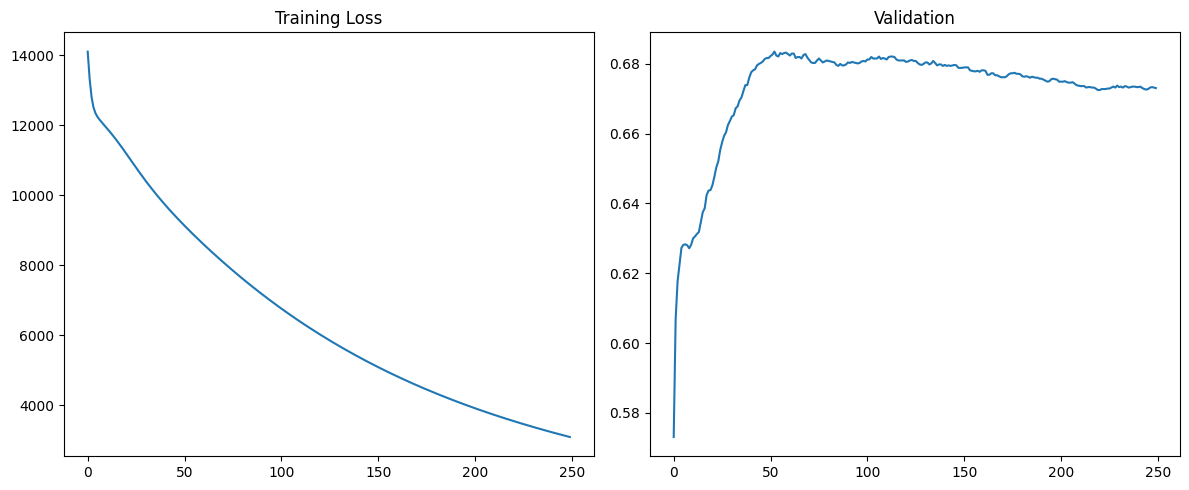

highest valid acc:  0.683460344340954  in epoch:  52
lowest training err:  3090.160155057907  in epoch  249


In [53]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 250
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13798.566002	 Valid Acc: 0.6083827265029635
Epoch: 1 	Training Cost: 12786.221074	 Valid Acc: 0.6220716906576348
Epoch: 2 	Training Cost: 12420.786381	 Valid Acc: 0.6274343776460627
Epoch: 3 	Training Cost: 12253.611988	 Valid Acc: 0.6296923511148744
Epoch: 4 	Training Cost: 12115.971560	 Valid Acc: 0.6298334744566751
Epoch: 5 	Training Cost: 11980.259810	 Valid Acc: 0.6327970646344906
Epoch: 6 	Training Cost: 11841.775008	 Valid Acc: 0.6361840248377082
Epoch: 7 	Training Cost: 11698.442188	 Valid Acc: 0.6387242449901214
Epoch: 8 	Training Cost: 11549.569608	 Valid Acc: 0.6422523285351397
Epoch: 9 	Training Cost: 11395.737568	 Valid Acc: 0.6471916454981654
Epoch: 10 	Training Cost: 11238.485469	 Valid Acc: 0.6494496189669772
Epoch: 11 	Training Cost: 11079.834864	 Valid Acc: 0.6552356759808072
Epoch: 12 	Training Cost: 10921.801666	 Valid Acc: 0.6584815128422241
Epoch: 13 	Training Cost: 10766.060033	 Valid Acc: 0.6620095963872424
Epoch: 14 	Training Cost: 1061

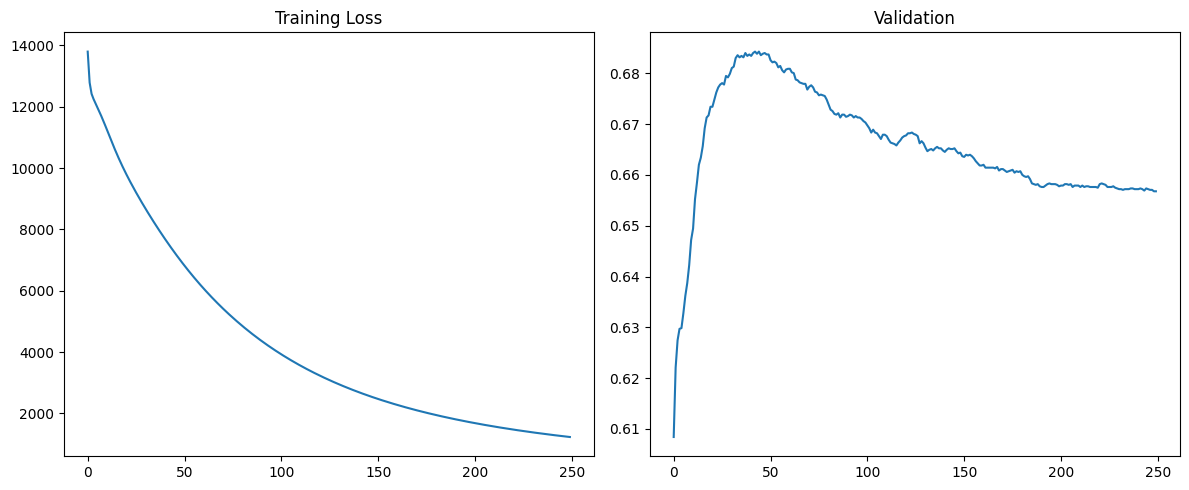

highest valid acc:  0.6843070843917584  in epoch:  42
lowest training err:  1227.3150507360697  in epoch  249


In [55]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14309.989079	 Valid Acc: 0.5256844482077335
Epoch: 1 	Training Cost: 13832.722339	 Valid Acc: 0.5632232571267287
Epoch: 2 	Training Cost: 13453.509347	 Valid Acc: 0.5877787186000565
Epoch: 3 	Training Cost: 13125.135218	 Valid Acc: 0.6018910527801299
Epoch: 4 	Training Cost: 12853.553557	 Valid Acc: 0.611910810047982
Epoch: 5 	Training Cost: 12644.835553	 Valid Acc: 0.6203782105560259
Epoch: 6 	Training Cost: 12492.083457	 Valid Acc: 0.6205193338978267
Epoch: 7 	Training Cost: 12381.807120	 Valid Acc: 0.6236240474174428
Epoch: 8 	Training Cost: 12300.914855	 Valid Acc: 0.6260231442280553
Epoch: 9 	Training Cost: 12239.349534	 Valid Acc: 0.6261642675698561
Epoch: 10 	Training Cost: 12190.144463	 Valid Acc: 0.6277166243296641
Epoch: 11 	Training Cost: 12148.701496	 Valid Acc: 0.627293254304262
Epoch: 12 	Training Cost: 12112.054066	 Valid Acc: 0.62884561106407
Epoch: 13 	Training Cost: 12078.310517	 Valid Acc: 0.6284222410386678
Epoch: 14 	Training Cost: 12046.27

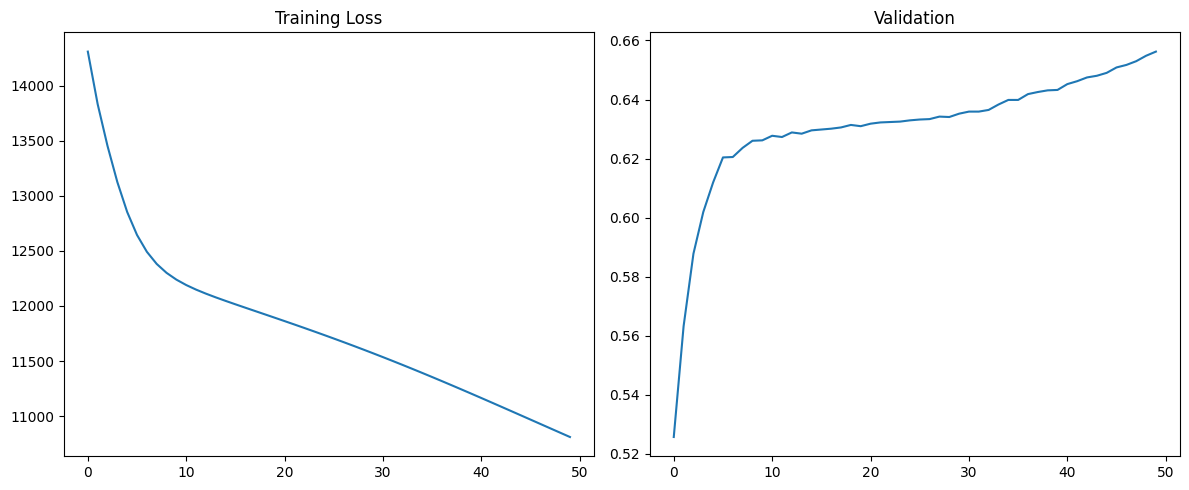

highest valid acc:  0.6562235393734124  in epoch:  49
lowest training err:  10810.172236323357  in epoch  49


In [20]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.0025
num_epoch = 50
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14367.918931	 Valid Acc: 0.5119954840530624
Epoch: 1 	Training Cost: 14246.554071	 Valid Acc: 0.5197572678521027
Epoch: 2 	Training Cost: 14135.783576	 Valid Acc: 0.5289302850691504
Epoch: 3 	Training Cost: 14033.249607	 Valid Acc: 0.5348574654247813
Epoch: 4 	Training Cost: 13937.116401	 Valid Acc: 0.5414902624894158
Epoch: 5 	Training Cost: 13845.991492	 Valid Acc: 0.5533446232006773
Epoch: 6 	Training Cost: 13758.847363	 Valid Acc: 0.563646627152131
Epoch: 7 	Training Cost: 13674.953850	 Valid Acc: 0.5712672876093706
Epoch: 8 	Training Cost: 13593.819828	 Valid Acc: 0.5760654812305955
Epoch: 9 	Training Cost: 13515.143904	 Valid Acc: 0.5817104149026249
Epoch: 10 	Training Cost: 13438.772135	 Valid Acc: 0.584250635055038
Epoch: 11 	Training Cost: 13364.659425	 Valid Acc: 0.5891899520180638
Epoch: 12 	Training Cost: 13292.836939	 Valid Acc: 0.5907423087778718
Epoch: 13 	Training Cost: 13223.382925	 Valid Acc: 0.5932825289302851
Epoch: 14 	Training Cost: 13156.

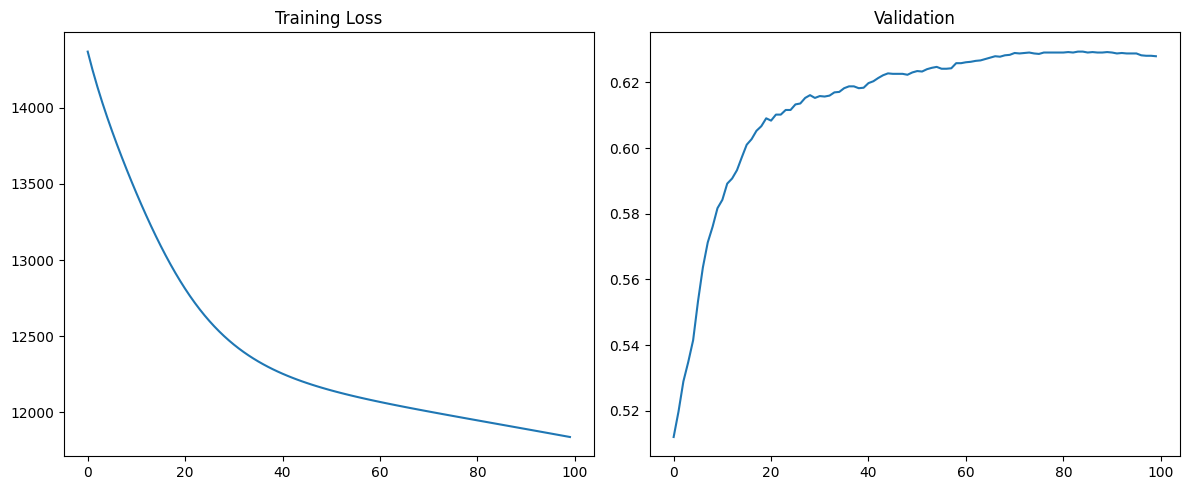

highest valid acc:  0.629410104431273  in epoch:  83
lowest training err:  11838.276332139969  in epoch  99


In [21]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.0005
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

### K=100

All the models tend to overfit, but training accuracy is still 0.6

0.619 lr=0.001 epoch **21**

Epoch: 0 	Training Cost: 14264.782076	 Valid Acc: 0.5453005927180355
Epoch: 1 	Training Cost: 13884.678059	 Valid Acc: 0.5750776178379904
Epoch: 2 	Training Cost: 13576.507174	 Valid Acc: 0.5983629692351115
Epoch: 3 	Training Cost: 13320.519085	 Valid Acc: 0.6061247530341518
Epoch: 4 	Training Cost: 13105.961223	 Valid Acc: 0.6172734970364098
Epoch: 5 	Training Cost: 12926.623996	 Valid Acc: 0.6220716906576348
Epoch: 6 	Training Cost: 12778.105764	 Valid Acc: 0.6237651707592435
Epoch: 7 	Training Cost: 12656.427048	 Valid Acc: 0.6260231442280553
Epoch: 8 	Training Cost: 12557.608836	 Valid Acc: 0.6261642675698561
Epoch: 9 	Training Cost: 12477.754238	 Valid Acc: 0.6291278577476714
Epoch: 10 	Training Cost: 12413.262553	 Valid Acc: 0.6305390911656789
Epoch: 11 	Training Cost: 12360.988940	 Valid Acc: 0.6313858312164832
Epoch: 12 	Training Cost: 12318.305017	 Valid Acc: 0.6323736946090883
Epoch: 13 	Training Cost: 12283.082949	 Valid Acc: 0.630962461191081
Epoch: 14 	Training Cost: 12253

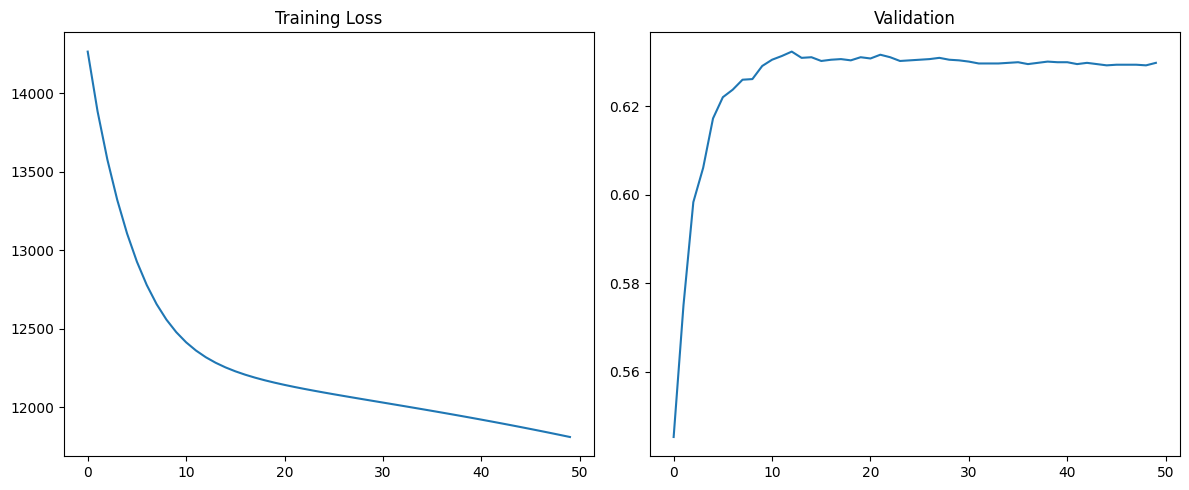

highest valid acc:  0.6323736946090883  in epoch:  12
lowest training err:  11810.224121332169  in epoch  49


In [22]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14421.916596	 Valid Acc: 0.5080440304826418
Epoch: 1 	Training Cost: 14200.285810	 Valid Acc: 0.5186282811176969
Epoch: 2 	Training Cost: 14003.412300	 Valid Acc: 0.5413491391476151
Epoch: 3 	Training Cost: 13826.801853	 Valid Acc: 0.5558848433530906
Epoch: 4 	Training Cost: 13667.095721	 Valid Acc: 0.5709850409257691
Epoch: 5 	Training Cost: 13521.817601	 Valid Acc: 0.5846740050804403
Epoch: 6 	Training Cost: 13389.156372	 Valid Acc: 0.5915890488286762
Epoch: 7 	Training Cost: 13267.785435	 Valid Acc: 0.5962461191081004
Epoch: 8 	Training Cost: 13156.715167	 Valid Acc: 0.6003386960203217
Epoch: 9 	Training Cost: 13055.175710	 Valid Acc: 0.6038667795653401
Epoch: 10 	Training Cost: 12962.529281	 Valid Acc: 0.6048546429579452
Epoch: 11 	Training Cost: 12878.207305	 Valid Acc: 0.6065481230595541
Epoch: 12 	Training Cost: 12801.670020	 Valid Acc: 0.6090883432119673
Epoch: 13 	Training Cost: 12732.385019	 Valid Acc: 0.6120519333897827
Epoch: 14 	Training Cost: 1266

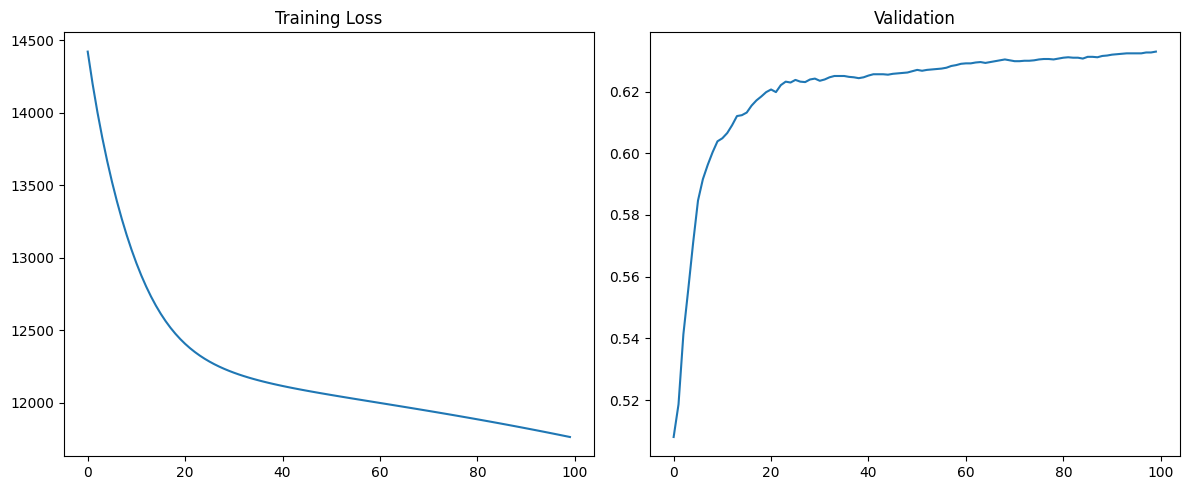

highest valid acc:  0.6329381879762913  in epoch:  99
lowest training err:  11763.759511709213  in epoch  99


In [23]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.0005
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13546.882814	 Valid Acc: 0.6123341800733841
Epoch: 1 	Training Cost: 12622.653976	 Valid Acc: 0.6212249506068304
Epoch: 2 	Training Cost: 12419.659820	 Valid Acc: 0.6279988710132656
Epoch: 3 	Training Cost: 12271.728692	 Valid Acc: 0.6291278577476714
Epoch: 4 	Training Cost: 12116.019737	 Valid Acc: 0.632514817950889
Epoch: 5 	Training Cost: 11947.604509	 Valid Acc: 0.6374541349139148
Epoch: 6 	Training Cost: 11766.342265	 Valid Acc: 0.6412644651425345
Epoch: 7 	Training Cost: 11574.118432	 Valid Acc: 0.6454981653965566
Epoch: 8 	Training Cost: 11374.613843	 Valid Acc: 0.6495907423087779
Epoch: 9 	Training Cost: 11172.064488	 Valid Acc: 0.6550945526390065
Epoch: 10 	Training Cost: 10970.125860	 Valid Acc: 0.6583403895004234
Epoch: 11 	Training Cost: 10771.446413	 Valid Acc: 0.6622918430708439
Epoch: 12 	Training Cost: 10577.667434	 Valid Acc: 0.6658199266158623
Epoch: 13 	Training Cost: 10389.547372	 Valid Acc: 0.6687835167936776
Epoch: 14 	Training Cost: 10207

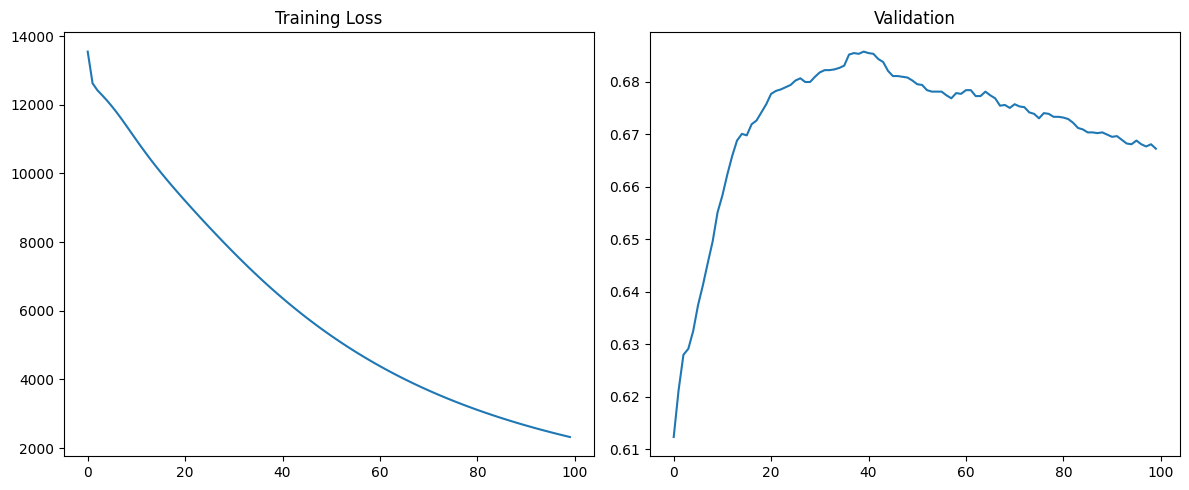

highest valid acc:  0.6857183178097658  in epoch:  39
lowest training err:  2324.123402416706  in epoch  99


In [56]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

### K = 200
0.624 epoch 19 lr=0.0005 num_epoch=100

Epoch: 0 	Training Cost: 13368.621671	 Valid Acc: 0.6237651707592435
Epoch: 1 	Training Cost: 12746.925545	 Valid Acc: 0.6260231442280553
Epoch: 2 	Training Cost: 12592.954262	 Valid Acc: 0.6258820208862546
Epoch: 3 	Training Cost: 12429.939567	 Valid Acc: 0.6289867344058707
Epoch: 4 	Training Cost: 12245.842331	 Valid Acc: 0.6327970646344906
Epoch: 5 	Training Cost: 12041.233255	 Valid Acc: 0.6357606548123059
Epoch: 6 	Training Cost: 11820.010951	 Valid Acc: 0.6406999717753317
Epoch: 7 	Training Cost: 11588.077376	 Valid Acc: 0.6480383855489698
Epoch: 8 	Training Cost: 11351.502121	 Valid Acc: 0.6498729889923793
Epoch: 9 	Training Cost: 11114.849626	 Valid Acc: 0.6528365791701948
Epoch: 10 	Training Cost: 10880.860672	 Valid Acc: 0.6594693762348293
Epoch: 11 	Training Cost: 10650.936548	 Valid Acc: 0.6614451030200396
Epoch: 12 	Training Cost: 10425.570585	 Valid Acc: 0.6634208298052497
Epoch: 13 	Training Cost: 10204.616312	 Valid Acc: 0.665961049957663
Epoch: 14 	Training Cost: 9987.

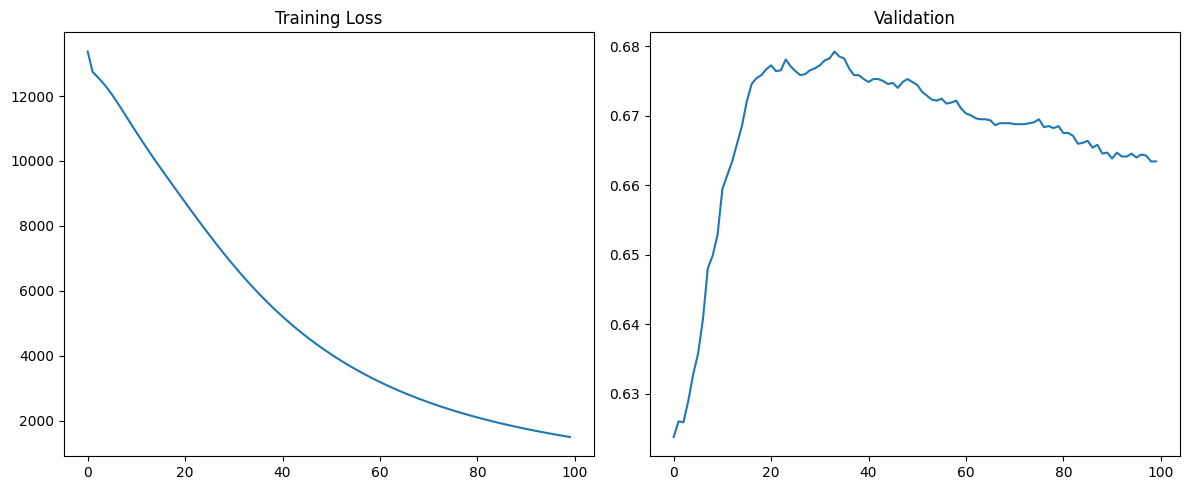

highest valid acc:  0.679226644086932  in epoch:  33
lowest training err:  1499.5393325090408  in epoch  99


In [69]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

### K=500

0.634, lr=0.001 epoch 6

Epoch: 0 	Training Cost: 14067.003443	 Valid Acc: 0.5787468247248095
Epoch: 1 	Training Cost: 13389.115846	 Valid Acc: 0.6100762066045724
Epoch: 2 	Training Cost: 12995.161481	 Valid Acc: 0.6160033869602032
Epoch: 3 	Training Cost: 12760.266292	 Valid Acc: 0.619813717188823
Epoch: 4 	Training Cost: 12614.558539	 Valid Acc: 0.6230595540502399
Epoch: 5 	Training Cost: 12520.411521	 Valid Acc: 0.624611910810048
Epoch: 6 	Training Cost: 12457.112259	 Valid Acc: 0.6253175275190517
Epoch: 7 	Training Cost: 12412.869225	 Valid Acc: 0.6255997742026531
Epoch: 8 	Training Cost: 12380.744454	 Valid Acc: 0.6254586508608524
Epoch: 9 	Training Cost: 12356.530424	 Valid Acc: 0.6254586508608524
Epoch: 10 	Training Cost: 12337.604475	 Valid Acc: 0.6247530341518487
Epoch: 11 	Training Cost: 12322.290465	 Valid Acc: 0.624611910810048
Epoch: 12 	Training Cost: 12309.493159	 Valid Acc: 0.6240474174428451
Epoch: 13 	Training Cost: 12298.480903	 Valid Acc: 0.6237651707592435
Epoch: 14 	Training Cost: 12288.7

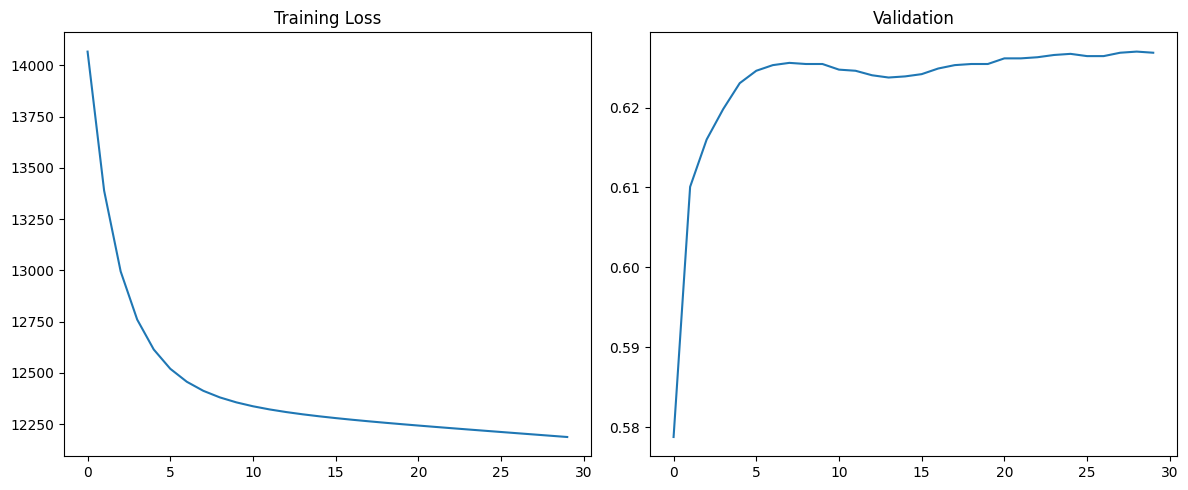

highest valid acc:  0.6270110076206604  in epoch:  28
lowest training err:  12187.742726683617  in epoch  29


In [25]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 30
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13858.777986	 Valid Acc: 0.6011854360711262
Epoch: 1 	Training Cost: 12975.003076	 Valid Acc: 0.6174146203782106
Epoch: 2 	Training Cost: 12654.308561	 Valid Acc: 0.6195314705052216
Epoch: 3 	Training Cost: 12518.370856	 Valid Acc: 0.6216483206322325
Epoch: 4 	Training Cost: 12450.736500	 Valid Acc: 0.6226361840248377
Epoch: 5 	Training Cost: 12411.560393	 Valid Acc: 0.6232006773920407
Epoch: 6 	Training Cost: 12385.460687	 Valid Acc: 0.6229184307084392
Epoch: 7 	Training Cost: 12365.867398	 Valid Acc: 0.6233418007338414
Epoch: 8 	Training Cost: 12349.723332	 Valid Acc: 0.6229184307084392
Epoch: 9 	Training Cost: 12335.495020	 Valid Acc: 0.6234829240756421
Epoch: 10 	Training Cost: 12322.358431	 Valid Acc: 0.6236240474174428
Epoch: 11 	Training Cost: 12309.841816	 Valid Acc: 0.6244707874682472
Epoch: 12 	Training Cost: 12297.658119	 Valid Acc: 0.6241885407846458
Epoch: 13 	Training Cost: 12285.622377	 Valid Acc: 0.6240474174428451
Epoch: 14 	Training Cost: 1227

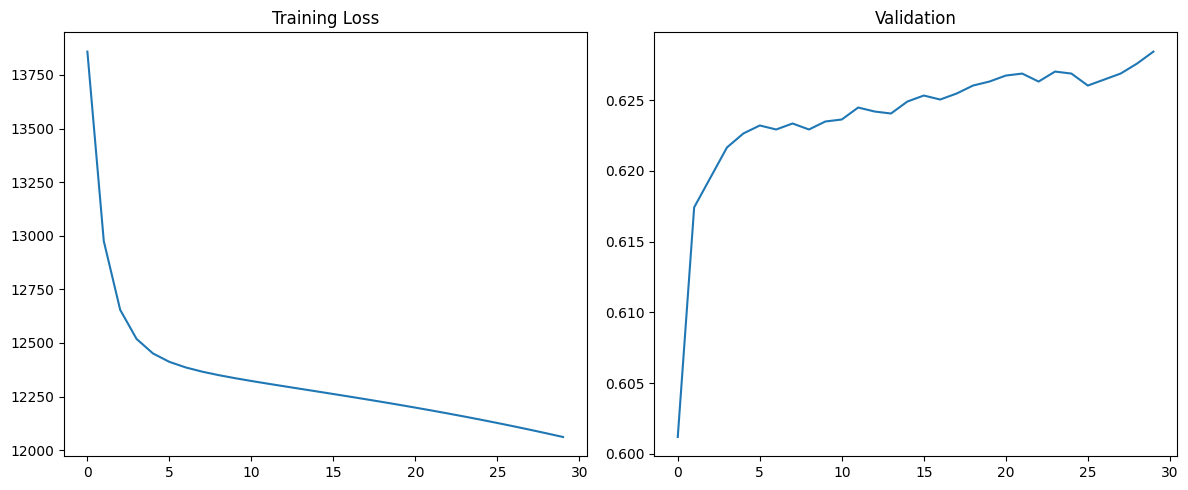

highest valid acc:  0.6284222410386678  in epoch:  29
lowest training err:  12061.069568395615  in epoch  29


In [26]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 30
lamb = 8964

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

## Regularized

#### new train function with regularizer

In [27]:
def train_plot_regu(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            loss = loss + lamb * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

In [28]:
def train_plot_regu_gpu(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = torch.isnan(train_data[user_id].unsqueeze(0))
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            loss = loss + lamb * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

In [29]:
# change the matrices to gpu
train_matrix_gpu = train_matrix.to(device)
zero_train_matrix_gpu = zero_train_matrix.to(device)

### K = 10

Epoch: 0 	Training Cost: 112646.599548	 Valid Acc: 0.5062094270392323
Epoch: 1 	Training Cost: 47447.501106	 Valid Acc: 0.5088907705334462
Epoch: 2 	Training Cost: 25432.962515	 Valid Acc: 0.51538244425628
Epoch: 3 	Training Cost: 17990.279351	 Valid Acc: 0.5142534575218741
Epoch: 4 	Training Cost: 15467.072172	 Valid Acc: 0.5179226644086932
Epoch: 5 	Training Cost: 14604.860398	 Valid Acc: 0.5187694044594976
Epoch: 6 	Training Cost: 14303.539956	 Valid Acc: 0.5189105278012983
Epoch: 7 	Training Cost: 14191.700494	 Valid Acc: 0.5218741179791138
Epoch: 8 	Training Cost: 14143.942173	 Valid Acc: 0.5231442280553203
Epoch: 9 	Training Cost: 14117.919894	 Valid Acc: 0.5238498447643241
Epoch: 10 	Training Cost: 14099.330895	 Valid Acc: 0.5246965848151284
Epoch: 11 	Training Cost: 14083.341727	 Valid Acc: 0.5252610781823314
Epoch: 12 	Training Cost: 14068.317763	 Valid Acc: 0.5276601749929438
Epoch: 13 	Training Cost: 14053.705050	 Valid Acc: 0.5296359017781541
Epoch: 14 	Training Cost: 14039

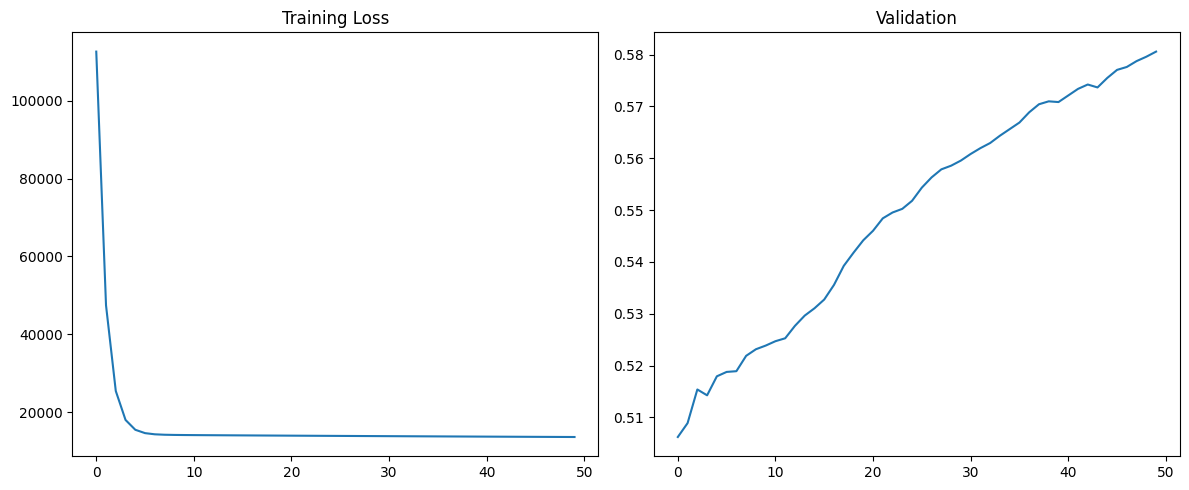

highest valid acc:  0.580581428168219  in epoch:  49
lowest training err:  13609.928461551666  in epoch  49


In [30]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 0.5

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 29028.903383	 Valid Acc: 0.5155235675980807
Epoch: 1 	Training Cost: 14253.671209	 Valid Acc: 0.5373976855771945
Epoch: 2 	Training Cost: 13933.176806	 Valid Acc: 0.5520745131244708
Epoch: 3 	Training Cost: 13812.178664	 Valid Acc: 0.5616709003669207
Epoch: 4 	Training Cost: 13704.268172	 Valid Acc: 0.5718317809765735
Epoch: 5 	Training Cost: 13605.665096	 Valid Acc: 0.5863674851820491
Epoch: 6 	Training Cost: 13515.399595	 Valid Acc: 0.5969517358171041
Epoch: 7 	Training Cost: 13432.677695	 Valid Acc: 0.6027377928309342
Epoch: 8 	Training Cost: 13356.789038	 Valid Acc: 0.6031611628563365
Epoch: 9 	Training Cost: 13287.093089	 Valid Acc: 0.6093705898955687
Epoch: 10 	Training Cost: 13223.011681	 Valid Acc: 0.611910810047982
Epoch: 11 	Training Cost: 13164.024546	 Valid Acc: 0.6110640699971776
Epoch: 12 	Training Cost: 13109.663405	 Valid Acc: 0.6133220434659893
Epoch: 13 	Training Cost: 13059.507251	 Valid Acc: 0.6121930567315834
Epoch: 14 	Training Cost: 13013

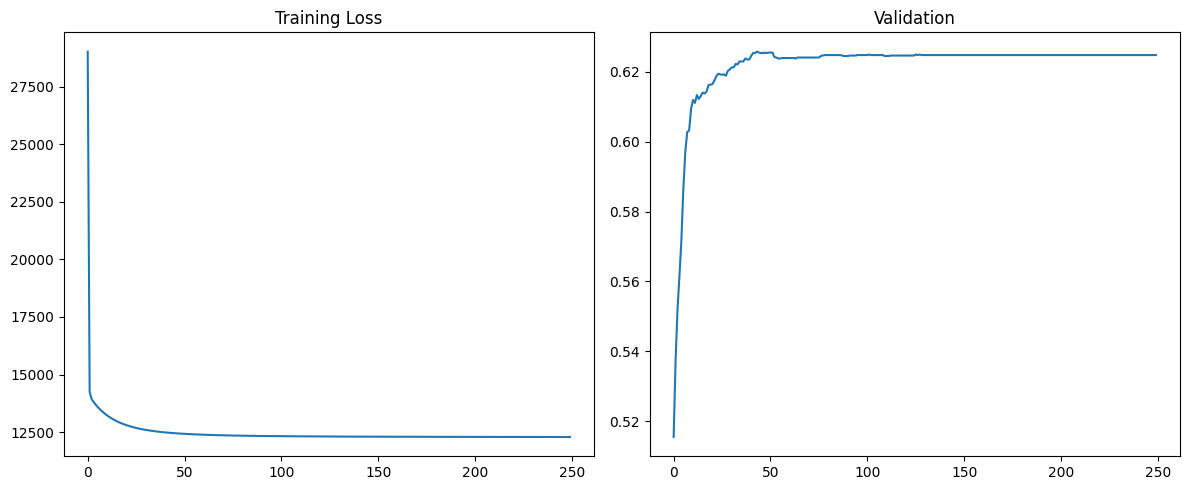

highest valid acc:  0.6257408975444538  in epoch:  43
lowest training err:  12284.94541990757  in epoch  249


In [31]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.2

train_plot_regu(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 20876.903881	 Valid Acc: 0.49887101326559413
Epoch: 1 	Training Cost: 20482.254538	 Valid Acc: 0.503669206886819
Epoch: 2 	Training Cost: 20144.388445	 Valid Acc: 0.5064916737228338
Epoch: 3 	Training Cost: 19837.645694	 Valid Acc: 0.5093141405588484
Epoch: 4 	Training Cost: 19551.545457	 Valid Acc: 0.513265594129269
Epoch: 5 	Training Cost: 19281.175088	 Valid Acc: 0.5155235675980807
Epoch: 6 	Training Cost: 19023.780391	 Valid Acc: 0.5215918712955123
Epoch: 7 	Training Cost: 18777.579713	 Valid Acc: 0.5237087214225233
Epoch: 8 	Training Cost: 18541.289721	 Valid Acc: 0.5275190516511431
Epoch: 9 	Training Cost: 18313.924266	 Valid Acc: 0.5311882585379621
Epoch: 10 	Training Cost: 18094.701229	 Valid Acc: 0.5345752187411797
Epoch: 11 	Training Cost: 17882.998340	 Valid Acc: 0.5373976855771945
Epoch: 12 	Training Cost: 17678.314031	 Valid Acc: 0.5412080158058142
Epoch: 13 	Training Cost: 17480.234714	 Valid Acc: 0.5441716059836297
Epoch: 14 	Training Cost: 17288

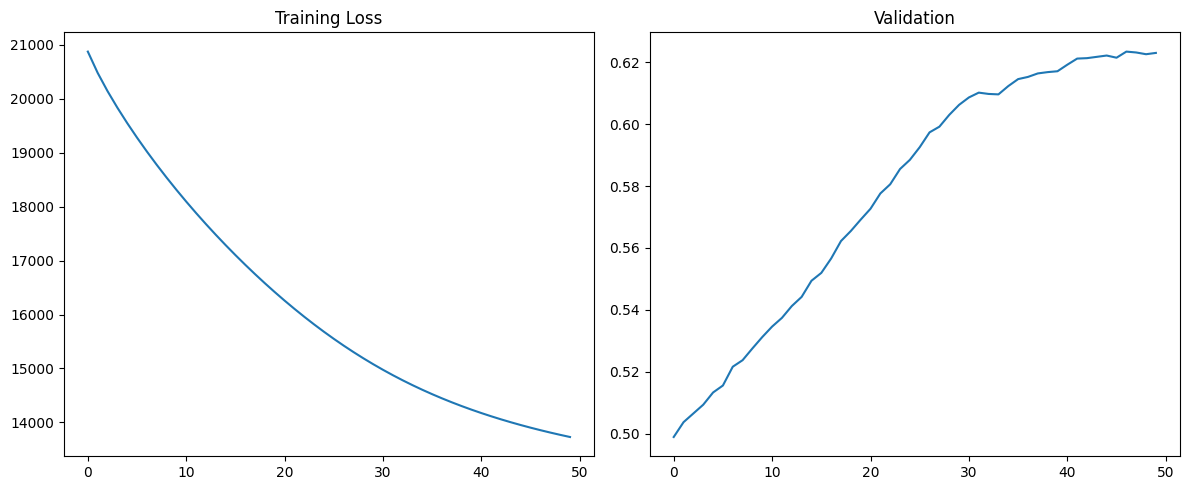

highest valid acc:  0.6234829240756421  in epoch:  46
lowest training err:  13728.774912834167  in epoch  49


In [32]:
k = 10  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 250
lamb = 0.15

train_plot_regu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

### K = 50

Epoch: 0 	Training Cost: 29005.303712	 Valid Acc: 0.6110640699971776
Epoch: 1 	Training Cost: 14033.476403	 Valid Acc: 0.6181202370872142
Epoch: 2 	Training Cost: 13758.605155	 Valid Acc: 0.619813717188823
Epoch: 3 	Training Cost: 13679.809560	 Valid Acc: 0.6182613604290149
Epoch: 4 	Training Cost: 13609.364068	 Valid Acc: 0.6172734970364098
Epoch: 5 	Training Cost: 13544.137198	 Valid Acc: 0.6189669771380186
Epoch: 6 	Training Cost: 13483.581811	 Valid Acc: 0.6219305673158341
Epoch: 7 	Training Cost: 13427.255589	 Valid Acc: 0.6220716906576348
Epoch: 8 	Training Cost: 13374.769656	 Valid Acc: 0.6227773073666384
Epoch: 9 	Training Cost: 13325.778876	 Valid Acc: 0.622495060683037
Epoch: 10 	Training Cost: 13279.977015	 Valid Acc: 0.6223539373412362
Epoch: 11 	Training Cost: 13237.090844	 Valid Acc: 0.6219305673158341
Epoch: 12 	Training Cost: 13196.876651	 Valid Acc: 0.6215071972904318
Epoch: 13 	Training Cost: 13159.115889	 Valid Acc: 0.6226361840248377
Epoch: 14 	Training Cost: 13123.

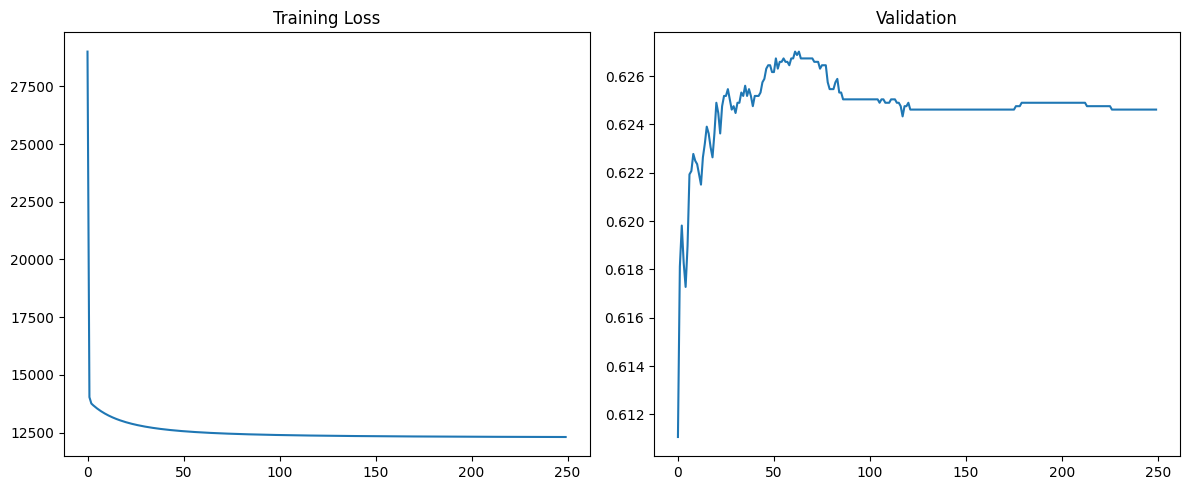

highest valid acc:  0.6270110076206604  in epoch:  61
lowest training err:  12307.886363983154  in epoch  249


In [57]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 18045.430737	 Valid Acc: 0.6241885407846458
Epoch: 1 	Training Cost: 14924.713857	 Valid Acc: 0.6258820208862546
Epoch: 2 	Training Cost: 13827.321916	 Valid Acc: 0.6264465142534575
Epoch: 3 	Training Cost: 13358.791692	 Valid Acc: 0.6264465142534575
Epoch: 4 	Training Cost: 13148.365679	 Valid Acc: 0.6274343776460627
Epoch: 5 	Training Cost: 13046.664393	 Valid Acc: 0.6277166243296641
Epoch: 6 	Training Cost: 12991.190783	 Valid Acc: 0.6299745977984759
Epoch: 7 	Training Cost: 12955.626214	 Valid Acc: 0.6320914479254869
Epoch: 8 	Training Cost: 12928.889962	 Valid Acc: 0.6336438046852949
Epoch: 9 	Training Cost: 12906.349857	 Valid Acc: 0.6340671747106972
Epoch: 10 	Training Cost: 12886.070710	 Valid Acc: 0.6354784081287045
Epoch: 11 	Training Cost: 12867.217249	 Valid Acc: 0.6353372847869038
Epoch: 12 	Training Cost: 12849.390874	 Valid Acc: 0.6353372847869038
Epoch: 13 	Training Cost: 12832.368732	 Valid Acc: 0.6363251481795089
Epoch: 14 	Training Cost: 1281

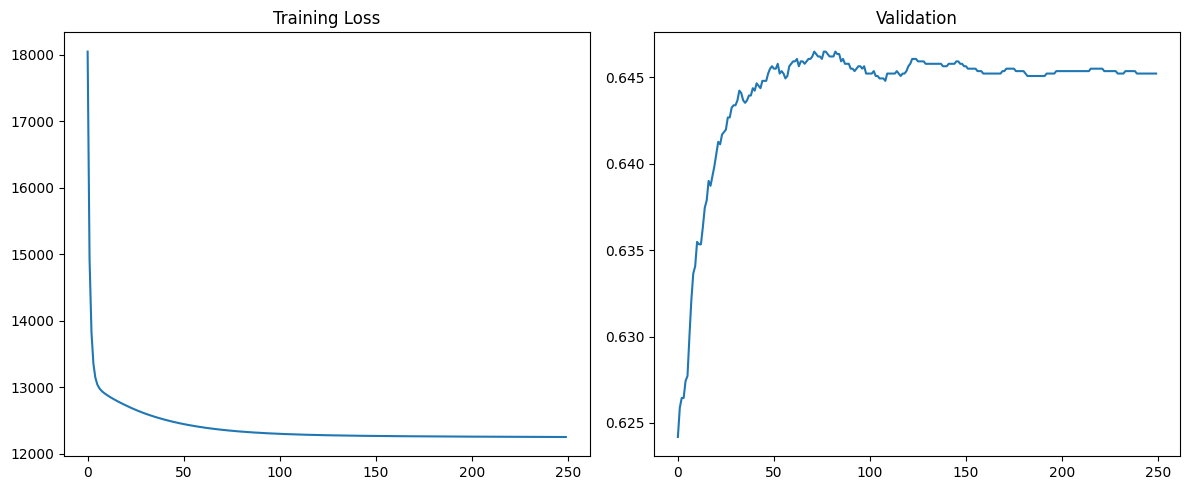

highest valid acc:  0.6464860287891617  in epoch:  71
lowest training err:  12254.222715139389  in epoch  249


In [62]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.02
num_epoch = 250
lamb = 0.02

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16109.358296	 Valid Acc: 0.6241885407846458
Epoch: 1 	Training Cost: 13787.778296	 Valid Acc: 0.6291278577476714
Epoch: 2 	Training Cost: 13308.281127	 Valid Acc: 0.6337849280270956
Epoch: 3 	Training Cost: 13150.808094	 Valid Acc: 0.6364662715213096
Epoch: 4 	Training Cost: 13067.708384	 Valid Acc: 0.6411233418007338
Epoch: 5 	Training Cost: 13006.691412	 Valid Acc: 0.6435224386113463
Epoch: 6 	Training Cost: 12954.955323	 Valid Acc: 0.6456392887383573
Epoch: 7 	Training Cost: 12908.686552	 Valid Acc: 0.6467682754727632
Epoch: 8 	Training Cost: 12866.456970	 Valid Acc: 0.6477561388653683
Epoch: 9 	Training Cost: 12827.560312	 Valid Acc: 0.6469093988145639
Epoch: 10 	Training Cost: 12791.523611	 Valid Acc: 0.6462037821055603
Epoch: 11 	Training Cost: 12758.007819	 Valid Acc: 0.6462037821055603
Epoch: 12 	Training Cost: 12726.768887	 Valid Acc: 0.6459215354219587
Epoch: 13 	Training Cost: 12697.609084	 Valid Acc: 0.6466271521309624
Epoch: 14 	Training Cost: 1267

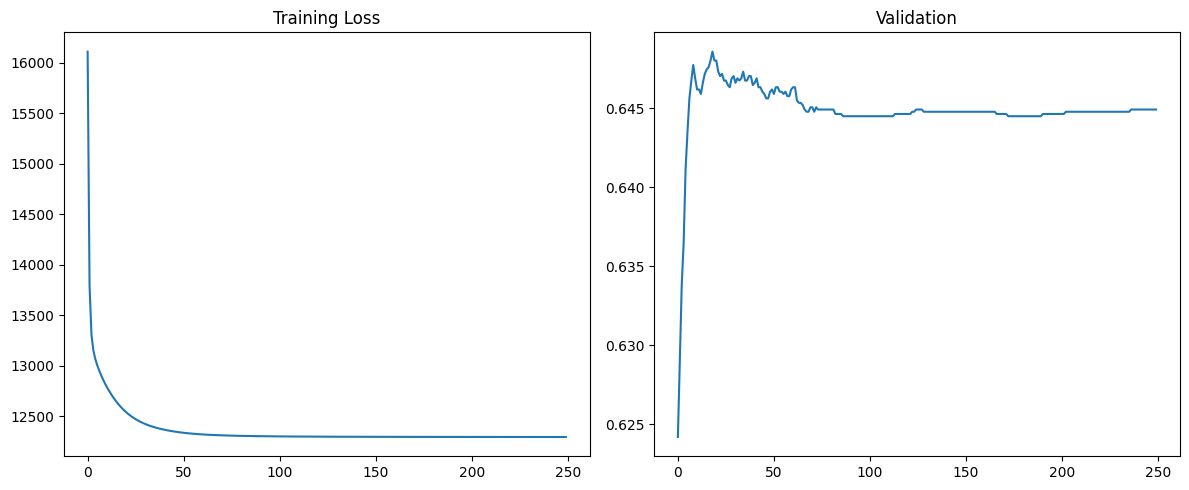

highest valid acc:  0.6486028789161727  in epoch:  18
lowest training err:  12296.439592599869  in epoch  249


In [64]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.05
num_epoch = 250
lamb = 0.015

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15573.487224	 Valid Acc: 0.6241885407846458
Epoch: 1 	Training Cost: 13791.203096	 Valid Acc: 0.6311035845328817
Epoch: 2 	Training Cost: 13215.519159	 Valid Acc: 0.6397121083827265
Epoch: 3 	Training Cost: 12963.464330	 Valid Acc: 0.6481795088907706
Epoch: 4 	Training Cost: 12835.145172	 Valid Acc: 0.6528365791701948
Epoch: 5 	Training Cost: 12759.424843	 Valid Acc: 0.6558001693480101
Epoch: 6 	Training Cost: 12708.358837	 Valid Acc: 0.6556590460062094
Epoch: 7 	Training Cost: 12669.910270	 Valid Acc: 0.6558001693480101
Epoch: 8 	Training Cost: 12638.492147	 Valid Acc: 0.656929156082416
Epoch: 9 	Training Cost: 12611.345925	 Valid Acc: 0.6567880327406153
Epoch: 10 	Training Cost: 12587.026751	 Valid Acc: 0.657493649449619
Epoch: 11 	Training Cost: 12564.725783	 Valid Acc: 0.656929156082416
Epoch: 12 	Training Cost: 12543.960977	 Valid Acc: 0.6570702794242168
Epoch: 13 	Training Cost: 12524.439950	 Valid Acc: 0.6579170194750211
Epoch: 14 	Training Cost: 12506.0

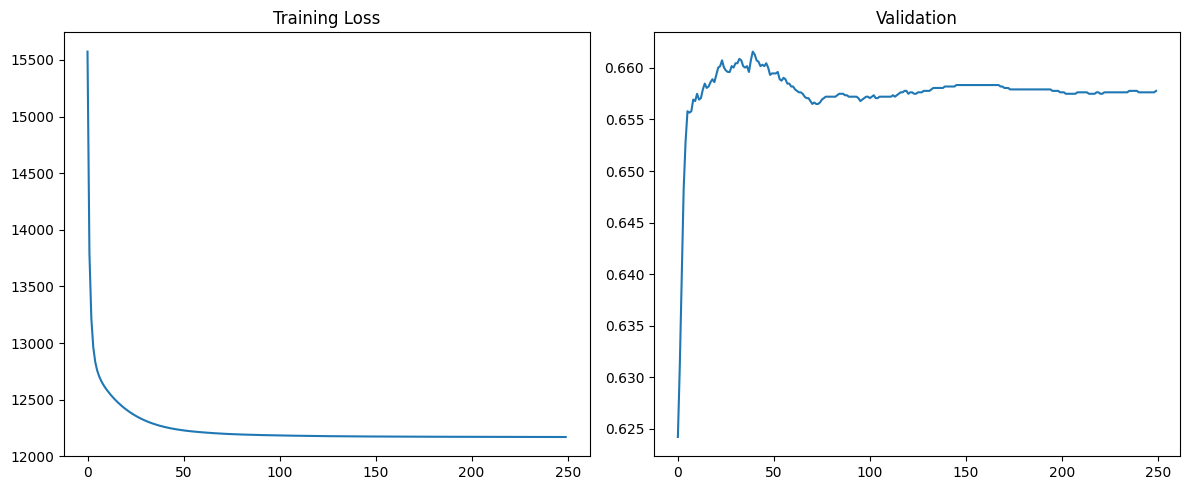

highest valid acc:  0.6615862263618403  in epoch:  39
lowest training err:  12169.811100006104  in epoch  249


In [65]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.05
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

### K = 100

Epoch: 0 	Training Cost: 29395.888079	 Valid Acc: 0.61346316680779
Epoch: 1 	Training Cost: 13975.616319	 Valid Acc: 0.6154388935930003
Epoch: 2 	Training Cost: 13720.772677	 Valid Acc: 0.6172734970364098
Epoch: 3 	Training Cost: 13664.420203	 Valid Acc: 0.617696867061812
Epoch: 4 	Training Cost: 13613.897765	 Valid Acc: 0.6206604572396275
Epoch: 5 	Training Cost: 13566.408419	 Valid Acc: 0.6200959638724245
Epoch: 6 	Training Cost: 13521.661412	 Valid Acc: 0.6206604572396275
Epoch: 7 	Training Cost: 13479.426251	 Valid Acc: 0.6212249506068304
Epoch: 8 	Training Cost: 13439.497595	 Valid Acc: 0.6217894439740334
Epoch: 9 	Training Cost: 13401.691625	 Valid Acc: 0.6219305673158341
Epoch: 10 	Training Cost: 13365.844033	 Valid Acc: 0.6223539373412362
Epoch: 11 	Training Cost: 13331.806881	 Valid Acc: 0.6236240474174428
Epoch: 12 	Training Cost: 13299.446904	 Valid Acc: 0.6239062941010444
Epoch: 13 	Training Cost: 13268.644065	 Valid Acc: 0.6239062941010444
Epoch: 14 	Training Cost: 13239.2

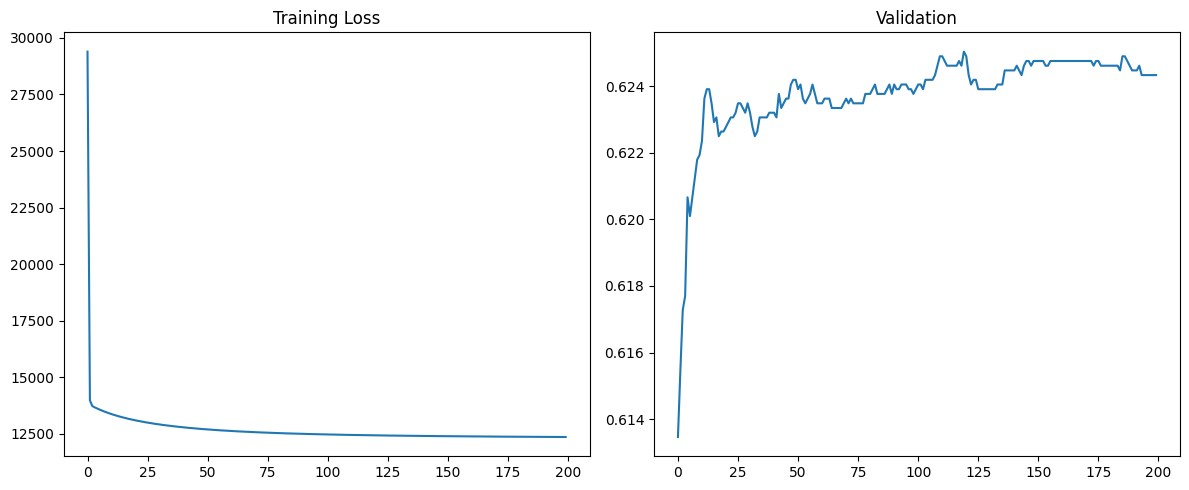

highest valid acc:  0.6250352808354502  in epoch:  119
lowest training err:  12352.98222565651  in epoch  199


In [33]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 200
lamb = 0.2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 18485.531372	 Valid Acc: 0.60767710979396
Epoch: 1 	Training Cost: 16938.778864	 Valid Acc: 0.6236240474174428
Epoch: 2 	Training Cost: 16077.112665	 Valid Acc: 0.629410104431273
Epoch: 3 	Training Cost: 15492.704063	 Valid Acc: 0.628281117696867
Epoch: 4 	Training Cost: 15036.807574	 Valid Acc: 0.6287044877222693
Epoch: 5 	Training Cost: 14660.417905	 Valid Acc: 0.62884561106407
Epoch: 6 	Training Cost: 14343.697088	 Valid Acc: 0.6295512277730737
Epoch: 7 	Training Cost: 14075.252820	 Valid Acc: 0.6296923511148744
Epoch: 8 	Training Cost: 13846.879620	 Valid Acc: 0.6302568444820773
Epoch: 9 	Training Cost: 13652.071579	 Valid Acc: 0.6305390911656789
Epoch: 10 	Training Cost: 13485.482136	 Valid Acc: 0.630962461191081
Epoch: 11 	Training Cost: 13342.656050	 Valid Acc: 0.6308213378492803
Epoch: 12 	Training Cost: 13219.857979	 Valid Acc: 0.6301157211402766
Epoch: 13 	Training Cost: 13113.948435	 Valid Acc: 0.6302568444820773
Epoch: 14 	Training Cost: 13022.28726

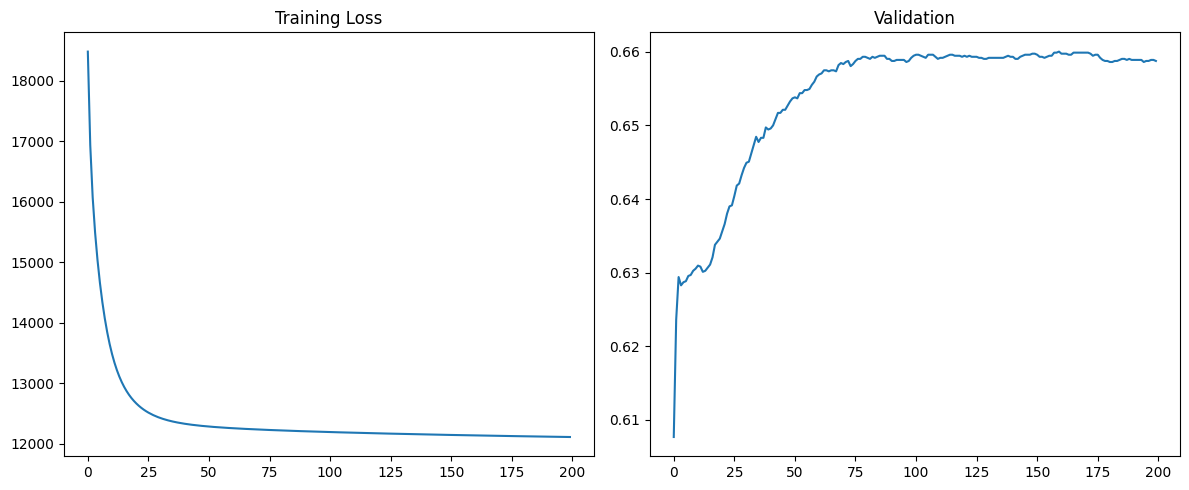

highest valid acc:  0.6600338696020321  in epoch:  159
lowest training err:  12114.539619922638  in epoch  199


In [34]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 200
lamb = 0.015

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 19974.580546	 Valid Acc: 0.5314705052215637
Epoch: 1 	Training Cost: 19369.552172	 Valid Acc: 0.5637877504939317
Epoch: 2 	Training Cost: 18862.081058	 Valid Acc: 0.5812870448772227
Epoch: 3 	Training Cost: 18424.810041	 Valid Acc: 0.5958227490826983
Epoch: 4 	Training Cost: 18042.252335	 Valid Acc: 0.6068303697431555
Epoch: 5 	Training Cost: 17705.001640	 Valid Acc: 0.6127575500987863
Epoch: 6 	Training Cost: 17406.405696	 Valid Acc: 0.6147332768839966
Epoch: 7 	Training Cost: 17140.935137	 Valid Acc: 0.6189669771380186
Epoch: 8 	Training Cost: 16903.606483	 Valid Acc: 0.6202370872142252
Epoch: 9 	Training Cost: 16689.916822	 Valid Acc: 0.6205193338978267
Epoch: 10 	Training Cost: 16495.922360	 Valid Acc: 0.622495060683037
Epoch: 11 	Training Cost: 16318.292029	 Valid Acc: 0.6239062941010444
Epoch: 12 	Training Cost: 16154.296581	 Valid Acc: 0.6230595540502399
Epoch: 13 	Training Cost: 16001.748434	 Valid Acc: 0.6239062941010444
Epoch: 14 	Training Cost: 15858

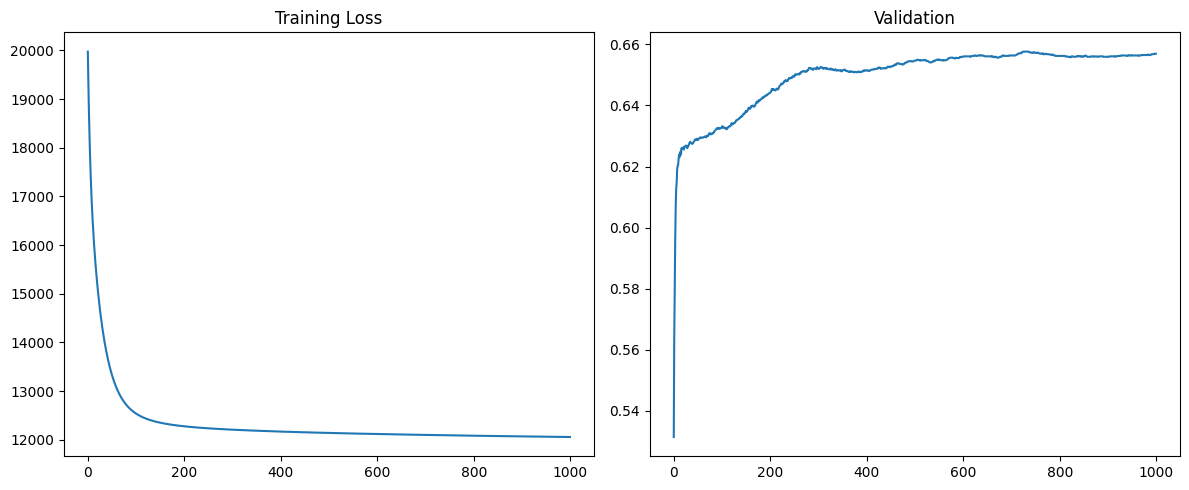

highest valid acc:  0.6576347727914197  in epoch:  724
lowest training err:  12055.857927322388  in epoch  999


In [35]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 1000
lamb = 0.017

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17908.644422	 Valid Acc: 0.6202370872142252
Epoch: 1 	Training Cost: 15973.032916	 Valid Acc: 0.6308213378492803
Epoch: 2 	Training Cost: 15033.469948	 Valid Acc: 0.6295512277730737
Epoch: 3 	Training Cost: 14391.638585	 Valid Acc: 0.6285633643804686
Epoch: 4 	Training Cost: 13928.802664	 Valid Acc: 0.6285633643804686
Epoch: 5 	Training Cost: 13591.037325	 Valid Acc: 0.6287044877222693
Epoch: 6 	Training Cost: 13342.067605	 Valid Acc: 0.6289867344058707
Epoch: 7 	Training Cost: 13156.323872	 Valid Acc: 0.6315269545582839
Epoch: 8 	Training Cost: 13015.726023	 Valid Acc: 0.6336438046852949
Epoch: 9 	Training Cost: 12907.551179	 Valid Acc: 0.6337849280270956
Epoch: 10 	Training Cost: 12822.920388	 Valid Acc: 0.6353372847869038
Epoch: 11 	Training Cost: 12755.680683	 Valid Acc: 0.6357606548123059
Epoch: 12 	Training Cost: 12701.558971	 Valid Acc: 0.6373130115721141
Epoch: 13 	Training Cost: 12657.536670	 Valid Acc: 0.6392887383573242
Epoch: 14 	Training Cost: 1262

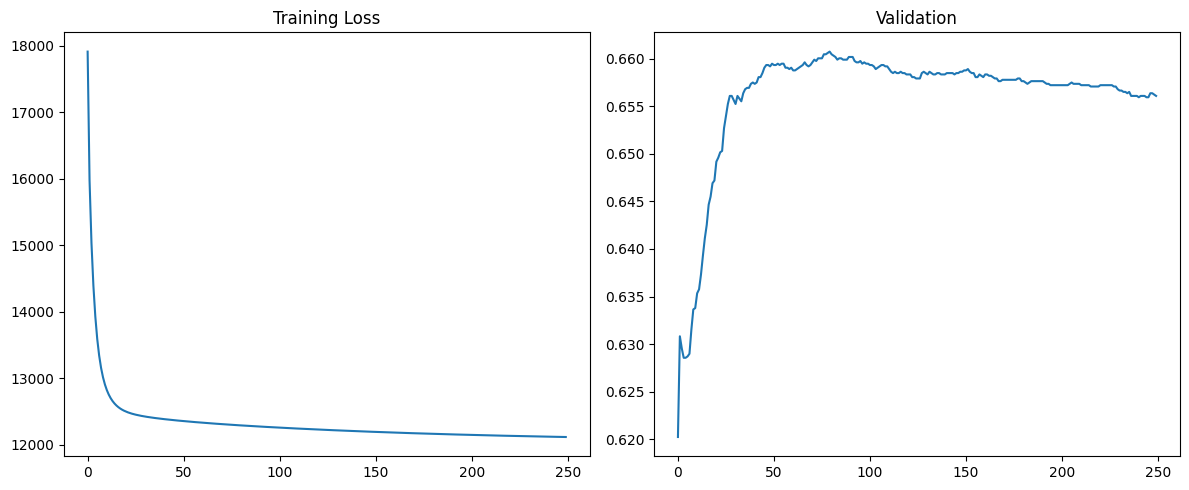

highest valid acc:  0.6607394863110359  in epoch:  79
lowest training err:  12118.136168003082  in epoch  249


In [70]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.015

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17933.019706	 Valid Acc: 0.6232006773920407
Epoch: 1 	Training Cost: 15984.925990	 Valid Acc: 0.6265876375952583
Epoch: 2 	Training Cost: 15042.663623	 Valid Acc: 0.6287044877222693
Epoch: 3 	Training Cost: 14397.894294	 Valid Acc: 0.6278577476714648
Epoch: 4 	Training Cost: 13932.793153	 Valid Acc: 0.6287044877222693
Epoch: 5 	Training Cost: 13593.406431	 Valid Acc: 0.6279988710132656
Epoch: 6 	Training Cost: 13343.329220	 Valid Acc: 0.6299745977984759
Epoch: 7 	Training Cost: 13156.922232	 Valid Acc: 0.6312447078746825
Epoch: 8 	Training Cost: 13016.078960	 Valid Acc: 0.6326559412926898
Epoch: 9 	Training Cost: 12908.043593	 Valid Acc: 0.6350550381033023
Epoch: 10 	Training Cost: 12823.865309	 Valid Acc: 0.6353372847869038
Epoch: 11 	Training Cost: 12757.284676	 Valid Acc: 0.6374541349139148
Epoch: 12 	Training Cost: 12703.914033	 Valid Acc: 0.6380186282811177
Epoch: 13 	Training Cost: 12660.636660	 Valid Acc: 0.6406999717753317
Epoch: 14 	Training Cost: 1262

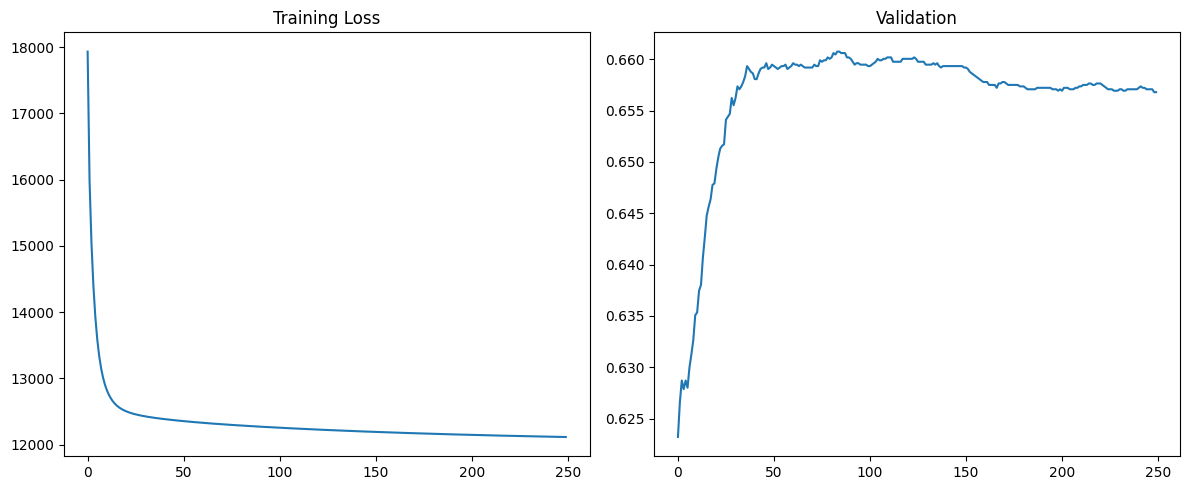

highest valid acc:  0.6607394863110359  in epoch:  83
lowest training err:  12116.30633354187  in epoch  249


In [61]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.015

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

### k = 200

Epoch: 0 	Training Cost: 19787.652930	 Valid Acc: 0.6007620660457239
Epoch: 1 	Training Cost: 18541.107048	 Valid Acc: 0.6174146203782106
Epoch: 2 	Training Cost: 17811.209296	 Valid Acc: 0.624611910810048
Epoch: 3 	Training Cost: 17302.071392	 Valid Acc: 0.6250352808354502
Epoch: 4 	Training Cost: 16899.370049	 Valid Acc: 0.6268698842788597
Epoch: 5 	Training Cost: 16555.636688	 Valid Acc: 0.6270110076206604
Epoch: 6 	Training Cost: 16250.076115	 Valid Acc: 0.626728760937059
Epoch: 7 	Training Cost: 15972.841126	 Valid Acc: 0.6268698842788597
Epoch: 8 	Training Cost: 15718.712420	 Valid Acc: 0.6275755009878634
Epoch: 9 	Training Cost: 15484.520195	 Valid Acc: 0.6271521309624611
Epoch: 10 	Training Cost: 15268.068481	 Valid Acc: 0.6270110076206604
Epoch: 11 	Training Cost: 15067.666089	 Valid Acc: 0.6264465142534575
Epoch: 12 	Training Cost: 14881.915216	 Valid Acc: 0.6270110076206604
Epoch: 13 	Training Cost: 14709.607018	 Valid Acc: 0.6274343776460627
Epoch: 14 	Training Cost: 14549.

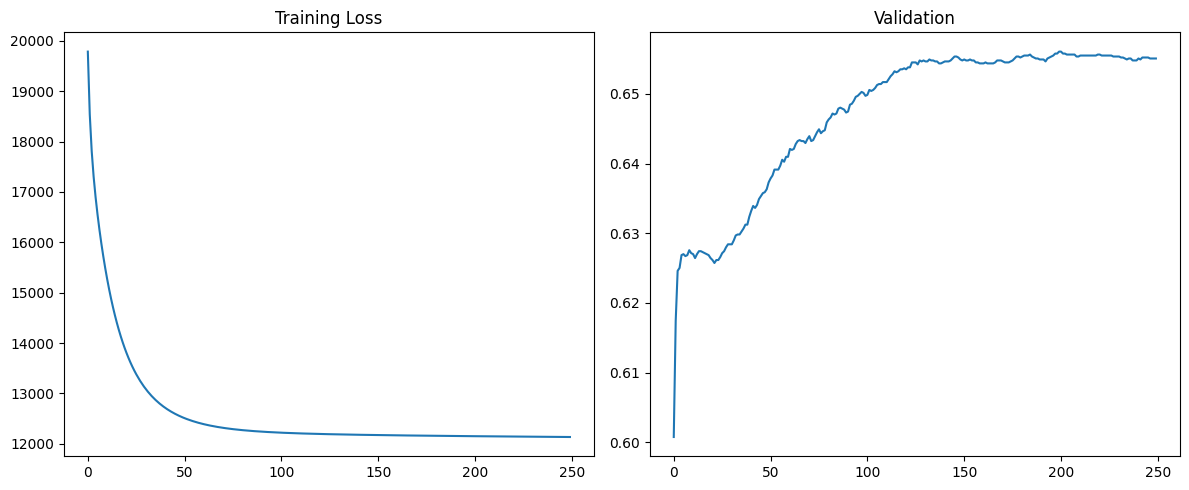

highest valid acc:  0.6560824160316117  in epoch:  199
lowest training err:  12134.510373353958  in epoch  249


In [37]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.002
num_epoch = 250
lamb = 0.017

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 20749.164822	 Valid Acc: 0.5927180355630821
Epoch: 1 	Training Cost: 19373.265181	 Valid Acc: 0.6161445103020039
Epoch: 2 	Training Cost: 18523.736608	 Valid Acc: 0.619813717188823
Epoch: 3 	Training Cost: 17904.545015	 Valid Acc: 0.6254586508608524
Epoch: 4 	Training Cost: 17402.343772	 Valid Acc: 0.6254586508608524
Epoch: 5 	Training Cost: 16970.009926	 Valid Acc: 0.6265876375952583
Epoch: 6 	Training Cost: 16586.339870	 Valid Acc: 0.625176404177251
Epoch: 7 	Training Cost: 16240.704138	 Valid Acc: 0.6255997742026531
Epoch: 8 	Training Cost: 15926.982369	 Valid Acc: 0.6254586508608524
Epoch: 9 	Training Cost: 15641.109334	 Valid Acc: 0.6255997742026531
Epoch: 10 	Training Cost: 15380.046126	 Valid Acc: 0.6263053909116568
Epoch: 11 	Training Cost: 15141.329298	 Valid Acc: 0.6271521309624611
Epoch: 12 	Training Cost: 14922.860165	 Valid Acc: 0.6278577476714648
Epoch: 13 	Training Cost: 14722.799232	 Valid Acc: 0.6277166243296641
Epoch: 14 	Training Cost: 14539.

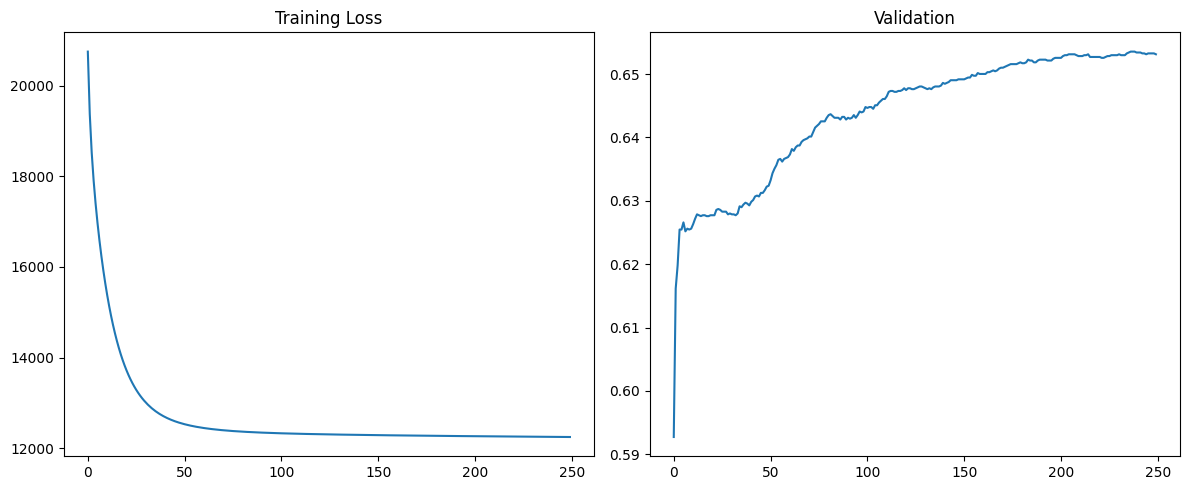

highest valid acc:  0.6535421958791984  in epoch:  236
lowest training err:  12250.571760177612  in epoch  249


In [38]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.002
num_epoch = 250
lamb = 0.02

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15964.564456	 Valid Acc: 0.6236240474174428
Epoch: 1 	Training Cost: 14831.145700	 Valid Acc: 0.624611910810048
Epoch: 2 	Training Cost: 14178.653111	 Valid Acc: 0.6316680779000847
Epoch: 3 	Training Cost: 13684.375922	 Valid Acc: 0.6371718882303133
Epoch: 4 	Training Cost: 13305.108766	 Valid Acc: 0.6423934518769404
Epoch: 5 	Training Cost: 13016.146208	 Valid Acc: 0.6462037821055603
Epoch: 6 	Training Cost: 12798.446158	 Valid Acc: 0.6497318656505786
Epoch: 7 	Training Cost: 12635.729348	 Valid Acc: 0.6531188258537962
Epoch: 8 	Training Cost: 12514.336353	 Valid Acc: 0.6558001693480101
Epoch: 9 	Training Cost: 12423.417557	 Valid Acc: 0.6565057860570138
Epoch: 10 	Training Cost: 12354.715655	 Valid Acc: 0.6584815128422241
Epoch: 11 	Training Cost: 12302.126764	 Valid Acc: 0.6587637595258256
Epoch: 12 	Training Cost: 12261.228405	 Valid Acc: 0.6605983629692351
Epoch: 13 	Training Cost: 12228.852818	 Valid Acc: 0.6615862263618403
Epoch: 14 	Training Cost: 12202

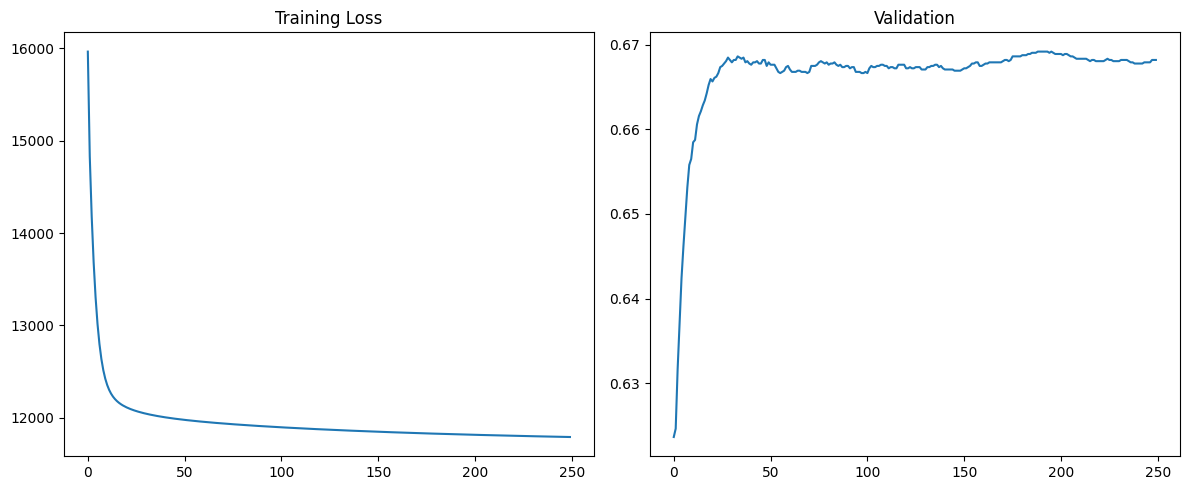

highest valid acc:  0.6692068868190799  in epoch:  188
lowest training err:  11791.58825969696  in epoch  249


In [67]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.02
num_epoch = 250
lamb = 0.008

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16646.351644	 Valid Acc: 0.6268698842788597
Epoch: 1 	Training Cost: 15472.555532	 Valid Acc: 0.6292689810894722
Epoch: 2 	Training Cost: 14905.410669	 Valid Acc: 0.6296923511148744
Epoch: 3 	Training Cost: 14451.319970	 Valid Acc: 0.6301157211402766
Epoch: 4 	Training Cost: 14076.902827	 Valid Acc: 0.6305390911656789
Epoch: 5 	Training Cost: 13763.619337	 Valid Acc: 0.6333615580016935
Epoch: 6 	Training Cost: 13498.931143	 Valid Acc: 0.6360429014959075
Epoch: 7 	Training Cost: 13274.288968	 Valid Acc: 0.6383008749647192
Epoch: 8 	Training Cost: 13083.633124	 Valid Acc: 0.6423934518769404
Epoch: 9 	Training Cost: 12922.338772	 Valid Acc: 0.6445103020039514
Epoch: 10 	Training Cost: 12786.530500	 Valid Acc: 0.6470505221563647
Epoch: 11 	Training Cost: 12672.708208	 Valid Acc: 0.6493084956251765
Epoch: 12 	Training Cost: 12577.635608	 Valid Acc: 0.6517075924357889
Epoch: 13 	Training Cost: 12498.371982	 Valid Acc: 0.6528365791701948
Epoch: 14 	Training Cost: 1243

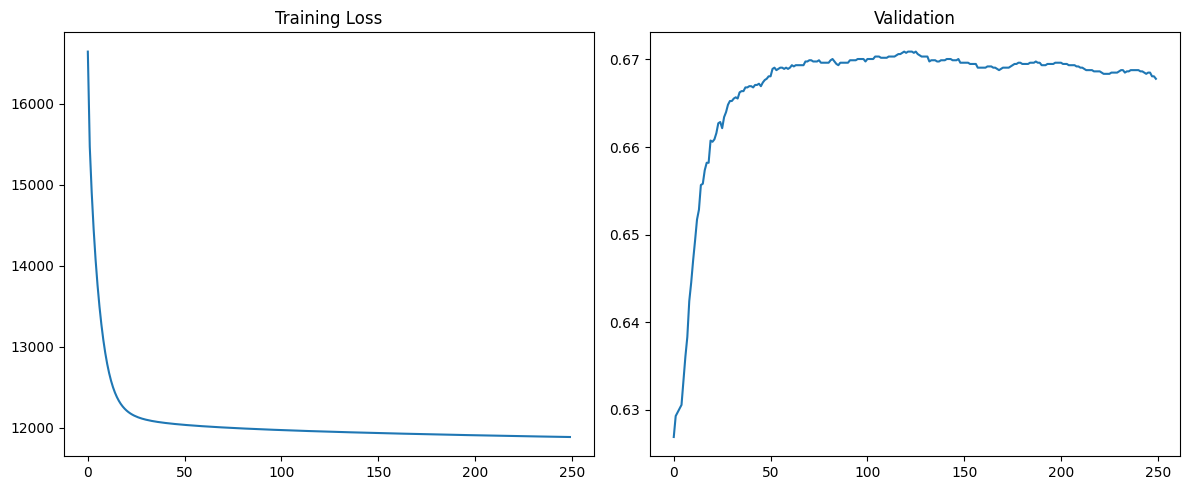

highest valid acc:  0.6709003669206887  in epoch:  119
lowest training err:  11883.080347537994  in epoch  249


In [66]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16542.182968	 Valid Acc: 0.6244707874682472
Epoch: 1 	Training Cost: 15249.032363	 Valid Acc: 0.625176404177251
Epoch: 2 	Training Cost: 14546.925209	 Valid Acc: 0.6271521309624611
Epoch: 3 	Training Cost: 14022.411167	 Valid Acc: 0.6318092012418854
Epoch: 4 	Training Cost: 13621.143357	 Valid Acc: 0.6356195314705052
Epoch: 5 	Training Cost: 13310.704959	 Valid Acc: 0.6401354784081287
Epoch: 6 	Training Cost: 13070.386555	 Valid Acc: 0.6435224386113463
Epoch: 7 	Training Cost: 12885.182449	 Valid Acc: 0.6466271521309624
Epoch: 8 	Training Cost: 12743.124892	 Valid Acc: 0.6491673722833756
Epoch: 9 	Training Cost: 12634.394221	 Valid Acc: 0.6512842224103866
Epoch: 10 	Training Cost: 12551.085653	 Valid Acc: 0.6542478125882021
Epoch: 11 	Training Cost: 12487.011443	 Valid Acc: 0.655376799322608
Epoch: 12 	Training Cost: 12437.419753	 Valid Acc: 0.6560824160316117
Epoch: 13 	Training Cost: 12398.705494	 Valid Acc: 0.6587637595258256
Epoch: 14 	Training Cost: 12368.

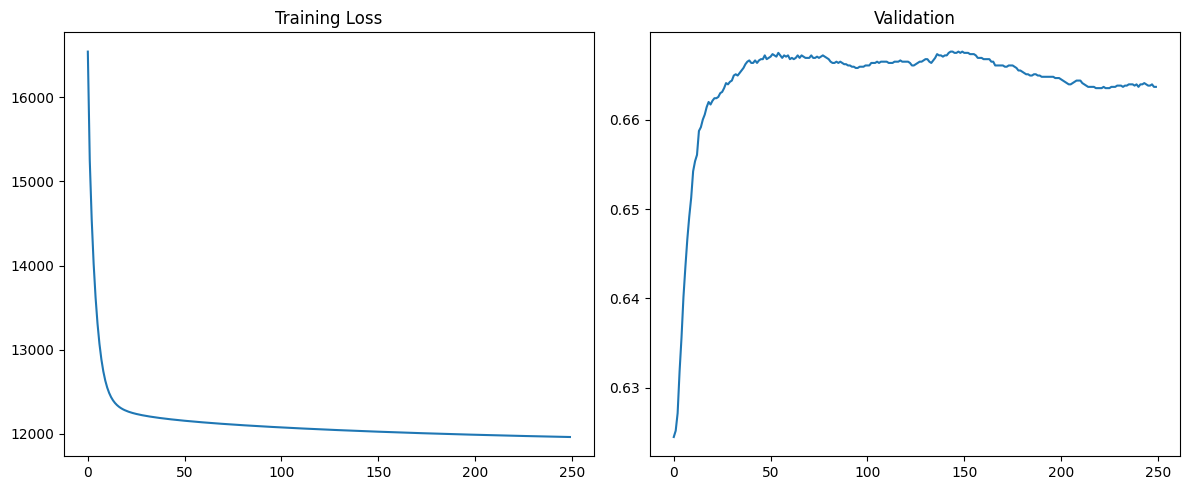

highest valid acc:  0.6676545300592718  in epoch:  143
lowest training err:  11963.101675510406  in epoch  249


In [68]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.015
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

### K = 500

Epoch: 0 	Training Cost: 20361.413714	 Valid Acc: 0.6144510302003952
Epoch: 1 	Training Cost: 17759.421671	 Valid Acc: 0.6162856336438047
Epoch: 2 	Training Cost: 16202.628646	 Valid Acc: 0.6191081004798193
Epoch: 3 	Training Cost: 15191.670860	 Valid Acc: 0.6202370872142252
Epoch: 4 	Training Cost: 14526.392050	 Valid Acc: 0.6200959638724245
Epoch: 5 	Training Cost: 14081.379504	 Valid Acc: 0.6226361840248377
Epoch: 6 	Training Cost: 13778.584278	 Valid Acc: 0.6233418007338414
Epoch: 7 	Training Cost: 13569.240315	 Valid Acc: 0.6250352808354502
Epoch: 8 	Training Cost: 13422.376043	 Valid Acc: 0.6275755009878634
Epoch: 9 	Training Cost: 13317.871043	 Valid Acc: 0.6277166243296641
Epoch: 10 	Training Cost: 13242.395790	 Valid Acc: 0.6289867344058707
Epoch: 11 	Training Cost: 13186.998742	 Valid Acc: 0.6302568444820773
Epoch: 12 	Training Cost: 13145.608959	 Valid Acc: 0.6311035845328817
Epoch: 13 	Training Cost: 13114.074720	 Valid Acc: 0.6329381879762913
Epoch: 14 	Training Cost: 1308

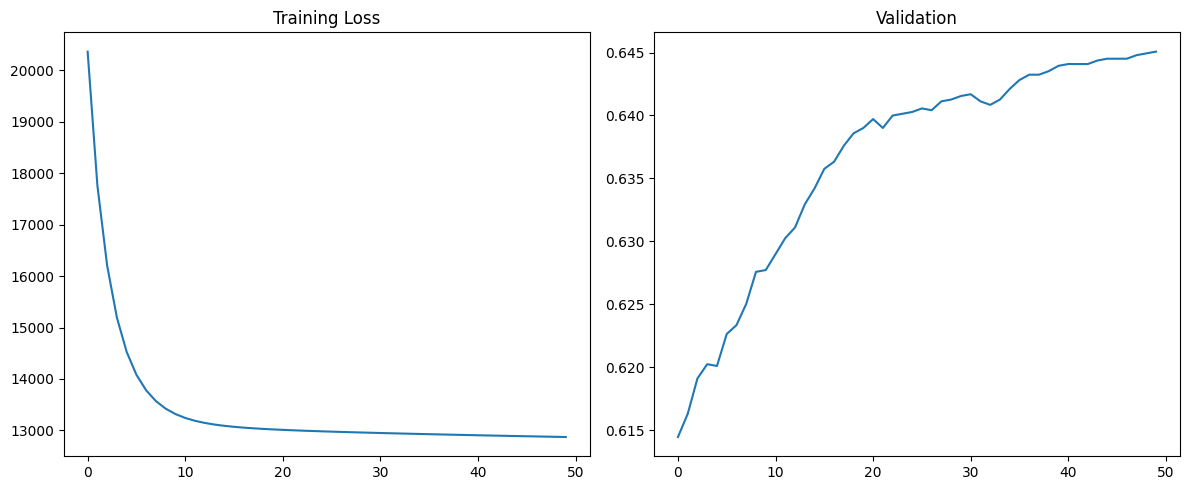

highest valid acc:  0.6450747953711544  in epoch:  49
lowest training err:  12872.01188492775  in epoch  49


In [39]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 50
lamb = 0.02

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17357.414508	 Valid Acc: 0.6161445103020039
Epoch: 1 	Training Cost: 16327.725091	 Valid Acc: 0.617696867061812
Epoch: 2 	Training Cost: 15663.915301	 Valid Acc: 0.6199548405306238
Epoch: 3 	Training Cost: 15122.187873	 Valid Acc: 0.6216483206322325
Epoch: 4 	Training Cost: 14667.890482	 Valid Acc: 0.6253175275190517
Epoch: 5 	Training Cost: 14281.139405	 Valid Acc: 0.6284222410386678
Epoch: 6 	Training Cost: 13952.293350	 Valid Acc: 0.6313858312164832
Epoch: 7 	Training Cost: 13675.566123	 Valid Acc: 0.6329381879762913
Epoch: 8 	Training Cost: 13445.417074	 Valid Acc: 0.6353372847869038
Epoch: 9 	Training Cost: 13255.686919	 Valid Acc: 0.6375952582557155
Epoch: 10 	Training Cost: 13099.977937	 Valid Acc: 0.6377363815975162
Epoch: 11 	Training Cost: 12972.255269	 Valid Acc: 0.6411233418007338
Epoch: 12 	Training Cost: 12867.244084	 Valid Acc: 0.64422805532035
Epoch: 13 	Training Cost: 12780.559516	 Valid Acc: 0.6456392887383573
Epoch: 14 	Training Cost: 12708.6

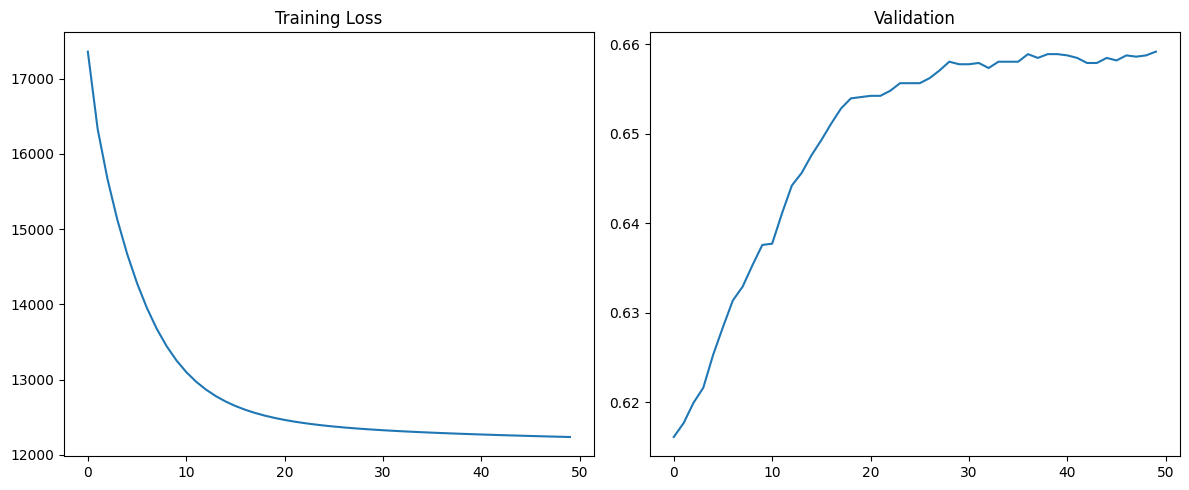

highest valid acc:  0.6591871295512278  in epoch:  49
lowest training err:  12236.622783660889  in epoch  49


In [40]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 50
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 22180.139128	 Valid Acc: 0.5697149308495625
Epoch: 1 	Training Cost: 21347.148659	 Valid Acc: 0.6030200395145358
Epoch: 2 	Training Cost: 20799.032888	 Valid Acc: 0.6088060965283658
Epoch: 3 	Training Cost: 20410.946949	 Valid Acc: 0.6192492238216201
Epoch: 4 	Training Cost: 20113.552407	 Valid Acc: 0.6210838272650296
Epoch: 5 	Training Cost: 19869.482395	 Valid Acc: 0.6223539373412362
Epoch: 6 	Training Cost: 19658.255674	 Valid Acc: 0.6230595540502399
Epoch: 7 	Training Cost: 19468.306514	 Valid Acc: 0.6244707874682472
Epoch: 8 	Training Cost: 19292.889345	 Valid Acc: 0.6253175275190517
Epoch: 9 	Training Cost: 19127.944242	 Valid Acc: 0.6247530341518487
Epoch: 10 	Training Cost: 18970.952634	 Valid Acc: 0.6247530341518487
Epoch: 11 	Training Cost: 18820.305774	 Valid Acc: 0.6248941574936494
Epoch: 12 	Training Cost: 18674.944930	 Valid Acc: 0.6248941574936494
Epoch: 13 	Training Cost: 18534.152924	 Valid Acc: 0.6244707874682472
Epoch: 14 	Training Cost: 1839

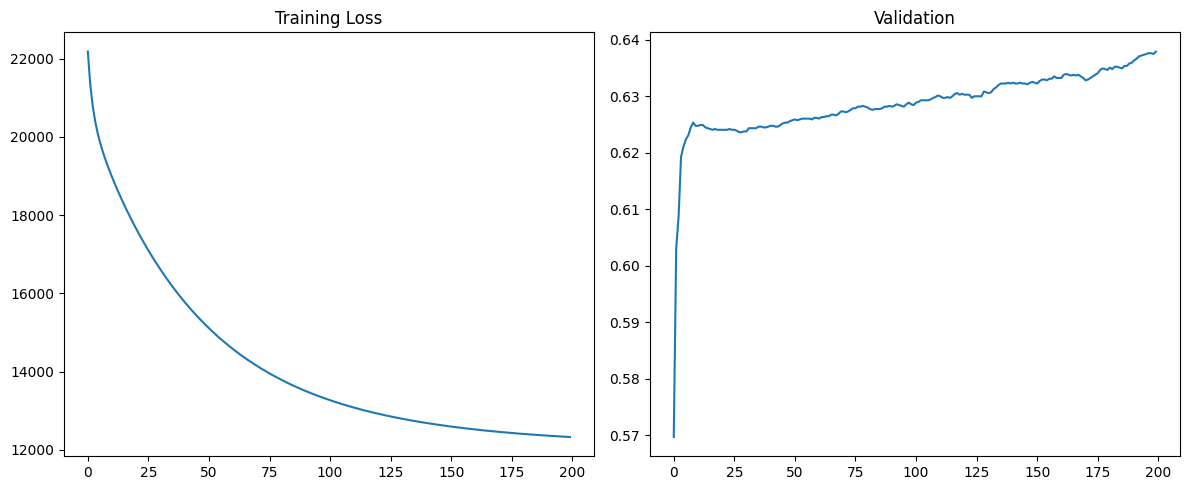

highest valid acc:  0.6378775049393169  in epoch:  199
lowest training err:  12329.746937990189  in epoch  199


In [41]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.0005
num_epoch = 200
lamb = 0.02

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 350214.699081	 Valid Acc: 0.5882020886254586
Epoch: 1 	Training Cost: 52261.180977	 Valid Acc: 0.6164267569856055
Epoch: 2 	Training Cost: 18267.046356	 Valid Acc: 0.619813717188823
Epoch: 3 	Training Cost: 14383.056307	 Valid Acc: 0.6185436071126165
Epoch: 4 	Training Cost: 13935.202216	 Valid Acc: 0.6182613604290149
Epoch: 5 	Training Cost: 13879.633059	 Valid Acc: 0.6185436071126165
Epoch: 6 	Training Cost: 13868.882752	 Valid Acc: 0.6185436071126165
Epoch: 7 	Training Cost: 13863.271086	 Valid Acc: 0.6185436071126165
Epoch: 8 	Training Cost: 13858.264177	 Valid Acc: 0.6189669771380186
Epoch: 9 	Training Cost: 13853.343184	 Valid Acc: 0.6186847304544172
Epoch: 10 	Training Cost: 13848.448411	 Valid Acc: 0.6186847304544172
Epoch: 11 	Training Cost: 13843.573104	 Valid Acc: 0.6185436071126165
Epoch: 12 	Training Cost: 13838.716128	 Valid Acc: 0.6185436071126165
Epoch: 13 	Training Cost: 13833.877521	 Valid Acc: 0.6184024837708157
Epoch: 14 	Training Cost: 1382

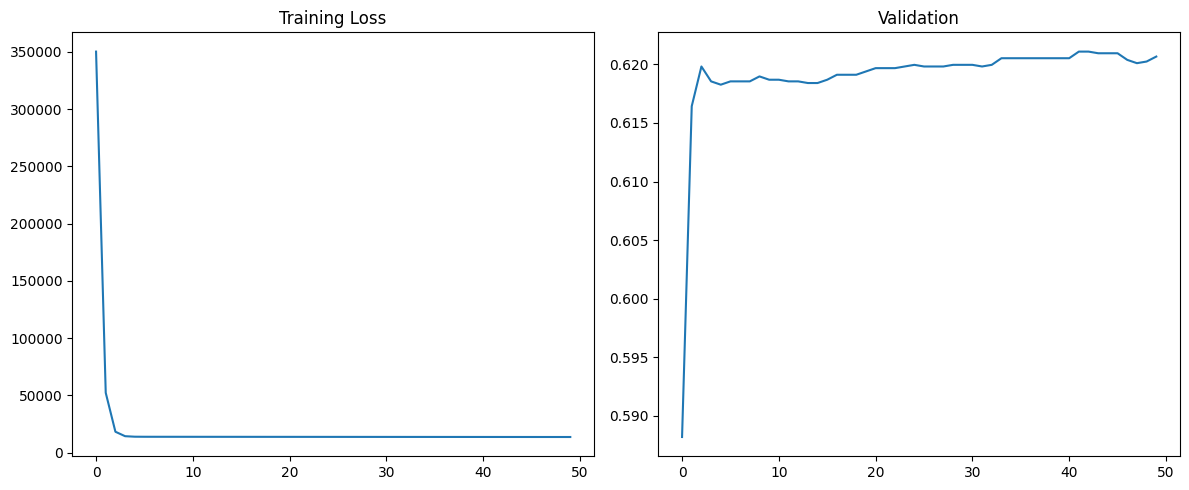

highest valid acc:  0.6210838272650296  in epoch:  41
lowest training err:  13671.269998311996  in epoch  49


In [42]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.0005
num_epoch = 50
lamb = 2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 201425.203640	 Valid Acc: 0.6133220434659893
Epoch: 1 	Training Cost: 16384.102955	 Valid Acc: 0.6193903471634208
Epoch: 2 	Training Cost: 13975.544781	 Valid Acc: 0.6192492238216201
Epoch: 3 	Training Cost: 13934.513165	 Valid Acc: 0.6202370872142252
Epoch: 4 	Training Cost: 13924.285452	 Valid Acc: 0.6209427039232289
Epoch: 5 	Training Cost: 13914.530223	 Valid Acc: 0.6205193338978267
Epoch: 6 	Training Cost: 13904.852722	 Valid Acc: 0.6216483206322325
Epoch: 7 	Training Cost: 13895.247564	 Valid Acc: 0.6216483206322325
Epoch: 8 	Training Cost: 13885.713645	 Valid Acc: 0.6212249506068304
Epoch: 9 	Training Cost: 13876.250633	 Valid Acc: 0.6222128139994355
Epoch: 10 	Training Cost: 13866.857865	 Valid Acc: 0.6222128139994355
Epoch: 11 	Training Cost: 13857.535045	 Valid Acc: 0.6222128139994355
Epoch: 12 	Training Cost: 13848.281219	 Valid Acc: 0.6227773073666384
Epoch: 13 	Training Cost: 13839.096118	 Valid Acc: 0.6227773073666384
Epoch: 14 	Training Cost: 138

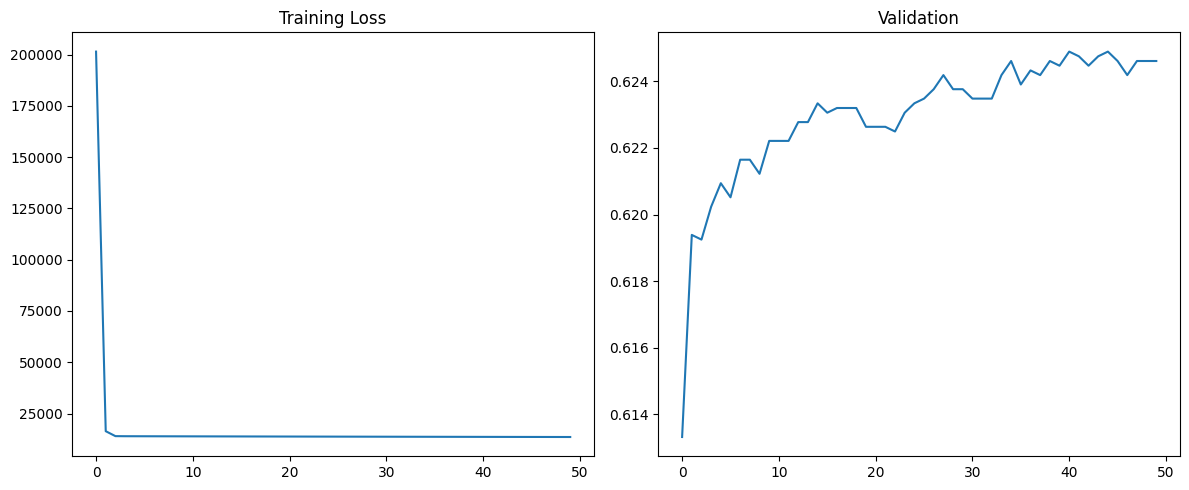

highest valid acc:  0.6248941574936494  in epoch:  40
lowest training err:  13549.764541864395  in epoch  49


In [43]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 80453.290833	 Valid Acc: 0.6066892464013548
Epoch: 1 	Training Cost: 56360.221970	 Valid Acc: 0.6168501270110076
Epoch: 2 	Training Cost: 41031.746929	 Valid Acc: 0.6223539373412362
Epoch: 3 	Training Cost: 31160.333389	 Valid Acc: 0.6232006773920407
Epoch: 4 	Training Cost: 24777.444120	 Valid Acc: 0.6227773073666384
Epoch: 5 	Training Cost: 20644.106362	 Valid Acc: 0.622495060683037
Epoch: 6 	Training Cost: 17965.756736	 Valid Acc: 0.6230595540502399
Epoch: 7 	Training Cost: 16229.575626	 Valid Acc: 0.6230595540502399
Epoch: 8 	Training Cost: 15103.796964	 Valid Acc: 0.6229184307084392
Epoch: 9 	Training Cost: 14373.578059	 Valid Acc: 0.6229184307084392
Epoch: 10 	Training Cost: 13899.731303	 Valid Acc: 0.6229184307084392
Epoch: 11 	Training Cost: 13592.062832	 Valid Acc: 0.6229184307084392
Epoch: 12 	Training Cost: 13392.118954	 Valid Acc: 0.6229184307084392
Epoch: 13 	Training Cost: 13262.012401	 Valid Acc: 0.6229184307084392
Epoch: 14 	Training Cost: 13177

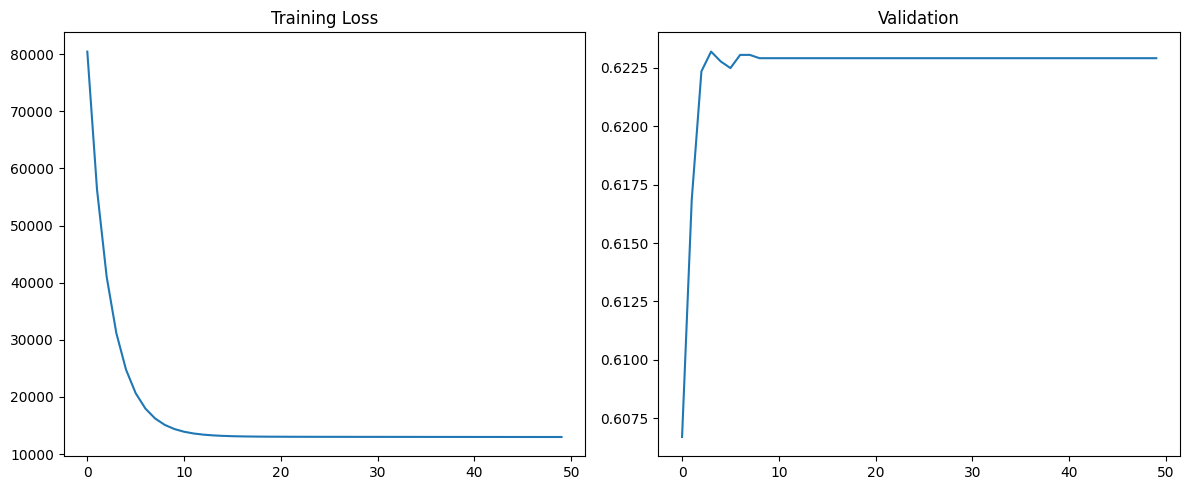

highest valid acc:  0.6232006773920407  in epoch:  3
lowest training err:  12979.462548017502  in epoch  49


In [44]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 50
lamb = 0.2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 66490.696472	 Valid Acc: 0.6095117132373694
Epoch: 1 	Training Cost: 51169.819778	 Valid Acc: 0.6189669771380186
Epoch: 2 	Training Cost: 40440.400814	 Valid Acc: 0.6226361840248377
Epoch: 3 	Training Cost: 32771.321423	 Valid Acc: 0.6232006773920407
Epoch: 4 	Training Cost: 27253.343494	 Valid Acc: 0.6239062941010444
Epoch: 5 	Training Cost: 23273.772840	 Valid Acc: 0.6250352808354502
Epoch: 6 	Training Cost: 20400.978819	 Valid Acc: 0.624611910810048
Epoch: 7 	Training Cost: 18326.226681	 Valid Acc: 0.6244707874682472
Epoch: 8 	Training Cost: 16827.442518	 Valid Acc: 0.6243296641264465
Epoch: 9 	Training Cost: 15744.528837	 Valid Acc: 0.6243296641264465
Epoch: 10 	Training Cost: 14961.956600	 Valid Acc: 0.6241885407846458
Epoch: 11 	Training Cost: 14396.319623	 Valid Acc: 0.6240474174428451
Epoch: 12 	Training Cost: 13987.388855	 Valid Acc: 0.6240474174428451
Epoch: 13 	Training Cost: 13691.665459	 Valid Acc: 0.6240474174428451
Epoch: 14 	Training Cost: 13477

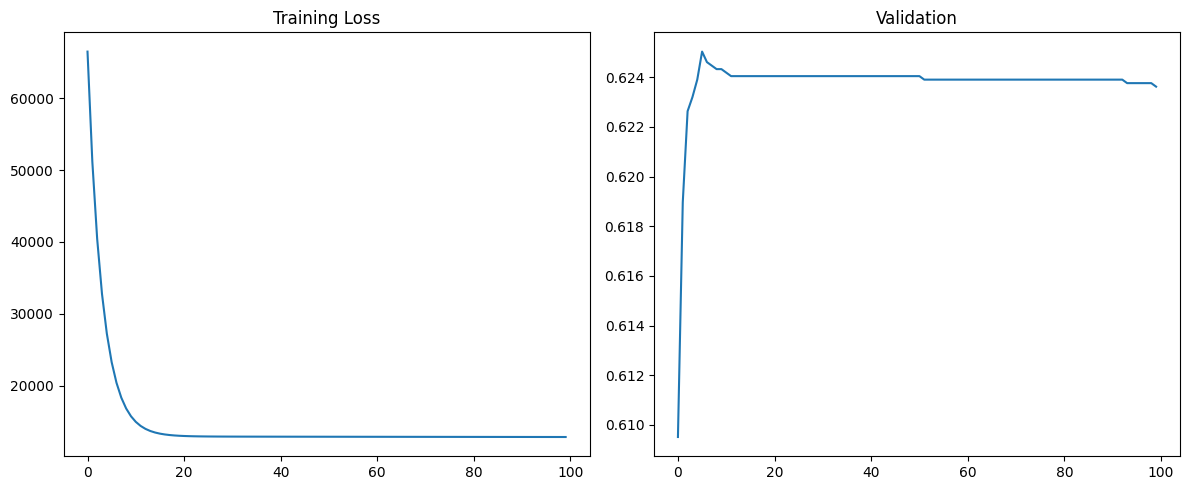

highest valid acc:  0.6250352808354502  in epoch:  5
lowest training err:  12855.366319417953  in epoch  99


In [45]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.001
num_epoch = 100
lamb = 0.15

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 41230.428572	 Valid Acc: 0.6250352808354502
Epoch: 1 	Training Cost: 20886.375937	 Valid Acc: 0.6257408975444538
Epoch: 2 	Training Cost: 15424.665618	 Valid Acc: 0.6257408975444538
Epoch: 3 	Training Cost: 13934.994874	 Valid Acc: 0.6254586508608524
Epoch: 4 	Training Cost: 13526.234641	 Valid Acc: 0.6254586508608524
Epoch: 5 	Training Cost: 13412.042702	 Valid Acc: 0.6254586508608524
Epoch: 6 	Training Cost: 13378.246605	 Valid Acc: 0.6254586508608524
Epoch: 7 	Training Cost: 13366.437971	 Valid Acc: 0.6254586508608524
Epoch: 8 	Training Cost: 13360.663898	 Valid Acc: 0.6254586508608524
Epoch: 9 	Training Cost: 13356.558564	 Valid Acc: 0.6253175275190517
Epoch: 10 	Training Cost: 13352.923816	 Valid Acc: 0.6253175275190517
Epoch: 11 	Training Cost: 13349.429481	 Valid Acc: 0.6253175275190517
Epoch: 12 	Training Cost: 13345.983629	 Valid Acc: 0.6253175275190517
Epoch: 13 	Training Cost: 13342.560497	 Valid Acc: 0.6253175275190517
Epoch: 14 	Training Cost: 1333

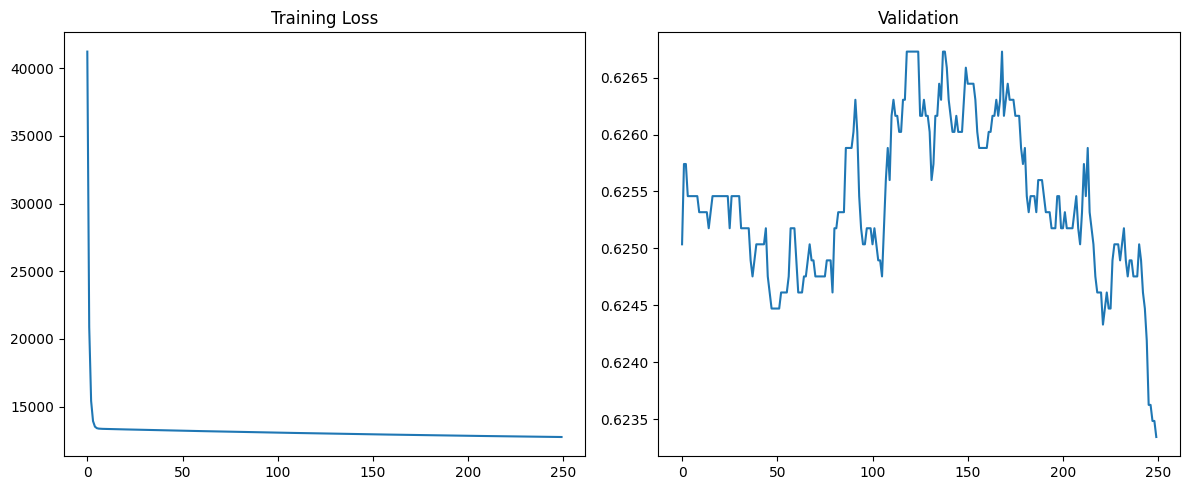

highest valid acc:  0.626728760937059  in epoch:  118
lowest training err:  12758.36126089096  in epoch  249


In [46]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 250
lamb = 0.12

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 40028.812750	 Valid Acc: 0.6216483206322325
Epoch: 1 	Training Cost: 21360.432178	 Valid Acc: 0.6236240474174428
Epoch: 2 	Training Cost: 15785.922876	 Valid Acc: 0.6241885407846458
Epoch: 3 	Training Cost: 14092.167964	 Valid Acc: 0.6248941574936494
Epoch: 4 	Training Cost: 13575.269755	 Valid Acc: 0.6255997742026531
Epoch: 5 	Training Cost: 13415.757207	 Valid Acc: 0.6255997742026531
Epoch: 6 	Training Cost: 13364.922278	 Valid Acc: 0.6255997742026531
Epoch: 7 	Training Cost: 13347.192027	 Valid Acc: 0.6255997742026531
Epoch: 8 	Training Cost: 13339.571683	 Valid Acc: 0.6255997742026531
Epoch: 9 	Training Cost: 13335.052387	 Valid Acc: 0.6254586508608524
Epoch: 10 	Training Cost: 13331.492952	 Valid Acc: 0.6254586508608524
Epoch: 11 	Training Cost: 13328.237418	 Valid Acc: 0.6254586508608524
Epoch: 12 	Training Cost: 13325.083103	 Valid Acc: 0.6253175275190517
Epoch: 13 	Training Cost: 13321.967429	 Valid Acc: 0.6253175275190517
Epoch: 14 	Training Cost: 1331

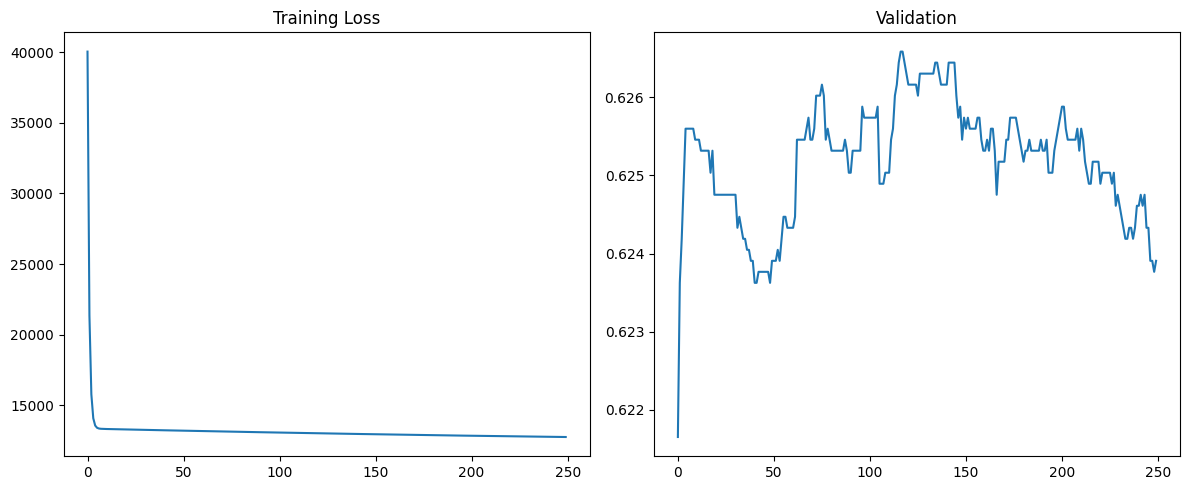

highest valid acc:  0.6265876375952583  in epoch:  116
lowest training err:  12765.962176084518  in epoch  249


In [47]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.005
num_epoch = 250
lamb = 0.11

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 31185.925874	 Valid Acc: 0.607112616426757
Epoch: 1 	Training Cost: 15413.386584	 Valid Acc: 0.6081004798193621
Epoch: 2 	Training Cost: 13964.250974	 Valid Acc: 0.6083827265029635
Epoch: 3 	Training Cost: 13819.758193	 Valid Acc: 0.609229466553768
Epoch: 4 	Training Cost: 13795.957463	 Valid Acc: 0.6102173299463731
Epoch: 5 	Training Cost: 13783.459186	 Valid Acc: 0.6103584532881738
Epoch: 6 	Training Cost: 13772.068600	 Valid Acc: 0.6103584532881738
Epoch: 7 	Training Cost: 13760.817919	 Valid Acc: 0.6109229466553768
Epoch: 8 	Training Cost: 13749.611024	 Valid Acc: 0.6110640699971776
Epoch: 9 	Training Cost: 13738.437617	 Valid Acc: 0.6114874400225797
Epoch: 10 	Training Cost: 13727.296579	 Valid Acc: 0.6116285633643804
Epoch: 11 	Training Cost: 13716.188166	 Valid Acc: 0.611346316680779
Epoch: 12 	Training Cost: 13705.112699	 Valid Acc: 0.611910810047982
Epoch: 13 	Training Cost: 13694.070857	 Valid Acc: 0.6117696867061811
Epoch: 14 	Training Cost: 13683.06

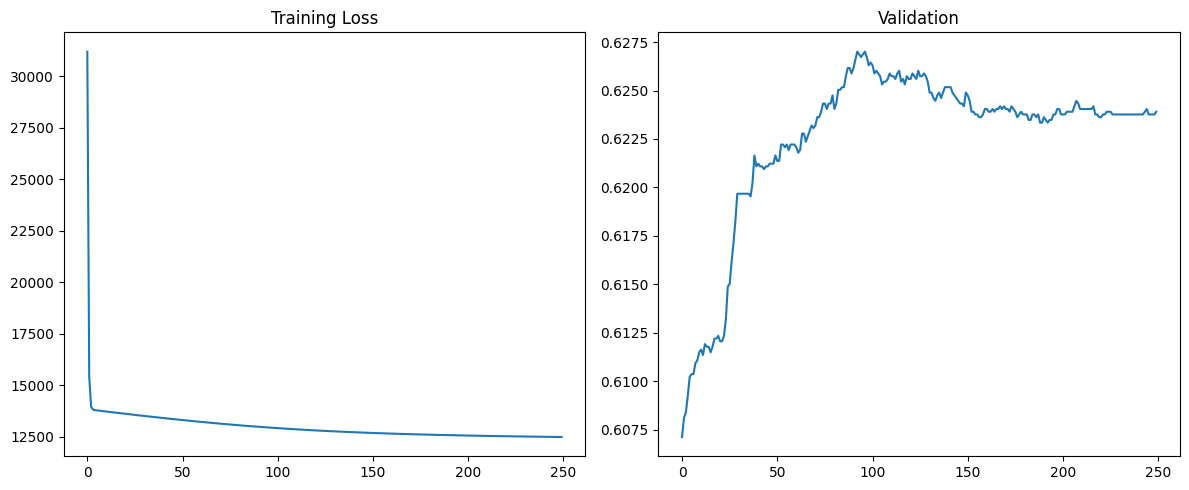

highest valid acc:  0.6270110076206604  in epoch:  92
lowest training err:  12492.446473360062  in epoch  249


In [48]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.11

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17359.166899	 Valid Acc: 0.6138865368331922
Epoch: 1 	Training Cost: 16328.050340	 Valid Acc: 0.617132373694609
Epoch: 2 	Training Cost: 15661.892843	 Valid Acc: 0.6186847304544172
Epoch: 3 	Training Cost: 15117.407556	 Valid Acc: 0.6216483206322325
Epoch: 4 	Training Cost: 14660.877931	 Valid Acc: 0.6241885407846458
Epoch: 5 	Training Cost: 14273.361460	 Valid Acc: 0.6277166243296641
Epoch: 6 	Training Cost: 13945.203036	 Valid Acc: 0.6308213378492803
Epoch: 7 	Training Cost: 13669.884013	 Valid Acc: 0.6319503245836862
Epoch: 8 	Training Cost: 13441.156390	 Valid Acc: 0.6361840248377082
Epoch: 9 	Training Cost: 13252.523165	 Valid Acc: 0.6373130115721141
Epoch: 10 	Training Cost: 13097.553624	 Valid Acc: 0.6378775049393169
Epoch: 11 	Training Cost: 12970.312472	 Valid Acc: 0.6418289585097375
Epoch: 12 	Training Cost: 12865.639037	 Valid Acc: 0.6430990685859441
Epoch: 13 	Training Cost: 12779.230315	 Valid Acc: 0.6445103020039514
Epoch: 14 	Training Cost: 12707

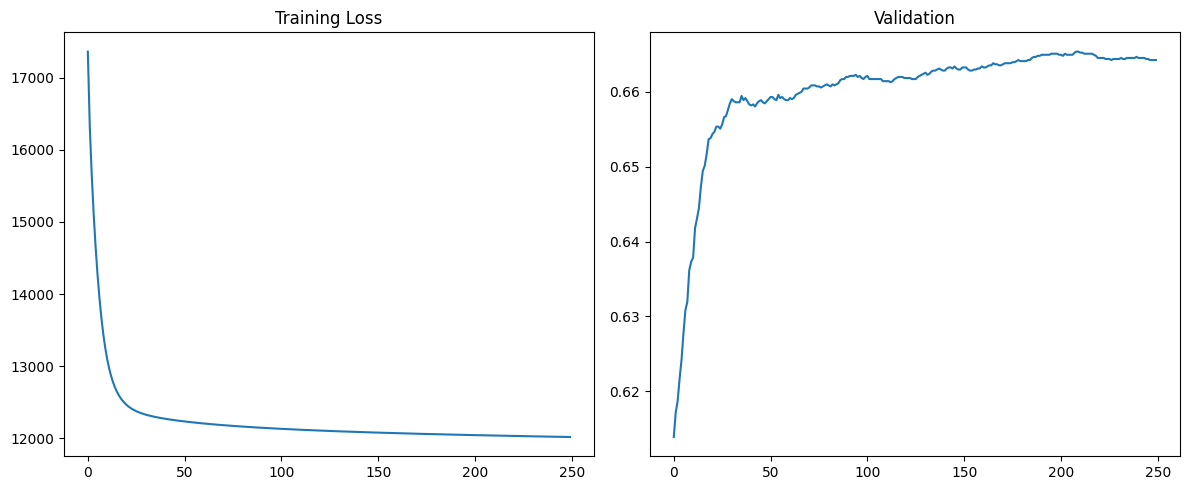

highest valid acc:  0.66539655659046  in epoch:  208
lowest training err:  12018.813596725464  in epoch  249


In [51]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17800.203357	 Valid Acc: 0.5973751058425063
Epoch: 1 	Training Cost: 15346.826393	 Valid Acc: 0.6064069997177534
Epoch: 2 	Training Cost: 14419.610875	 Valid Acc: 0.6161445103020039
Epoch: 3 	Training Cost: 13957.838658	 Valid Acc: 0.624611910810048
Epoch: 4 	Training Cost: 13710.076448	 Valid Acc: 0.6285633643804686
Epoch: 5 	Training Cost: 13556.205956	 Valid Acc: 0.6305390911656789
Epoch: 6 	Training Cost: 13446.064481	 Valid Acc: 0.6333615580016935
Epoch: 7 	Training Cost: 13359.271767	 Valid Acc: 0.6342082980524979
Epoch: 8 	Training Cost: 13286.878899	 Valid Acc: 0.6360429014959075
Epoch: 9 	Training Cost: 13224.470376	 Valid Acc: 0.6392887383573242
Epoch: 10 	Training Cost: 13169.564930	 Valid Acc: 0.6406999717753317
Epoch: 11 	Training Cost: 13120.594204	 Valid Acc: 0.6415467118261361
Epoch: 12 	Training Cost: 13076.476341	 Valid Acc: 0.6432401919277448
Epoch: 13 	Training Cost: 13036.417783	 Valid Acc: 0.64422805532035
Epoch: 14 	Training Cost: 12999.8

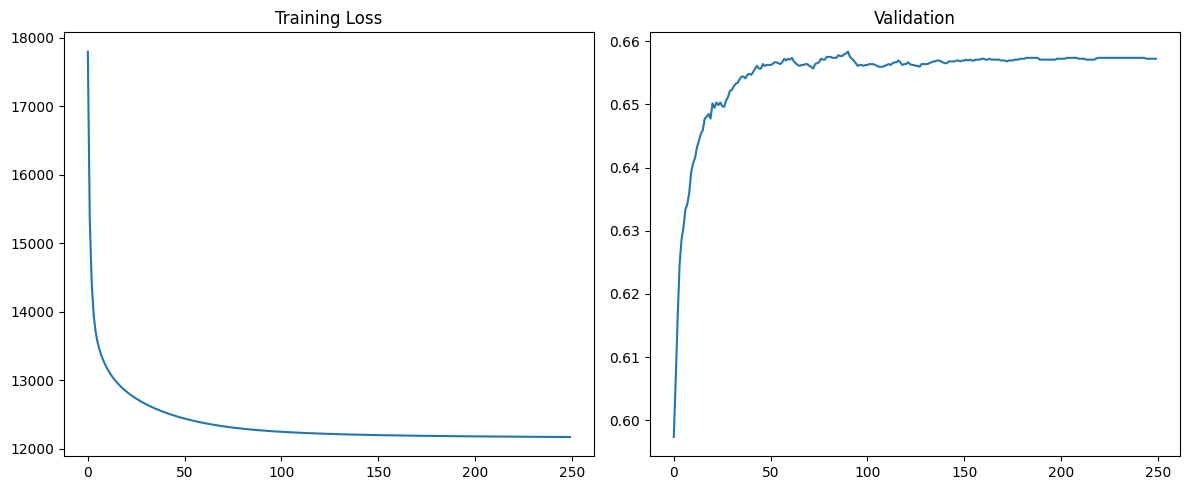

highest valid acc:  0.6583403895004234  in epoch:  90
lowest training err:  12168.396339893341  in epoch  249


In [54]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.05
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16711.385158	 Valid Acc: 0.6025966694891335
Epoch: 1 	Training Cost: 15054.449700	 Valid Acc: 0.6138865368331922
Epoch: 2 	Training Cost: 14142.517117	 Valid Acc: 0.6261642675698561
Epoch: 3 	Training Cost: 13567.508651	 Valid Acc: 0.6320914479254869
Epoch: 4 	Training Cost: 13212.313554	 Valid Acc: 0.639994355066328
Epoch: 5 	Training Cost: 12974.463416	 Valid Acc: 0.6467682754727632
Epoch: 6 	Training Cost: 12805.413638	 Valid Acc: 0.6481795088907706
Epoch: 7 	Training Cost: 12679.209662	 Valid Acc: 0.6521309624611911
Epoch: 8 	Training Cost: 12580.824778	 Valid Acc: 0.6536833192209992
Epoch: 9 	Training Cost: 12500.996046	 Valid Acc: 0.6532599491955969
Epoch: 10 	Training Cost: 12433.684705	 Valid Acc: 0.6548123059554051
Epoch: 11 	Training Cost: 12375.088481	 Valid Acc: 0.6543889359300028
Epoch: 12 	Training Cost: 12322.895557	 Valid Acc: 0.6550945526390065
Epoch: 13 	Training Cost: 12275.796049	 Valid Acc: 0.6549534292972058
Epoch: 14 	Training Cost: 12233

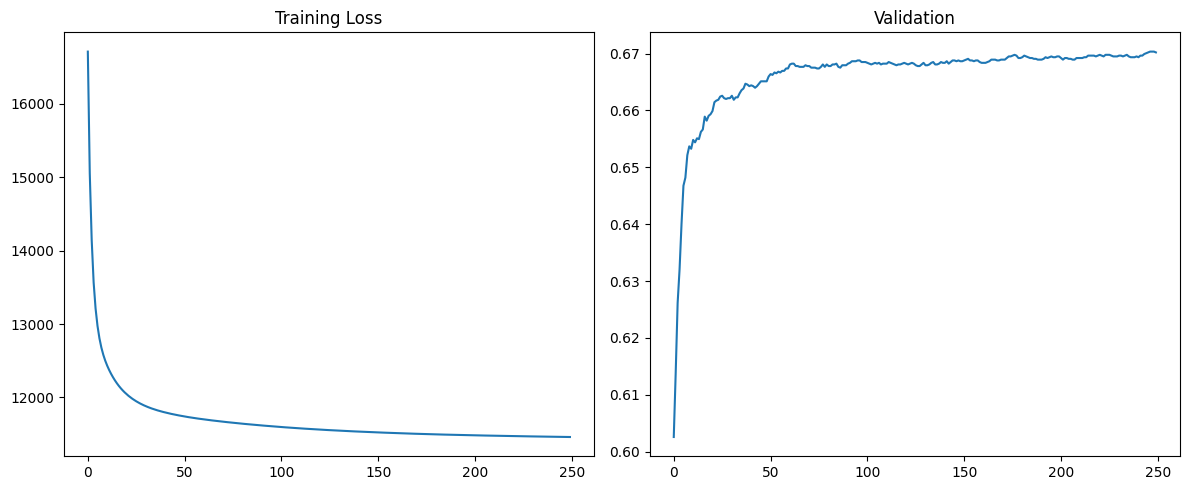

highest valid acc:  0.6703358735534858  in epoch:  246
lowest training err:  11461.841562271118  in epoch  249


In [59]:
k = 500  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.05
num_epoch = 250
lamb = 0.005

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

## Regularized second take

In [13]:
def train_plot_regu_gpu(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = torch.isnan(train_data[user_id].unsqueeze(0))
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            loss = loss + lamb * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

In [116]:
# change the matrices to gpu
train_matrix_gpu = train_matrix.to(device)
zero_train_matrix_gpu = zero_train_matrix.to(device)

Epoch: 0 	Training Cost: 30668.914262	 Valid Acc: 0.5948348856900931
Epoch: 1 	Training Cost: 14044.622766	 Valid Acc: 0.602314422805532
Epoch: 2 	Training Cost: 13976.094787	 Valid Acc: 0.6061247530341518
Epoch: 3 	Training Cost: 13911.958530	 Valid Acc: 0.6099350832627717
Epoch: 4 	Training Cost: 13851.604246	 Valid Acc: 0.6143099068585944
Epoch: 5 	Training Cost: 13794.741455	 Valid Acc: 0.615015523567598
Epoch: 6 	Training Cost: 13741.106641	 Valid Acc: 0.6164267569856055
Epoch: 7 	Training Cost: 13690.461271	 Valid Acc: 0.6168501270110076
Epoch: 8 	Training Cost: 13642.588330	 Valid Acc: 0.6178379904036128
Epoch: 9 	Training Cost: 13597.290838	 Valid Acc: 0.6189669771380186
Epoch: 10 	Training Cost: 13554.388901	 Valid Acc: 0.6203782105560259
Epoch: 11 	Training Cost: 13513.718180	 Valid Acc: 0.6202370872142252
Epoch: 12 	Training Cost: 13475.128750	 Valid Acc: 0.6205193338978267
Epoch: 13 	Training Cost: 13438.482697	 Valid Acc: 0.6206604572396275
Epoch: 14 	Training Cost: 13403.

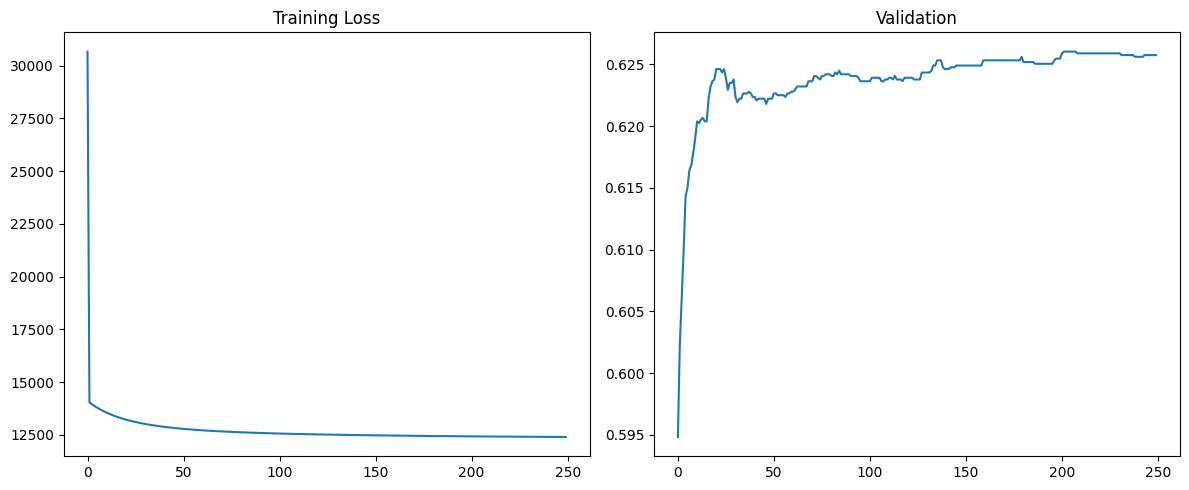

highest valid acc:  0.6260231442280553  in epoch:  201
lowest training err:  12402.950471162796  in epoch  249


In [15]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.5

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 29316.385731	 Valid Acc: 0.5667513406717472
Epoch: 1 	Training Cost: 13985.181449	 Valid Acc: 0.5814281682190234
Epoch: 2 	Training Cost: 13874.670637	 Valid Acc: 0.596528365791702
Epoch: 3 	Training Cost: 13773.501247	 Valid Acc: 0.6034434095399379
Epoch: 4 	Training Cost: 13680.558880	 Valid Acc: 0.6099350832627717
Epoch: 5 	Training Cost: 13595.096622	 Valid Acc: 0.6106406999717753
Epoch: 6 	Training Cost: 13516.433783	 Valid Acc: 0.6137454134913914
Epoch: 7 	Training Cost: 13443.952803	 Valid Acc: 0.6158622636184025
Epoch: 8 	Training Cost: 13377.094062	 Valid Acc: 0.6167090036692069
Epoch: 9 	Training Cost: 13315.352437	 Valid Acc: 0.6167090036692069
Epoch: 10 	Training Cost: 13258.271752	 Valid Acc: 0.6188258537962179
Epoch: 11 	Training Cost: 13205.440279	 Valid Acc: 0.6200959638724245
Epoch: 12 	Training Cost: 13156.486766	 Valid Acc: 0.6206604572396275
Epoch: 13 	Training Cost: 13111.076050	 Valid Acc: 0.6212249506068304
Epoch: 14 	Training Cost: 13068

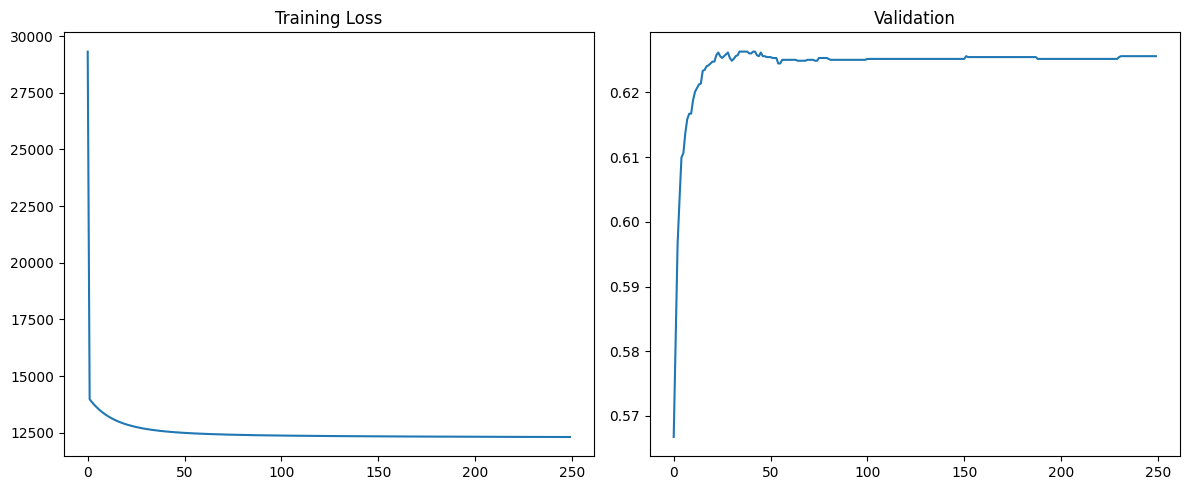

highest valid acc:  0.6263053909116568  in epoch:  34
lowest training err:  12316.04421877861  in epoch  249


In [18]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.5

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 29079.008975	 Valid Acc: 0.611910810047982
Epoch: 1 	Training Cost: 14034.904153	 Valid Acc: 0.6178379904036128
Epoch: 2 	Training Cost: 13759.181529	 Valid Acc: 0.6195314705052216
Epoch: 3 	Training Cost: 13680.444992	 Valid Acc: 0.6210838272650296
Epoch: 4 	Training Cost: 13610.053141	 Valid Acc: 0.6199548405306238
Epoch: 5 	Training Cost: 13544.869560	 Valid Acc: 0.6210838272650296
Epoch: 6 	Training Cost: 13484.349379	 Valid Acc: 0.6202370872142252
Epoch: 7 	Training Cost: 13428.051353	 Valid Acc: 0.6209427039232289
Epoch: 8 	Training Cost: 13375.587542	 Valid Acc: 0.6199548405306238
Epoch: 9 	Training Cost: 13326.613861	 Valid Acc: 0.6196725938470223
Epoch: 10 	Training Cost: 13280.824535	 Valid Acc: 0.6205193338978267
Epoch: 11 	Training Cost: 13237.947379	 Valid Acc: 0.6208015805814282
Epoch: 12 	Training Cost: 13197.738846	 Valid Acc: 0.6202370872142252
Epoch: 13 	Training Cost: 13159.981248	 Valid Acc: 0.6200959638724245
Epoch: 14 	Training Cost: 13124

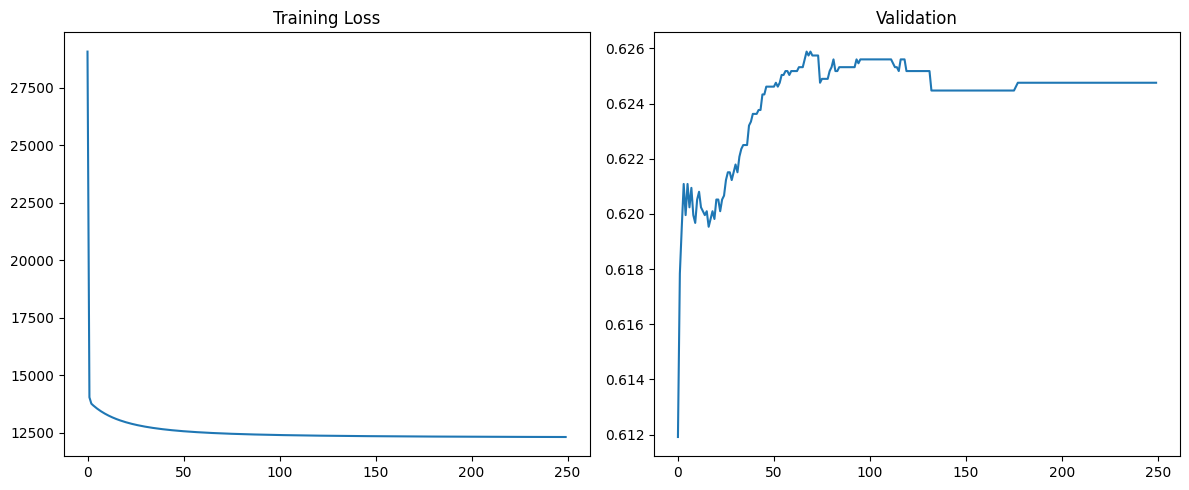

highest valid acc:  0.6258820208862546  in epoch:  67
lowest training err:  12307.94927740097  in epoch  249


In [19]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.2

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 27447.104878	 Valid Acc: 0.6147332768839966
Epoch: 1 	Training Cost: 15146.649522	 Valid Acc: 0.6222128139994355
Epoch: 2 	Training Cost: 13720.908522	 Valid Acc: 0.6241885407846458
Epoch: 3 	Training Cost: 13517.892368	 Valid Acc: 0.625176404177251
Epoch: 4 	Training Cost: 13456.538825	 Valid Acc: 0.6258820208862546
Epoch: 5 	Training Cost: 13413.899935	 Valid Acc: 0.6258820208862546
Epoch: 6 	Training Cost: 13375.559407	 Valid Acc: 0.6255997742026531
Epoch: 7 	Training Cost: 13339.632495	 Valid Acc: 0.6253175275190517
Epoch: 8 	Training Cost: 13305.725703	 Valid Acc: 0.6250352808354502
Epoch: 9 	Training Cost: 13273.643825	 Valid Acc: 0.6257408975444538
Epoch: 10 	Training Cost: 13243.232828	 Valid Acc: 0.6257408975444538
Epoch: 11 	Training Cost: 13214.358641	 Valid Acc: 0.6257408975444538
Epoch: 12 	Training Cost: 13186.901193	 Valid Acc: 0.6254586508608524
Epoch: 13 	Training Cost: 13160.753128	 Valid Acc: 0.6253175275190517
Epoch: 14 	Training Cost: 13135

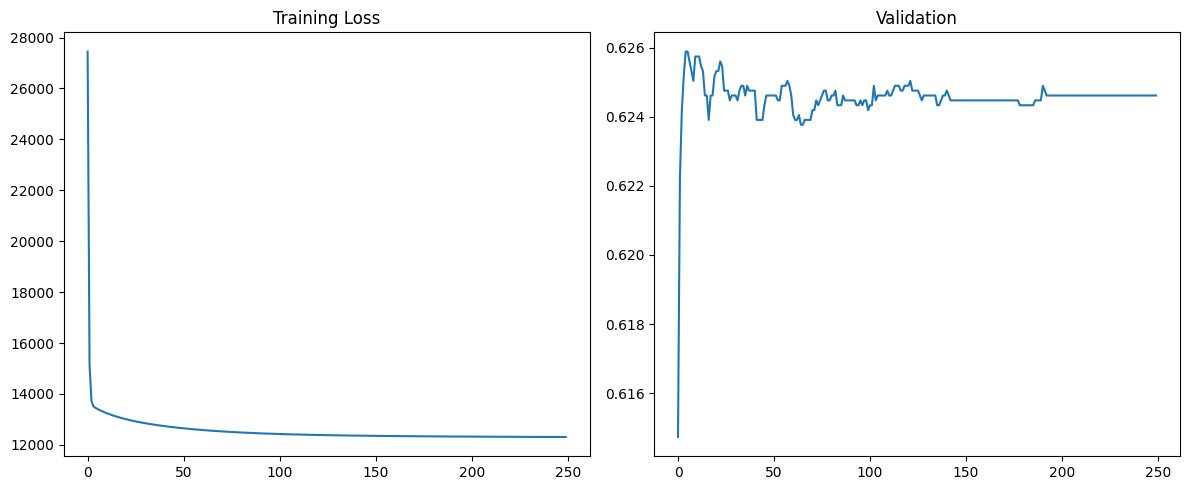

highest valid acc:  0.6258820208862546  in epoch:  4
lowest training err:  12309.066229104996  in epoch  249


In [20]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.1

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 23925.707882	 Valid Acc: 0.611346316680779
Epoch: 1 	Training Cost: 16718.957330	 Valid Acc: 0.6270110076206604
Epoch: 2 	Training Cost: 14394.010504	 Valid Acc: 0.626728760937059
Epoch: 3 	Training Cost: 13613.120873	 Valid Acc: 0.6271521309624611
Epoch: 4 	Training Cost: 13336.380530	 Valid Acc: 0.6274343776460627
Epoch: 5 	Training Cost: 13229.641580	 Valid Acc: 0.6275755009878634
Epoch: 6 	Training Cost: 13181.268897	 Valid Acc: 0.6278577476714648
Epoch: 7 	Training Cost: 13153.391962	 Valid Acc: 0.6281399943550663
Epoch: 8 	Training Cost: 13133.043600	 Valid Acc: 0.62884561106407
Epoch: 9 	Training Cost: 13115.732491	 Valid Acc: 0.6279988710132656
Epoch: 10 	Training Cost: 13099.871792	 Valid Acc: 0.6281399943550663
Epoch: 11 	Training Cost: 13084.878456	 Valid Acc: 0.6278577476714648
Epoch: 12 	Training Cost: 13070.521109	 Valid Acc: 0.6275755009878634
Epoch: 13 	Training Cost: 13056.694669	 Valid Acc: 0.6271521309624611
Epoch: 14 	Training Cost: 13043.34

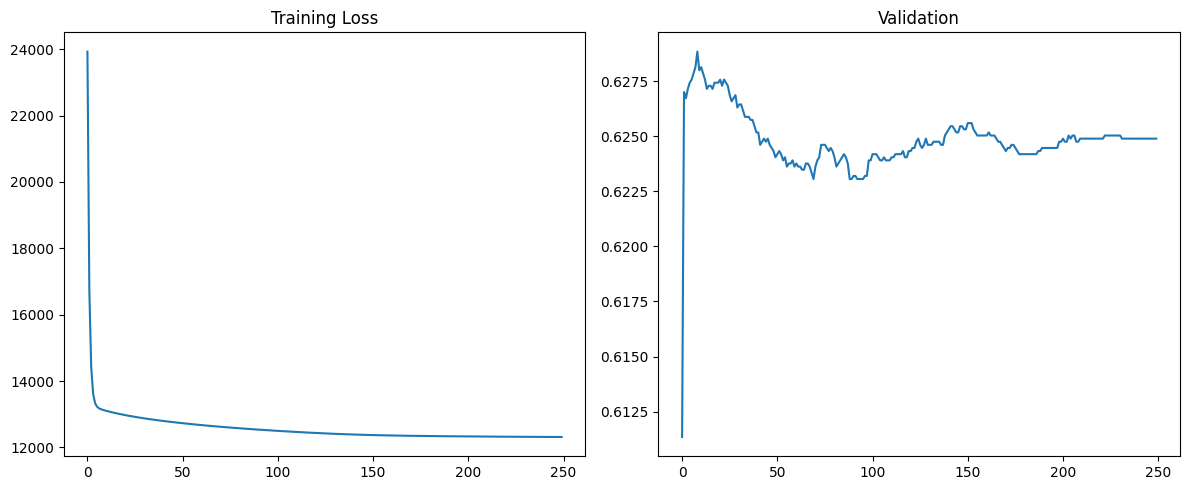

highest valid acc:  0.62884561106407  in epoch:  8
lowest training err:  12313.589364767075  in epoch  249


In [21]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.05

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16787.845572	 Valid Acc: 0.6052780129833475
Epoch: 1 	Training Cost: 15303.621428	 Valid Acc: 0.6229184307084392
Epoch: 2 	Training Cost: 14589.557053	 Valid Acc: 0.6247530341518487
Epoch: 3 	Training Cost: 14153.706141	 Valid Acc: 0.6264465142534575
Epoch: 4 	Training Cost: 13824.464159	 Valid Acc: 0.6289867344058707
Epoch: 5 	Training Cost: 13561.394797	 Valid Acc: 0.6292689810894722
Epoch: 6 	Training Cost: 13347.630167	 Valid Acc: 0.6299745977984759
Epoch: 7 	Training Cost: 13171.959010	 Valid Acc: 0.6302568444820773
Epoch: 8 	Training Cost: 13026.028445	 Valid Acc: 0.632514817950889
Epoch: 9 	Training Cost: 12903.532630	 Valid Acc: 0.6344905447360993
Epoch: 10 	Training Cost: 12799.730767	 Valid Acc: 0.6356195314705052
Epoch: 11 	Training Cost: 12711.070163	 Valid Acc: 0.6377363815975162
Epoch: 12 	Training Cost: 12634.866751	 Valid Acc: 0.6374541349139148
Epoch: 13 	Training Cost: 12569.053477	 Valid Acc: 0.6406999717753317
Epoch: 14 	Training Cost: 12511

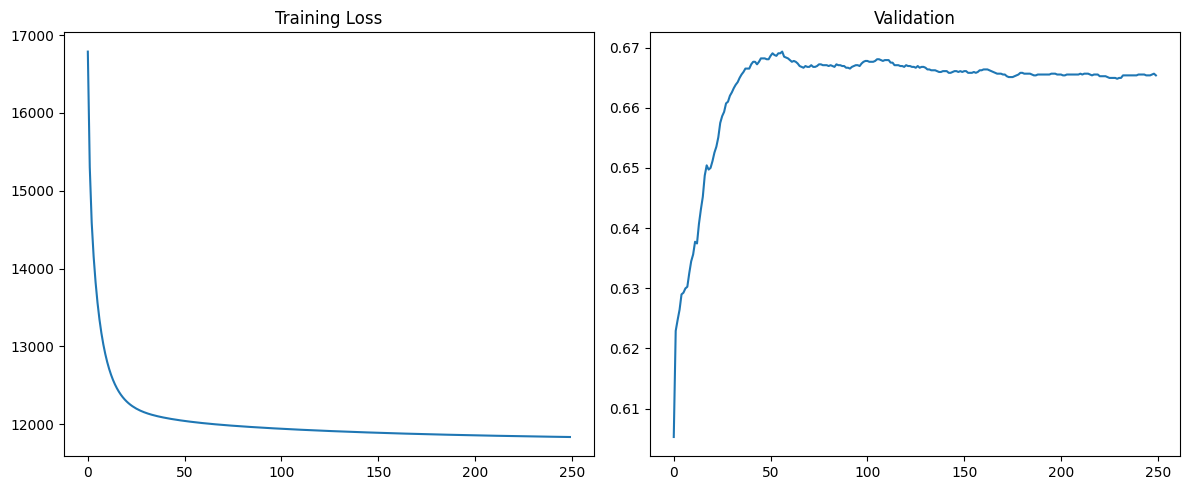

highest valid acc:  0.6693480101608806  in epoch:  56
lowest training err:  11835.390660524368  in epoch  249


In [22]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15390.879589	 Valid Acc: 0.6034434095399379
Epoch: 1 	Training Cost: 14259.174822	 Valid Acc: 0.619813717188823
Epoch: 2 	Training Cost: 13814.463268	 Valid Acc: 0.6250352808354502
Epoch: 3 	Training Cost: 13581.777575	 Valid Acc: 0.6271521309624611
Epoch: 4 	Training Cost: 13399.182395	 Valid Acc: 0.6279988710132656
Epoch: 5 	Training Cost: 13237.137154	 Valid Acc: 0.6278577476714648
Epoch: 6 	Training Cost: 13089.015035	 Valid Acc: 0.630397967823878
Epoch: 7 	Training Cost: 12951.543270	 Valid Acc: 0.6332204346598928
Epoch: 8 	Training Cost: 12822.462901	 Valid Acc: 0.6374541349139148
Epoch: 9 	Training Cost: 12700.347886	 Valid Acc: 0.6392887383573242
Epoch: 10 	Training Cost: 12584.522707	 Valid Acc: 0.6419700818515383
Epoch: 11 	Training Cost: 12474.907953	 Valid Acc: 0.6462037821055603
Epoch: 12 	Training Cost: 12371.790239	 Valid Acc: 0.6483206322325713
Epoch: 13 	Training Cost: 12275.575964	 Valid Acc: 0.6494496189669772
Epoch: 14 	Training Cost: 12186.

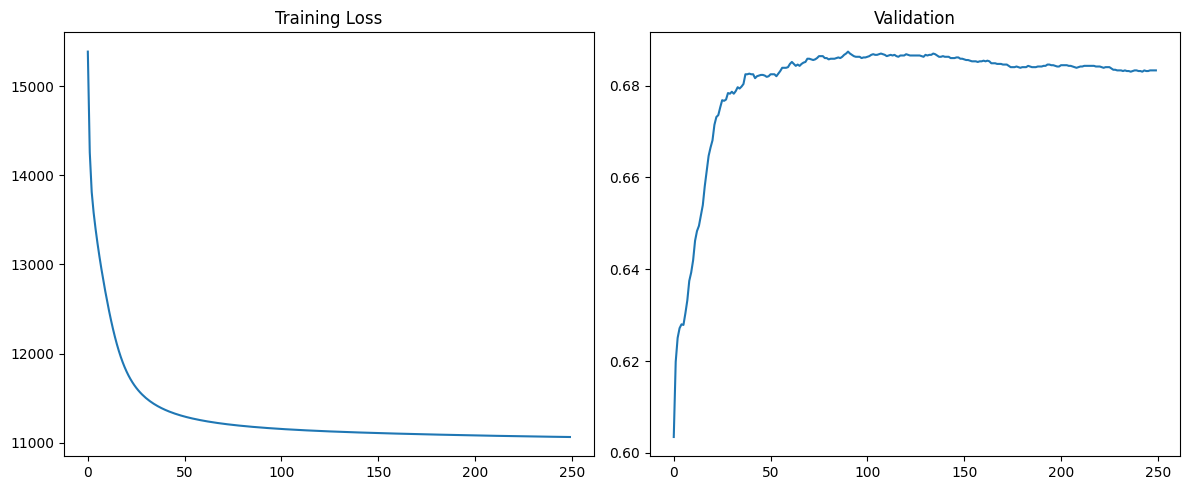

highest valid acc:  0.6874117979113745  in epoch:  90
lowest training err:  11062.641187667847  in epoch  249


In [23]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.005

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15035.780122	 Valid Acc: 0.6179791137454135
Epoch: 1 	Training Cost: 13906.175689	 Valid Acc: 0.6270110076206604
Epoch: 2 	Training Cost: 13505.780771	 Valid Acc: 0.6308213378492803
Epoch: 3 	Training Cost: 13197.747527	 Valid Acc: 0.6366073948631104
Epoch: 4 	Training Cost: 12938.355866	 Valid Acc: 0.6390064916737228
Epoch: 5 	Training Cost: 12711.974601	 Valid Acc: 0.6428168219023427
Epoch: 6 	Training Cost: 12513.070480	 Valid Acc: 0.6502963590177815
Epoch: 7 	Training Cost: 12340.517530	 Valid Acc: 0.6566469093988145
Epoch: 8 	Training Cost: 12193.440418	 Valid Acc: 0.6603161162856337
Epoch: 9 	Training Cost: 12070.023286	 Valid Acc: 0.6618684730454417
Epoch: 10 	Training Cost: 11967.604140	 Valid Acc: 0.6655376799322608
Epoch: 11 	Training Cost: 11883.087026	 Valid Acc: 0.6693480101608806
Epoch: 12 	Training Cost: 11813.315613	 Valid Acc: 0.6704769968952865
Epoch: 13 	Training Cost: 11755.397963	 Valid Acc: 0.6714648602878917
Epoch: 14 	Training Cost: 1170

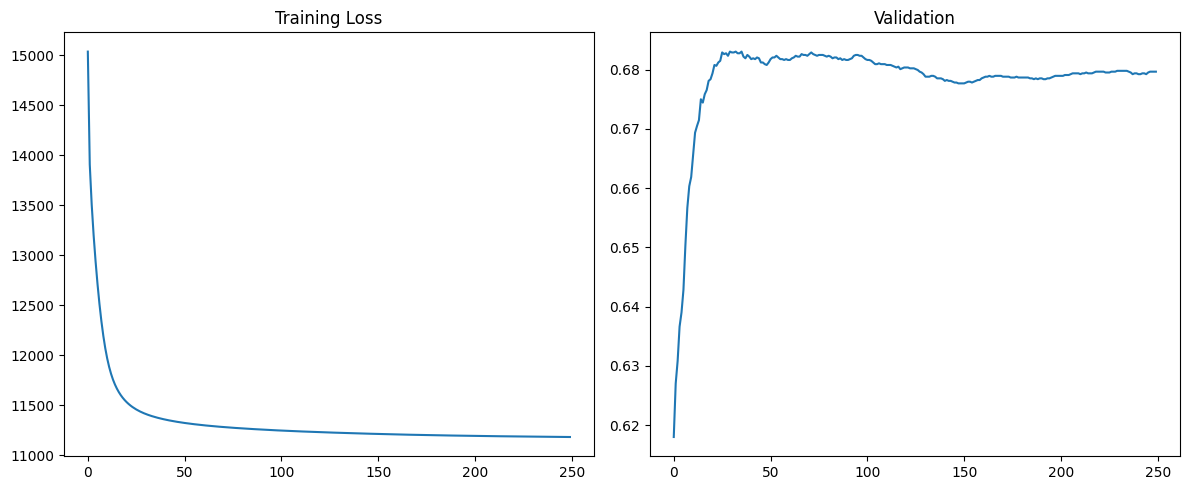

highest valid acc:  0.6830369743155518  in epoch:  29
lowest training err:  11181.659273147583  in epoch  249


In [27]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.02
num_epoch = 250
lamb = 0.005

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16009.180385	 Valid Acc: 0.6024555461473328
Epoch: 1 	Training Cost: 14745.670523	 Valid Acc: 0.6191081004798193
Epoch: 2 	Training Cost: 14185.129671	 Valid Acc: 0.6264465142534575
Epoch: 3 	Training Cost: 13874.238329	 Valid Acc: 0.6271521309624611
Epoch: 4 	Training Cost: 13635.090487	 Valid Acc: 0.6299745977984759
Epoch: 5 	Training Cost: 13432.263743	 Valid Acc: 0.6302568444820773
Epoch: 6 	Training Cost: 13256.022470	 Valid Acc: 0.6311035845328817
Epoch: 7 	Training Cost: 13100.895308	 Valid Acc: 0.6316680779000847
Epoch: 8 	Training Cost: 12962.853180	 Valid Acc: 0.6343494213942986
Epoch: 9 	Training Cost: 12838.934022	 Valid Acc: 0.6370307648885125
Epoch: 10 	Training Cost: 12727.042790	 Valid Acc: 0.639994355066328
Epoch: 11 	Training Cost: 12625.691533	 Valid Acc: 0.6409822184589331
Epoch: 12 	Training Cost: 12533.764661	 Valid Acc: 0.6449336720293537
Epoch: 13 	Training Cost: 12450.376084	 Valid Acc: 0.646344905447361
Epoch: 14 	Training Cost: 12374.

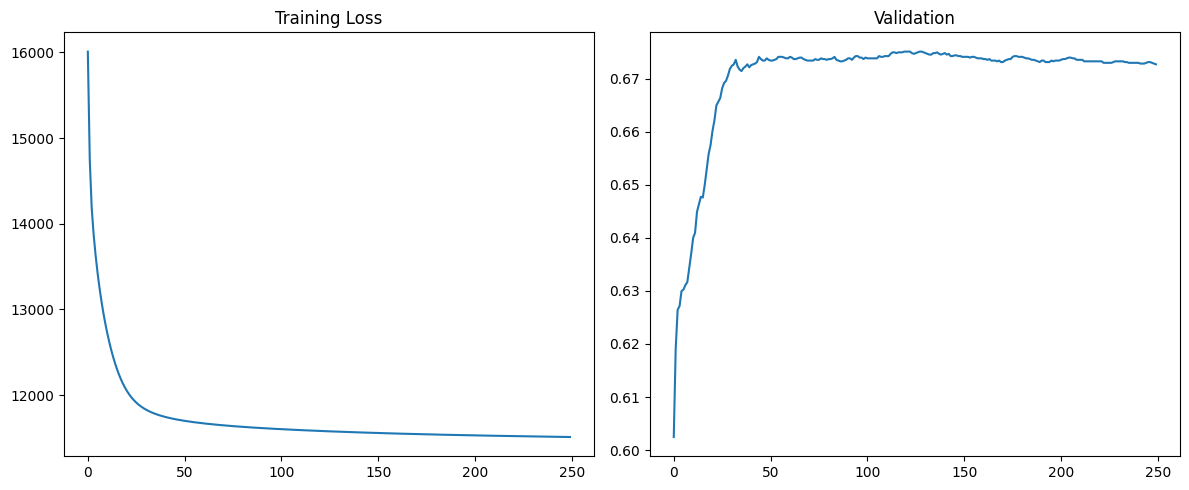

highest valid acc:  0.6751340671747107  in epoch:  119
lowest training err:  11510.500283241272  in epoch  249


In [24]:
k = 50  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.007

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16605.844243	 Valid Acc: 0.6202370872142252
Epoch: 1 	Training Cost: 15228.717510	 Valid Acc: 0.6255997742026531
Epoch: 2 	Training Cost: 14649.988668	 Valid Acc: 0.6277166243296641
Epoch: 3 	Training Cost: 14226.633898	 Valid Acc: 0.629410104431273
Epoch: 4 	Training Cost: 13885.361531	 Valid Acc: 0.629410104431273
Epoch: 5 	Training Cost: 13605.226859	 Valid Acc: 0.6319503245836862
Epoch: 6 	Training Cost: 13372.645269	 Valid Acc: 0.6329381879762913
Epoch: 7 	Training Cost: 13177.583430	 Valid Acc: 0.635196161445103
Epoch: 8 	Training Cost: 13012.591455	 Valid Acc: 0.6370307648885125
Epoch: 9 	Training Cost: 12872.186070	 Valid Acc: 0.6394298616991251
Epoch: 10 	Training Cost: 12752.321714	 Valid Acc: 0.6402766017499294
Epoch: 11 	Training Cost: 12649.907413	 Valid Acc: 0.6433813152695456
Epoch: 12 	Training Cost: 12562.437498	 Valid Acc: 0.6459215354219587
Epoch: 13 	Training Cost: 12487.781775	 Valid Acc: 0.6486028789161727
Epoch: 14 	Training Cost: 12424.0

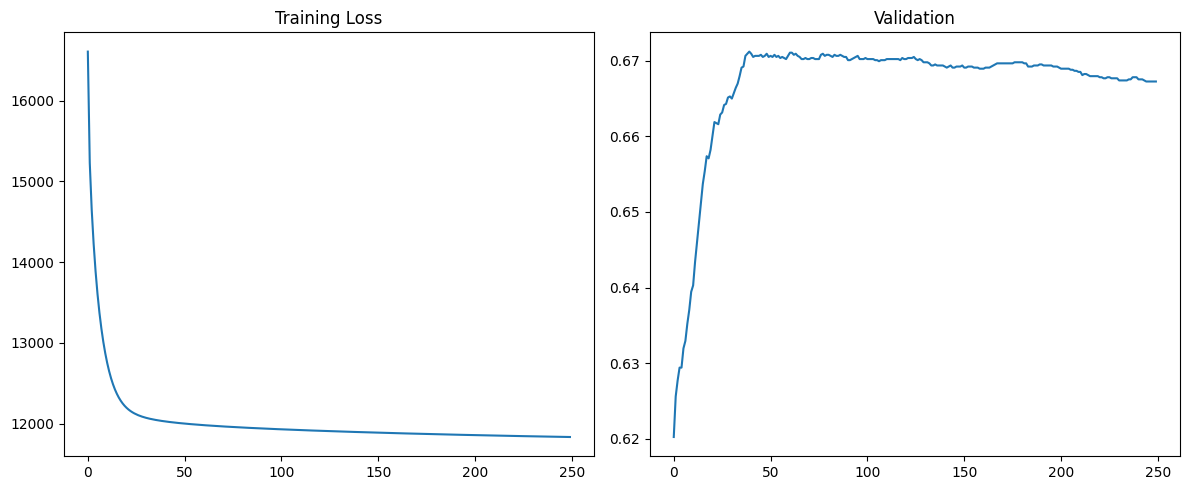

highest valid acc:  0.6711826136042901  in epoch:  39
lowest training err:  11835.343342542648  in epoch  249


In [26]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15116.321598	 Valid Acc: 0.6215071972904318
Epoch: 1 	Training Cost: 14146.044636	 Valid Acc: 0.6270110076206604
Epoch: 2 	Training Cost: 13862.182783	 Valid Acc: 0.6260231442280553
Epoch: 3 	Training Cost: 13653.821778	 Valid Acc: 0.627293254304262
Epoch: 4 	Training Cost: 13464.988360	 Valid Acc: 0.6289867344058707
Epoch: 5 	Training Cost: 13287.992509	 Valid Acc: 0.6323736946090883
Epoch: 6 	Training Cost: 13119.491126	 Valid Acc: 0.6367485182049111
Epoch: 7 	Training Cost: 12957.641763	 Valid Acc: 0.6387242449901214
Epoch: 8 	Training Cost: 12802.024638	 Valid Acc: 0.6439458086367486
Epoch: 9 	Training Cost: 12653.405272	 Valid Acc: 0.6459215354219587
Epoch: 10 	Training Cost: 12513.139159	 Valid Acc: 0.6508608523849845
Epoch: 11 	Training Cost: 12382.495272	 Valid Acc: 0.6512842224103866
Epoch: 12 	Training Cost: 12262.238060	 Valid Acc: 0.6556590460062094
Epoch: 13 	Training Cost: 12152.554833	 Valid Acc: 0.656929156082416
Epoch: 14 	Training Cost: 12053.

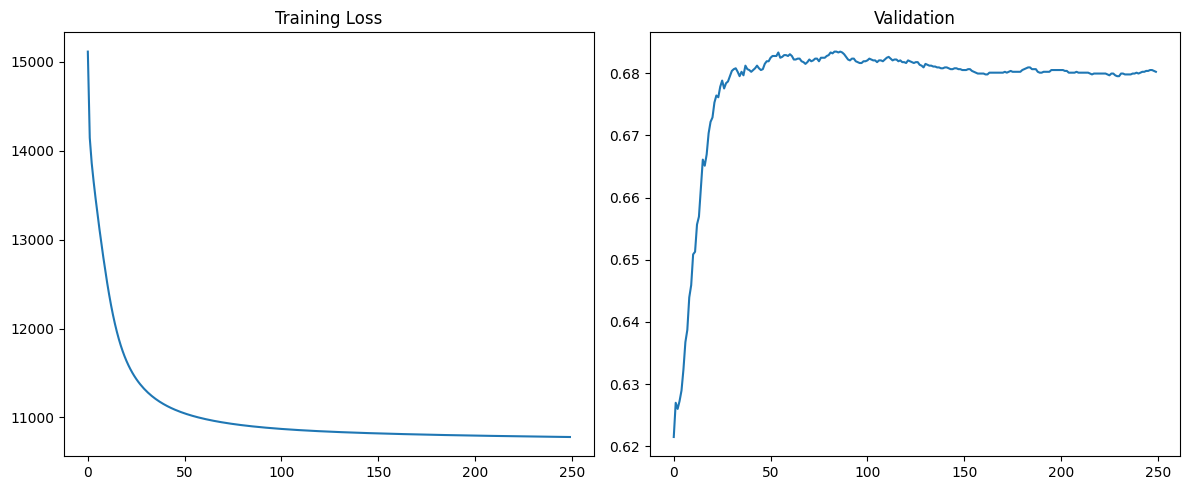

highest valid acc:  0.683460344340954  in epoch:  83
lowest training err:  10779.800882816315  in epoch  249


In [28]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.005

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 14194.343546	 Valid Acc: 0.6258820208862546
Epoch: 1 	Training Cost: 13297.575549	 Valid Acc: 0.6284222410386678
Epoch: 2 	Training Cost: 13098.021513	 Valid Acc: 0.6284222410386678
Epoch: 3 	Training Cost: 12960.615614	 Valid Acc: 0.6291278577476714
Epoch: 4 	Training Cost: 12825.501643	 Valid Acc: 0.6302568444820773
Epoch: 5 	Training Cost: 12686.851183	 Valid Acc: 0.6327970646344906
Epoch: 6 	Training Cost: 12543.238072	 Valid Acc: 0.6364662715213096
Epoch: 7 	Training Cost: 12394.852766	 Valid Acc: 0.6414055884843353
Epoch: 8 	Training Cost: 12243.495823	 Valid Acc: 0.6459215354219587
Epoch: 9 	Training Cost: 12091.714522	 Valid Acc: 0.65001411233418
Epoch: 10 	Training Cost: 11941.866276	 Valid Acc: 0.6531188258537962
Epoch: 11 	Training Cost: 11795.810287	 Valid Acc: 0.6542478125882021
Epoch: 12 	Training Cost: 11654.955355	 Valid Acc: 0.6572114027660175
Epoch: 13 	Training Cost: 11520.306153	 Valid Acc: 0.661162856336438
Epoch: 14 	Training Cost: 11392.4

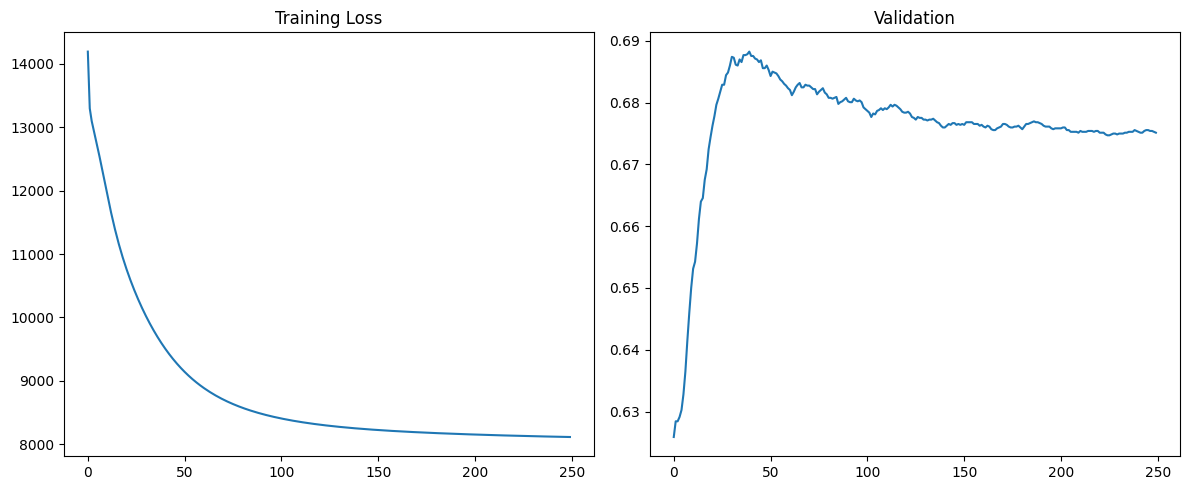

highest valid acc:  0.688258537962179  in epoch:  39
lowest training err:  8111.750334739685  in epoch  249


In [29]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 250
lamb = 0.002

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13862.732909	 Valid Acc: 0.6192492238216201
Epoch: 1 	Training Cost: 12970.021313	 Valid Acc: 0.6260231442280553
Epoch: 2 	Training Cost: 12779.361469	 Valid Acc: 0.6281399943550663
Epoch: 3 	Training Cost: 12645.754453	 Valid Acc: 0.62884561106407
Epoch: 4 	Training Cost: 12510.212179	 Valid Acc: 0.6316680779000847
Epoch: 5 	Training Cost: 12367.500940	 Valid Acc: 0.6342082980524979
Epoch: 6 	Training Cost: 12216.431896	 Valid Acc: 0.6368896415467118
Epoch: 7 	Training Cost: 12057.160141	 Valid Acc: 0.6412644651425345
Epoch: 8 	Training Cost: 11891.426353	 Valid Acc: 0.6477561388653683
Epoch: 9 	Training Cost: 11722.080170	 Valid Acc: 0.6510019757267852
Epoch: 10 	Training Cost: 11552.207619	 Valid Acc: 0.6570702794242168
Epoch: 11 	Training Cost: 11384.526466	 Valid Acc: 0.6615862263618403
Epoch: 12 	Training Cost: 11221.140330	 Valid Acc: 0.6655376799322608
Epoch: 13 	Training Cost: 11063.462878	 Valid Acc: 0.6679367767428732
Epoch: 14 	Training Cost: 10912.

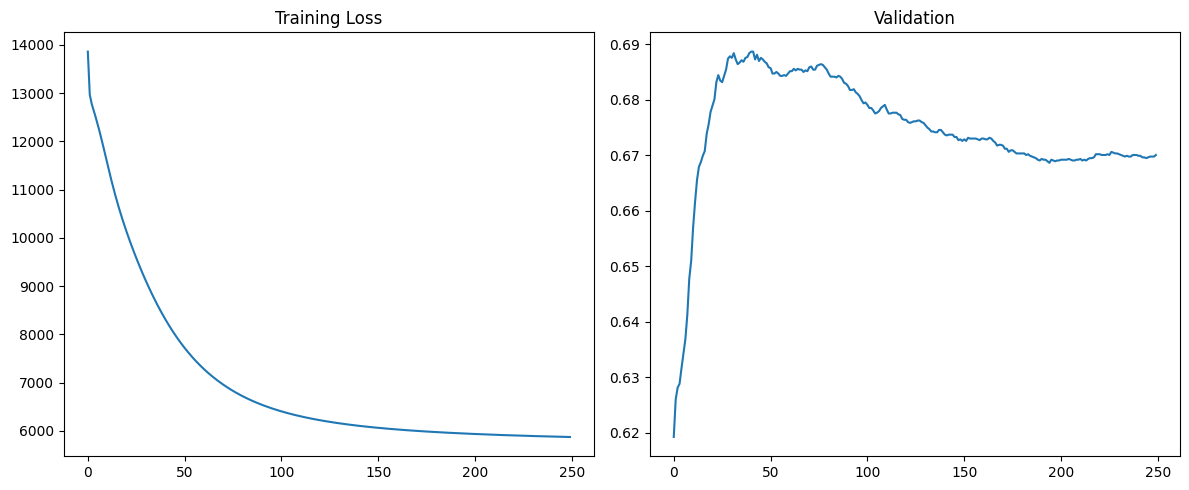

highest valid acc:  0.6886819079875811  in epoch:  40
lowest training err:  5871.635511875153  in epoch  249


In [30]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.02
num_epoch = 250
lamb = 0.001

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13401.852865	 Valid Acc: 0.6250352808354502
Epoch: 1 	Training Cost: 12756.915683	 Valid Acc: 0.6281399943550663
Epoch: 2 	Training Cost: 12606.552636	 Valid Acc: 0.6295512277730737
Epoch: 3 	Training Cost: 12449.389125	 Valid Acc: 0.6318092012418854
Epoch: 4 	Training Cost: 12271.176163	 Valid Acc: 0.6350550381033023
Epoch: 5 	Training Cost: 12071.395329	 Valid Acc: 0.6385831216483207
Epoch: 6 	Training Cost: 11853.255098	 Valid Acc: 0.6423934518769404
Epoch: 7 	Training Cost: 11622.490614	 Valid Acc: 0.6464860287891617
Epoch: 8 	Training Cost: 11385.486016	 Valid Acc: 0.6512842224103866
Epoch: 9 	Training Cost: 11147.275663	 Valid Acc: 0.6545300592718035
Epoch: 10 	Training Cost: 10910.982046	 Valid Acc: 0.6579170194750211
Epoch: 11 	Training Cost: 10678.323358	 Valid Acc: 0.6598927462602314
Epoch: 12 	Training Cost: 10450.077336	 Valid Acc: 0.6666666666666666
Epoch: 13 	Training Cost: 10226.300277	 Valid Acc: 0.6700536268698842
Epoch: 14 	Training Cost: 1000

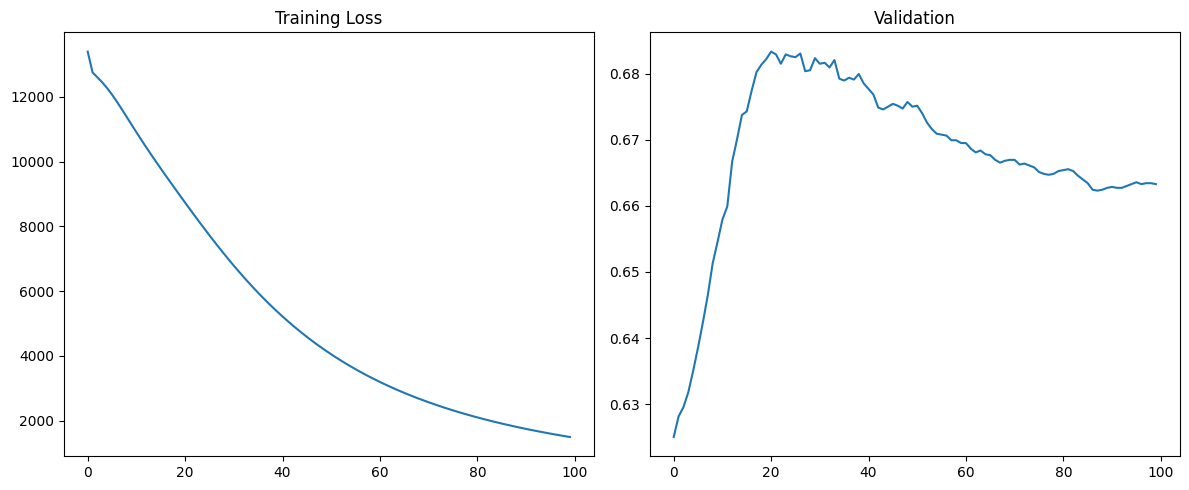

highest valid acc:  0.6833192209991532  in epoch:  20
lowest training err:  1496.9768157303333  in epoch  99


In [31]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.005

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13396.074309	 Valid Acc: 0.6250352808354502
Epoch: 1 	Training Cost: 12747.560384	 Valid Acc: 0.6254586508608524
Epoch: 2 	Training Cost: 12591.926495	 Valid Acc: 0.6274343776460627
Epoch: 3 	Training Cost: 12427.124126	 Valid Acc: 0.6299745977984759
Epoch: 4 	Training Cost: 12240.962971	 Valid Acc: 0.6353372847869038
Epoch: 5 	Training Cost: 12034.710930	 Valid Acc: 0.6401354784081287
Epoch: 6 	Training Cost: 11812.777843	 Valid Acc: 0.64422805532035
Epoch: 7 	Training Cost: 11580.961732	 Valid Acc: 0.6495907423087779
Epoch: 8 	Training Cost: 11344.711777	 Valid Acc: 0.6532599491955969
Epoch: 9 	Training Cost: 11107.943875	 Valid Acc: 0.6563646627152131
Epoch: 10 	Training Cost: 10873.109315	 Valid Acc: 0.6598927462602314
Epoch: 11 	Training Cost: 10641.704087	 Valid Acc: 0.6629974597798476
Epoch: 12 	Training Cost: 10414.502099	 Valid Acc: 0.6668077900084673
Epoch: 13 	Training Cost: 10191.642968	 Valid Acc: 0.6694891335026814
Epoch: 14 	Training Cost: 9972.7

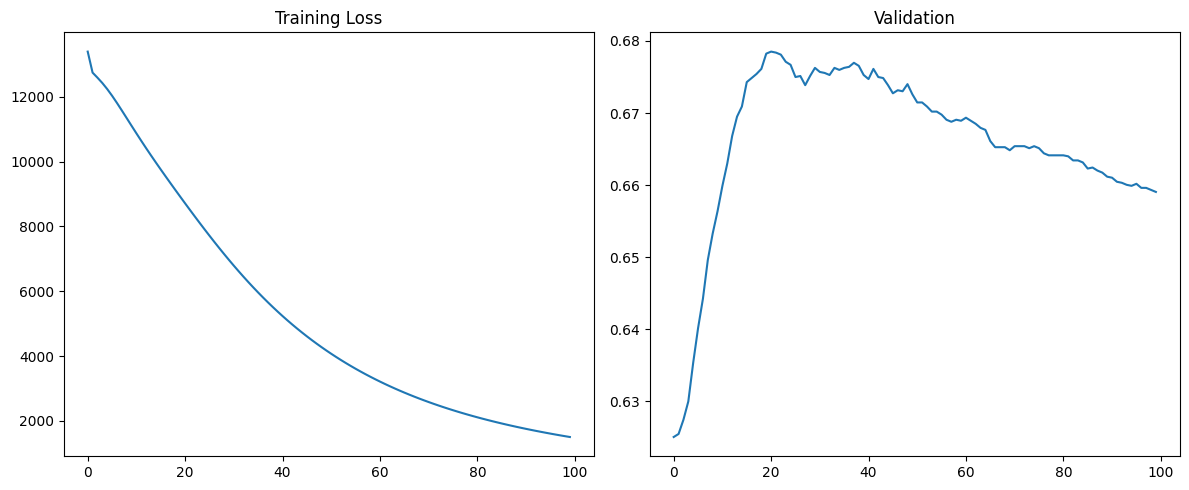

highest valid acc:  0.6785210273779283  in epoch:  20
lowest training err:  1502.9349358677864  in epoch  99


In [32]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.01

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13396.509847	 Valid Acc: 0.6254586508608524
Epoch: 1 	Training Cost: 12757.161252	 Valid Acc: 0.6274343776460627
Epoch: 2 	Training Cost: 12607.477904	 Valid Acc: 0.6275755009878634
Epoch: 3 	Training Cost: 12451.402960	 Valid Acc: 0.6287044877222693
Epoch: 4 	Training Cost: 12274.404860	 Valid Acc: 0.6322325712672876
Epoch: 5 	Training Cost: 12075.592518	 Valid Acc: 0.6370307648885125
Epoch: 6 	Training Cost: 11857.699760	 Valid Acc: 0.6418289585097375
Epoch: 7 	Training Cost: 11626.068960	 Valid Acc: 0.6462037821055603
Epoch: 8 	Training Cost: 11387.181978	 Valid Acc: 0.6511430990685859
Epoch: 9 	Training Cost: 11146.609694	 Valid Acc: 0.6539655659046006
Epoch: 10 	Training Cost: 10907.970340	 Valid Acc: 0.6581992661586227
Epoch: 11 	Training Cost: 10673.220919	 Valid Acc: 0.6631385831216483
Epoch: 12 	Training Cost: 10443.225497	 Valid Acc: 0.6649731865650579
Epoch: 13 	Training Cost: 10218.082559	 Valid Acc: 0.6686423934518769
Epoch: 14 	Training Cost: 9997

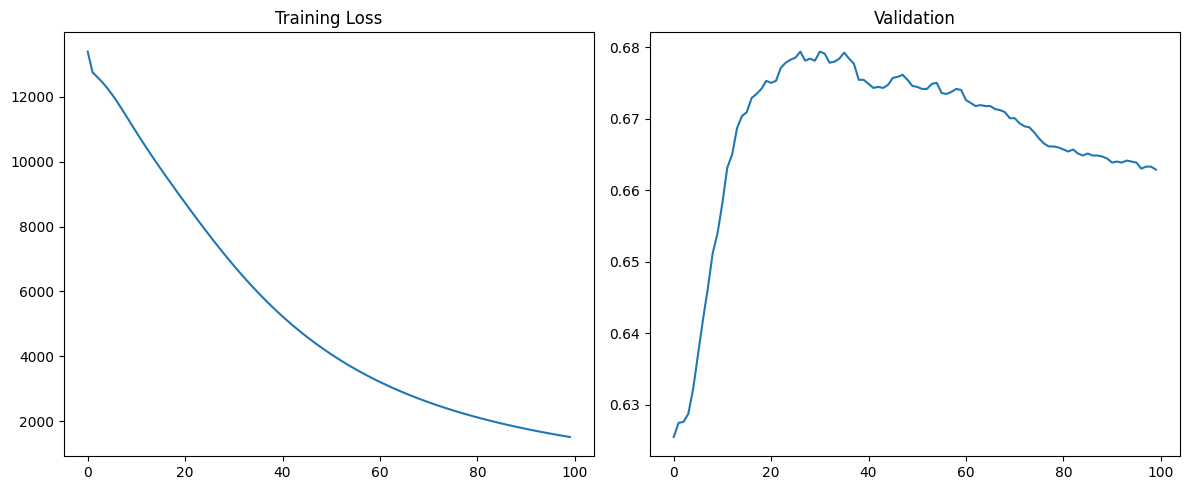

highest valid acc:  0.6793677674287327  in epoch:  26
lowest training err:  1509.2259008586407  in epoch  99


In [33]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.02

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13400.156668	 Valid Acc: 0.627293254304262
Epoch: 1 	Training Cost: 12751.969098	 Valid Acc: 0.6258820208862546
Epoch: 2 	Training Cost: 12598.774136	 Valid Acc: 0.6274343776460627
Epoch: 3 	Training Cost: 12437.867512	 Valid Acc: 0.628281117696867
Epoch: 4 	Training Cost: 12256.427487	 Valid Acc: 0.6333615580016935
Epoch: 5 	Training Cost: 12054.667795	 Valid Acc: 0.6387242449901214
Epoch: 6 	Training Cost: 11836.246805	 Valid Acc: 0.6422523285351397
Epoch: 7 	Training Cost: 11606.741979	 Valid Acc: 0.6464860287891617
Epoch: 8 	Training Cost: 11371.861189	 Valid Acc: 0.6515664690939882
Epoch: 9 	Training Cost: 11135.896269	 Valid Acc: 0.6556590460062094
Epoch: 10 	Training Cost: 10901.523089	 Valid Acc: 0.6601749929438329
Epoch: 11 	Training Cost: 10670.354808	 Valid Acc: 0.6614451030200396
Epoch: 12 	Training Cost: 10443.272815	 Valid Acc: 0.6642675698560542
Epoch: 13 	Training Cost: 10220.503454	 Valid Acc: 0.6666666666666666
Epoch: 14 	Training Cost: 10001.

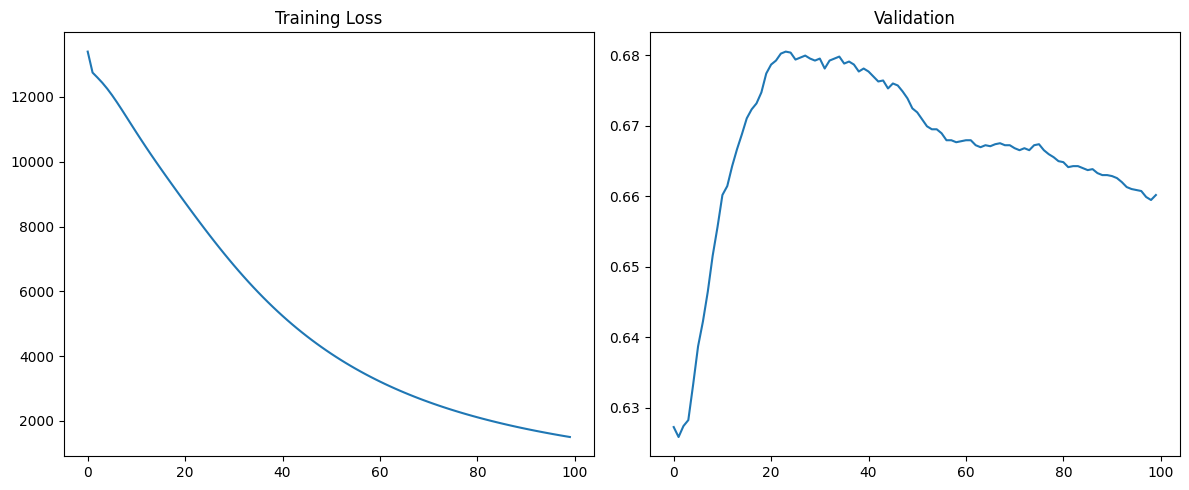

highest valid acc:  0.6804967541631386  in epoch:  23
lowest training err:  1501.5223605036736  in epoch  99


In [34]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.05

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13400.446923	 Valid Acc: 0.6248941574936494
Epoch: 1 	Training Cost: 12753.105337	 Valid Acc: 0.6285633643804686
Epoch: 2 	Training Cost: 12600.538557	 Valid Acc: 0.6301157211402766
Epoch: 3 	Training Cost: 12440.439926	 Valid Acc: 0.6316680779000847
Epoch: 4 	Training Cost: 12259.485888	 Valid Acc: 0.6340671747106972
Epoch: 5 	Training Cost: 12057.503369	 Valid Acc: 0.6361840248377082
Epoch: 6 	Training Cost: 11837.385409	 Valid Acc: 0.640558848433531
Epoch: 7 	Training Cost: 11604.478595	 Valid Acc: 0.6464860287891617
Epoch: 8 	Training Cost: 11365.225722	 Valid Acc: 0.6535421958791984
Epoch: 9 	Training Cost: 11125.022782	 Valid Acc: 0.6560824160316117
Epoch: 10 	Training Cost: 10887.265893	 Valid Acc: 0.6581992661586227
Epoch: 11 	Training Cost: 10653.705698	 Valid Acc: 0.6624329664126446
Epoch: 12 	Training Cost: 10424.994217	 Valid Acc: 0.66539655659046
Epoch: 13 	Training Cost: 10201.031571	 Valid Acc: 0.6663844199830652
Epoch: 14 	Training Cost: 9981.23

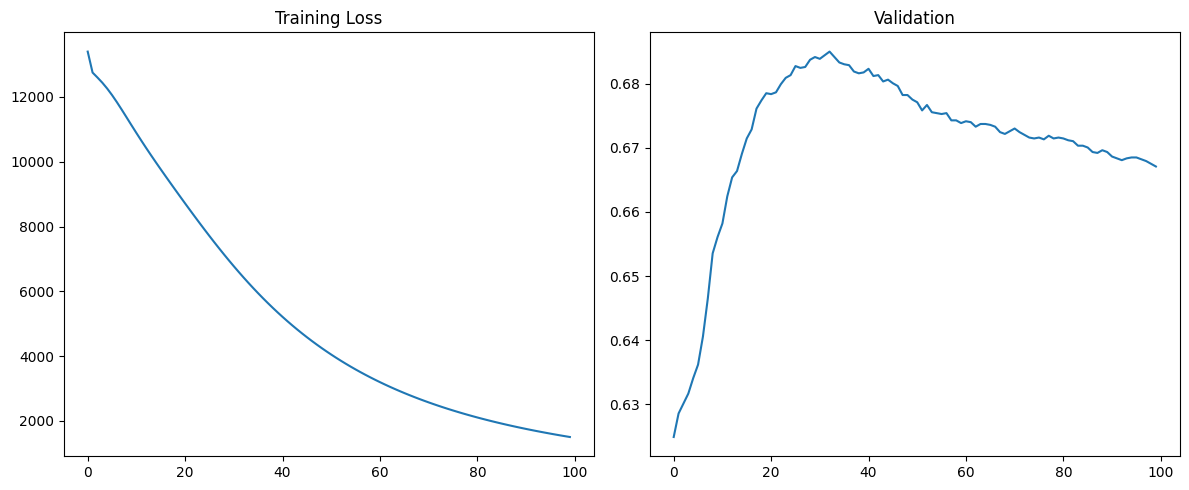

highest valid acc:  0.6850127011007621  in epoch:  32
lowest training err:  1500.7643113136292  in epoch  99


In [35]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.1

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 13388.433370	 Valid Acc: 0.6247530341518487
Epoch: 1 	Training Cost: 12747.346984	 Valid Acc: 0.6279988710132656
Epoch: 2 	Training Cost: 12593.266866	 Valid Acc: 0.6315269545582839
Epoch: 3 	Training Cost: 12431.500202	 Valid Acc: 0.6336438046852949
Epoch: 4 	Training Cost: 12249.599198	 Valid Acc: 0.6373130115721141
Epoch: 5 	Training Cost: 12047.456722	 Valid Acc: 0.6391476150155235
Epoch: 6 	Training Cost: 11828.122537	 Valid Acc: 0.6443691786621507
Epoch: 7 	Training Cost: 11597.097337	 Valid Acc: 0.650578605701383
Epoch: 8 	Training Cost: 11360.636694	 Valid Acc: 0.6536833192209992
Epoch: 9 	Training Cost: 11123.711232	 Valid Acc: 0.6536833192209992
Epoch: 10 	Training Cost: 10889.374482	 Valid Acc: 0.6581992661586227
Epoch: 11 	Training Cost: 10659.202761	 Valid Acc: 0.6622918430708439
Epoch: 12 	Training Cost: 10433.775424	 Valid Acc: 0.6658199266158623
Epoch: 13 	Training Cost: 10212.975671	 Valid Acc: 0.6687835167936776
Epoch: 14 	Training Cost: 9996.

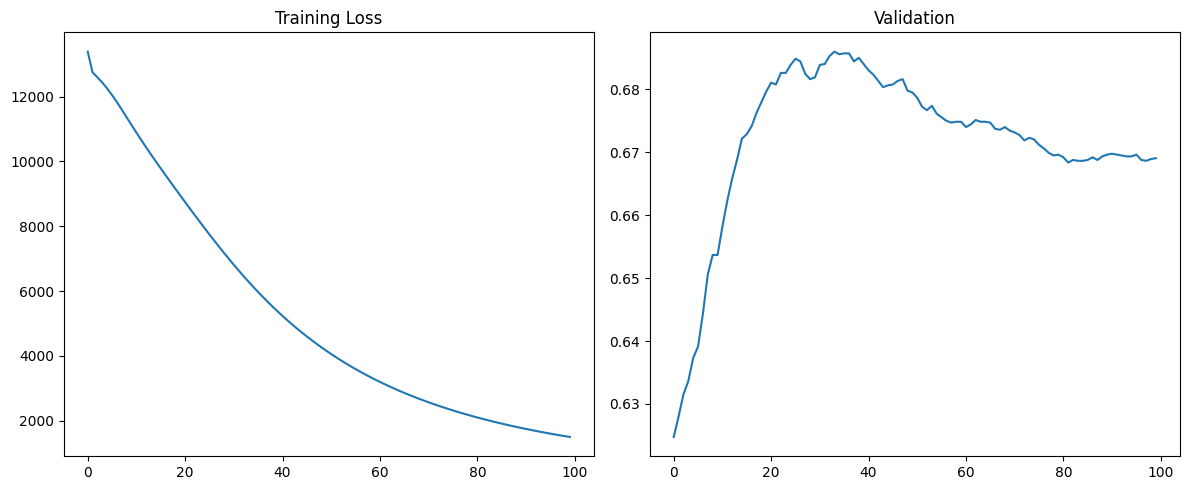

highest valid acc:  0.6860005644933672  in epoch:  33
lowest training err:  1495.6454671621323  in epoch  99


In [36]:
k = 200  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.3

train_plot(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 17540.937695	 Valid Acc: 0.6265876375952583
Epoch: 1 	Training Cost: 15411.658851	 Valid Acc: 0.6277166243296641
Epoch: 2 	Training Cost: 14421.291614	 Valid Acc: 0.6274343776460627
Epoch: 3 	Training Cost: 13811.537787	 Valid Acc: 0.6287044877222693
Epoch: 4 	Training Cost: 13426.421309	 Valid Acc: 0.6302568444820773
Epoch: 5 	Training Cost: 13177.376458	 Valid Acc: 0.6322325712672876
Epoch: 6 	Training Cost: 13011.799240	 Valid Acc: 0.6366073948631104
Epoch: 7 	Training Cost: 12898.405438	 Valid Acc: 0.6383008749647192
Epoch: 8 	Training Cost: 12818.479567	 Valid Acc: 0.6409822184589331
Epoch: 9 	Training Cost: 12760.619605	 Valid Acc: 0.6432401919277448
Epoch: 10 	Training Cost: 12717.652587	 Valid Acc: 0.6449336720293537
Epoch: 11 	Training Cost: 12684.911801	 Valid Acc: 0.647897262207169
Epoch: 12 	Training Cost: 12659.291463	 Valid Acc: 0.650578605701383
Epoch: 13 	Training Cost: 12638.697370	 Valid Acc: 0.6507197290431838
Epoch: 14 	Training Cost: 12621.

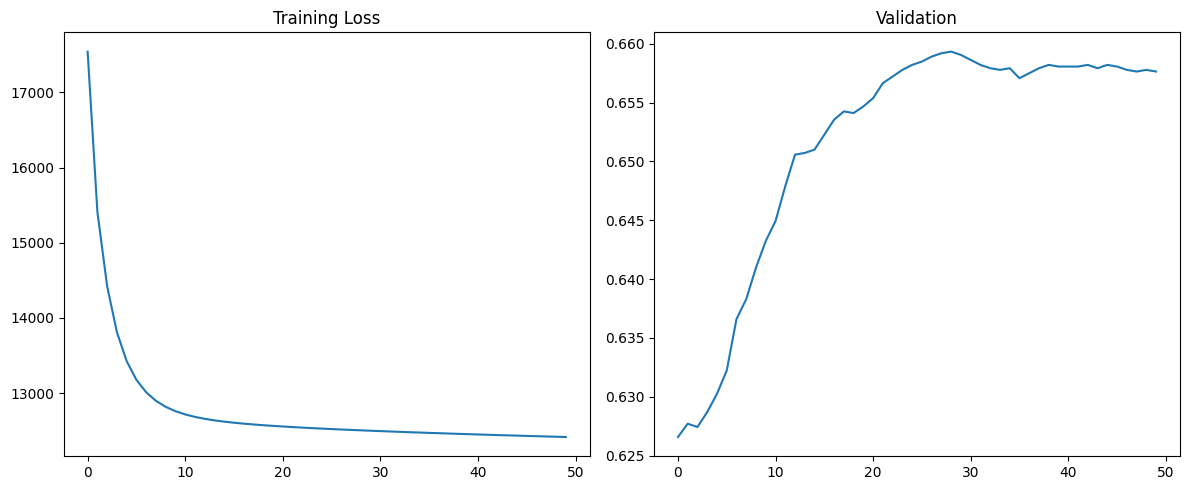

highest valid acc:  0.6593282528930285  in epoch:  28
lowest training err:  12417.422860145569  in epoch  49


In [163]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.015
num_epoch = 50
lamb = 0.015

train_plot_regu_gpu(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

In [152]:
def train(model, lr, lamb, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = np.isnan(train_data[user_id].unsqueeze(0).numpy())
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            loss = loss + lamb * model.get_weight_norm()
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))

In [166]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.005

train(model, lr, lamb, train_matrix, zero_train_matrix,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 15128.061492	 Valid Acc: 0.6236240474174428
Epoch: 1 	Training Cost: 14144.299363	 Valid Acc: 0.6274343776460627
Epoch: 2 	Training Cost: 13860.694896	 Valid Acc: 0.628281117696867
Epoch: 3 	Training Cost: 13654.137836	 Valid Acc: 0.628281117696867
Epoch: 4 	Training Cost: 13467.346450	 Valid Acc: 0.630962461191081
Epoch: 5 	Training Cost: 13292.962335	 Valid Acc: 0.6315269545582839
Epoch: 6 	Training Cost: 13127.749193	 Valid Acc: 0.635196161445103
Epoch: 7 	Training Cost: 12969.590863	 Valid Acc: 0.6371718882303133
Epoch: 8 	Training Cost: 12817.521837	 Valid Acc: 0.6398532317245272
Epoch: 9 	Training Cost: 12671.759094	 Valid Acc: 0.643663561953147
Epoch: 10 	Training Cost: 12533.349515	 Valid Acc: 0.6462037821055603
Epoch: 11 	Training Cost: 12403.560261	 Valid Acc: 0.6487440022579735
Epoch: 12 	Training Cost: 12283.362252	 Valid Acc: 0.6541066892464014
Epoch: 13 	Training Cost: 12173.216137	 Valid Acc: 0.6584815128422241
Epoch: 14 	Training Cost: 12073.098

Epoch: 0 	Training Cost: 17241.285420	 Valid Acc: 0.602314422805532
Epoch: 1 	Training Cost: 13930.296187	 Valid Acc: 0.609229466553768
Epoch: 2 	Training Cost: 13772.588560	 Valid Acc: 0.6104995766299746
Epoch: 3 	Training Cost: 13632.391994	 Valid Acc: 0.6178379904036128
Epoch: 4 	Training Cost: 13495.896148	 Valid Acc: 0.6209427039232289
Epoch: 5 	Training Cost: 13364.644136	 Valid Acc: 0.6229184307084392
Epoch: 6 	Training Cost: 13241.344435	 Valid Acc: 0.6217894439740334
Epoch: 7 	Training Cost: 13128.625390	 Valid Acc: 0.6226361840248377
Epoch: 8 	Training Cost: 13028.248282	 Valid Acc: 0.6237651707592435
Epoch: 9 	Training Cost: 12940.617492	 Valid Acc: 0.6233418007338414
Epoch: 10 	Training Cost: 12865.140675	 Valid Acc: 0.6239062941010444
Epoch: 11 	Training Cost: 12800.670258	 Valid Acc: 0.6229184307084392
Epoch: 12 	Training Cost: 12745.835196	 Valid Acc: 0.6226361840248377
Epoch: 13 	Training Cost: 12699.253299	 Valid Acc: 0.6233418007338414
Epoch: 14 	Training Cost: 12659.

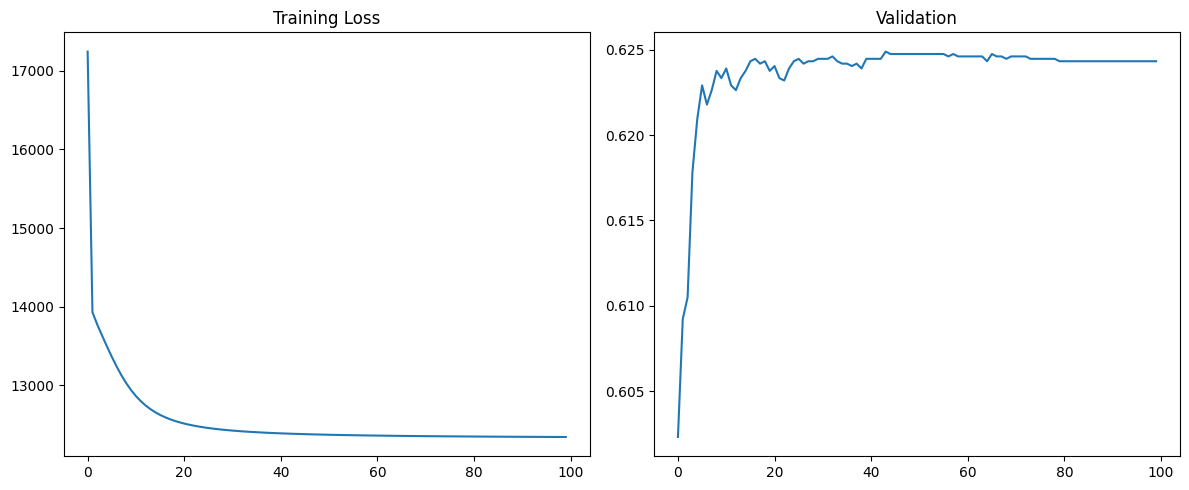

highest valid acc:  0.6248941574936494  in epoch:  43
lowest training err:  12344.990497231483  in epoch  99


In [168]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.05
num_epoch = 100
lamb = 0.05

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

Epoch: 0 	Training Cost: 16636.870191	 Valid Acc: 0.6193903471634208
Epoch: 1 	Training Cost: 15244.406752	 Valid Acc: 0.624611910810048
Epoch: 2 	Training Cost: 14661.679714	 Valid Acc: 0.6275755009878634
Epoch: 3 	Training Cost: 14237.907823	 Valid Acc: 0.6279988710132656
Epoch: 4 	Training Cost: 13897.679809	 Valid Acc: 0.6291278577476714
Epoch: 5 	Training Cost: 13619.485726	 Valid Acc: 0.6305390911656789
Epoch: 6 	Training Cost: 13389.226094	 Valid Acc: 0.632514817950889
Epoch: 7 	Training Cost: 13196.330590	 Valid Acc: 0.6336438046852949
Epoch: 8 	Training Cost: 13032.932848	 Valid Acc: 0.6349139147615016
Epoch: 9 	Training Cost: 12893.348701	 Valid Acc: 0.6380186282811177
Epoch: 10 	Training Cost: 12773.544604	 Valid Acc: 0.6412644651425345
Epoch: 11 	Training Cost: 12670.588392	 Valid Acc: 0.642675698560542
Epoch: 12 	Training Cost: 12582.182112	 Valid Acc: 0.6445103020039514
Epoch: 13 	Training Cost: 12506.373534	 Valid Acc: 0.6483206322325713
Epoch: 14 	Training Cost: 12441.4

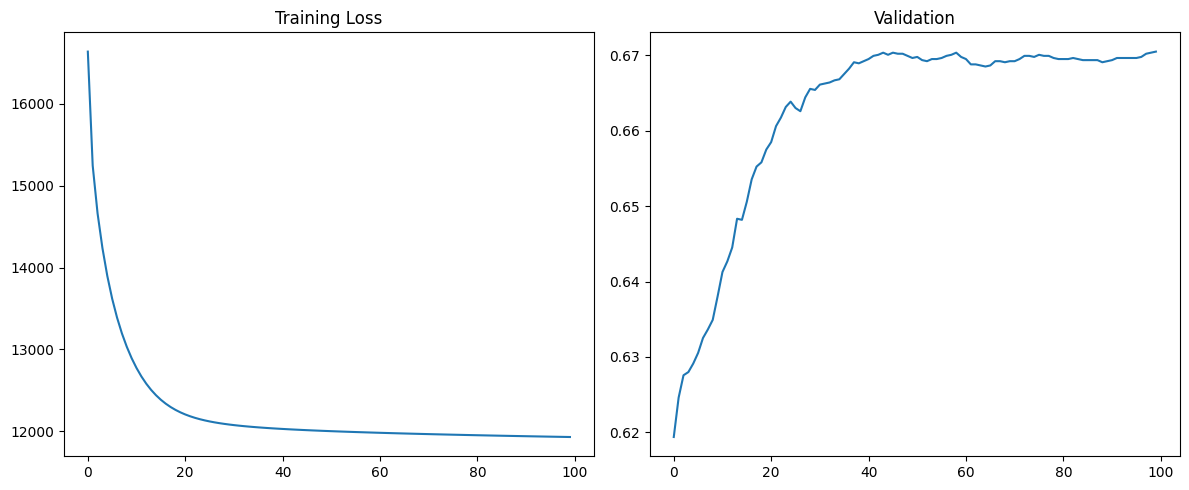

highest valid acc:  0.6704769968952865  in epoch:  99
lowest training err:  11931.40102648735  in epoch  99


In [167]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

In [ ]:
k = 100  # 10 50 100 200 500
model = AutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100
lamb = 0.01

train_plot_regu_gpu(model, lr, lamb, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

## Self made models dont run this

### Increase Layers

In [94]:
class MultiLayerAutoEncoder(nn.Module):
    def __init__(self, num_question, k=100):
        """ Initialize a class AutoEncoder.

        :param num_question: int
        :param k: int
        """
        super(MultiLayerAutoEncoder, self).__init__()

        # Define linear functions.
        self.layers = nn.ModuleList([
            nn.Linear(num_question, num_question // 10),
            nn.Linear(num_question // 10, num_question // 10),
            nn.Linear(num_question // 10, k),
            nn.Linear(k, num_question // 10),
            nn.Linear(num_question // 10, num_question // 10),
            nn.Linear(num_question // 10, num_question)
        ])

    def forward(self, inputs):
        """ Return a forward pass given inputs.

        :param inputs: user vector.
        :return: user vector.
        """
        #####################################################################
        # TODO:                                                             #
        # Implement the function as described in the docstring.             #
        # Use sigmoid activations for f and g.                              #
        #####################################################################
        # print(inputs.shape)
        out = inputs.clone()
        out = self.layers[0](out)
        out = F.relu(out)
        out = self.layers[1](out)
        out = F.relu(out)
        out = self.layers[2](out)
        out = F.relu(out)
        out = self.layers[3](out)
        out = F.relu(out)
        out = self.layers[4](out)
        out = F.relu(out)
        out = self.layers[5](out)
        out = F.sigmoid(out)
        # print(out.shape)
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return out

In [95]:
def train_plot_gpu(model, lr, train_data, zero_train_data, valid_data, num_epoch):
    """ Train the neural network, where the objective also includes
    a regularizer.

    :param model: Module
    :param lr: float
    :param lamb: float
    :param train_data: 2D FloatTensor
    :param zero_train_data: 2D FloatTensor
    :param valid_data: Dict
    :param num_epoch: int
    :return: None
    """
    # TODO: Add a regularizer to the cost function.

    # Tell PyTorch you are training the model.
    model.train()

    # Define optimizers and loss function.
    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_student = train_data.shape[0]
    train_losses = []
    valid_accs = []

    for epoch in range(0, num_epoch):
        train_loss = 0.

        for user_id in range(num_student):
            inputs = Variable(zero_train_data[user_id]).unsqueeze(0)
            target = inputs.clone()

            optimizer.zero_grad()
            output = model(inputs)

            # Mask the target to only compute the gradient of valid entries.
            nan_mask = torch.isnan(train_data[user_id].unsqueeze(0))
            target[0:1][nan_mask] = output[0:1][nan_mask]

            loss = torch.sum((output - target) ** 2.)
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        valid_acc = evaluate(model, zero_train_data, valid_data)
        print("Epoch: {} \tTraining Cost: {:.6f}\t "
              "Valid Acc: {}".format(epoch, train_loss, valid_acc))
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
    x = list(range(num_epoch))
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation")
    plt.tight_layout()
    plt.show()
    print("highest valid acc: ", np.max(valid_accs), " in epoch: ", np.argmax(valid_accs))
    print("lowest training err: ", np.min(train_losses), " in epoch ", np.argmin(train_losses))

Epoch: 0 	Training Cost: 14088.923512	 Valid Acc: 0.5800169348010161
Epoch: 1 	Training Cost: 13392.952407	 Valid Acc: 0.6168501270110076
Epoch: 2 	Training Cost: 12587.225320	 Valid Acc: 0.6239062941010444
Epoch: 3 	Training Cost: 12067.233524	 Valid Acc: 0.6302568444820773
Epoch: 4 	Training Cost: 11725.627934	 Valid Acc: 0.6326559412926898
Epoch: 5 	Training Cost: 11524.792912	 Valid Acc: 0.6439458086367486
Epoch: 6 	Training Cost: 11218.981474	 Valid Acc: 0.6670900366920689
Epoch: 7 	Training Cost: 10922.766195	 Valid Acc: 0.683460344340954
Epoch: 8 	Training Cost: 10716.456794	 Valid Acc: 0.6782387806943269
Epoch: 9 	Training Cost: 10551.914402	 Valid Acc: 0.6810612475303415
Epoch: 10 	Training Cost: 10391.162767	 Valid Acc: 0.6878351679367768
Epoch: 11 	Training Cost: 10167.617813	 Valid Acc: 0.6950324583686142
Epoch: 12 	Training Cost: 10096.371576	 Valid Acc: 0.6960203217612193
Epoch: 13 	Training Cost: 10002.333084	 Valid Acc: 0.6939034716342083
Epoch: 14 	Training Cost: 9833.

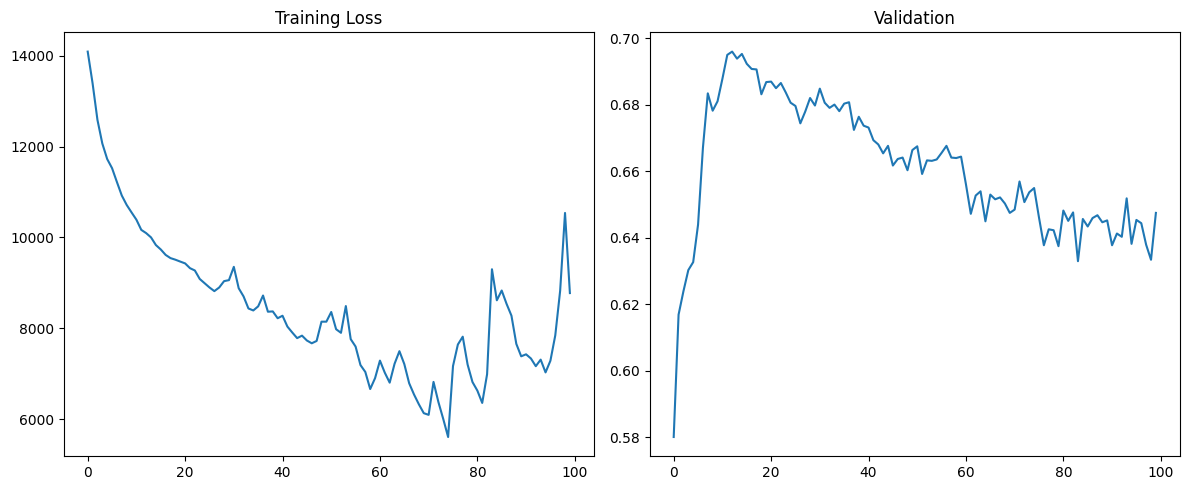

highest valid acc:  0.6960203217612193  in epoch:  12
lowest training err:  5611.5904206885025  in epoch  74


In [96]:
k = 200  # 10 50 100 200 500
model = MultiLayerAutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100

train_plot_gpu(model, lr, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)

### Use cross entropy loss

In [100]:
from torch.utils.data import TensorDataset, DataLoader

In [113]:
def train_plot_gpu_ce(model, lr, train_data, zero_train_data, valid_data, num_epoch, batch_size=64):
    """
    Train the neural network using cross-entropy loss and mini-batch gradient descent.
    
    :param model: Module - The neural network model.
    :param lr: float - Learning rate.
    :param train_data: 2D FloatTensor - Labels for the training data.
    :param zero_train_data: 2D FloatTensor - Features for the training data.
    :param valid_data: Dict - Validation data.
    :param num_epoch: int - Number of epochs to train.
    :param batch_size: int - Size of each mini-batch.
    :return: None
    """
    model.train()

    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()

    # Create DataLoader for mini-batch processing.
    dataset = TensorDataset(zero_train_data, train_data.float()) # Ensure labels are long type for CrossEntropyLoss
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    valid_accs = []

    for epoch in range(num_epoch):
        train_loss = 0.

        for inputs, target in data_loader:
            inputs, target = Variable(inputs), Variable(target)

            optimizer.zero_grad()
            output = model(inputs)

            nan_mask = torch.isnan(target)
            target[nan_mask] = output[nan_mask]

            loss = loss_function(output, target)
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

        # Assuming `evaluate` function can handle batched data directly or has been updated accordingly.
        valid_acc = evaluate(model, zero_train_data, valid_data)

        print(f"Epoch: {epoch} \tTraining Cost: {train_loss:.6f}\tValid Acc: {valid_acc}")

        train_losses.append(train_loss)
        valid_accs.append(valid_acc)

    x = range(num_epoch)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(x, train_losses)
    ax[0].set_title("Training Loss")
    ax[1].plot(x, valid_accs)
    ax[1].set_title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

    print("Highest valid acc:", np.max(valid_accs), "in epoch:", np.argmax(valid_accs))
    print("Lowest training err:", np.min(train_losses), "in epoch", np.argmin(train_losses))

Epoch: 0 	Training Cost: 32340.272736	Valid Acc: 0.39923793395427604
Epoch: 1 	Training Cost: 4185.436005	Valid Acc: 0.39923793395427604
Epoch: 2 	Training Cost: 4220.807068	Valid Acc: 0.39923793395427604
Epoch: 3 	Training Cost: 4250.614166	Valid Acc: 0.39923793395427604
Epoch: 4 	Training Cost: 4248.362000	Valid Acc: 0.39923793395427604
Epoch: 5 	Training Cost: 4194.179352	Valid Acc: 0.39923793395427604
Epoch: 6 	Training Cost: 4145.958191	Valid Acc: 0.39923793395427604
Epoch: 7 	Training Cost: 4249.686829	Valid Acc: 0.39923793395427604
Epoch: 8 	Training Cost: 4268.763336	Valid Acc: 0.39923793395427604
Epoch: 9 	Training Cost: 4188.482880	Valid Acc: 0.39923793395427604
Epoch: 10 	Training Cost: 4177.222534	Valid Acc: 0.39923793395427604
Epoch: 11 	Training Cost: 4200.008362	Valid Acc: 0.39923793395427604
Epoch: 12 	Training Cost: 4159.470642	Valid Acc: 0.39923793395427604
Epoch: 13 	Training Cost: 4200.008392	Valid Acc: 0.39923793395427604
Epoch: 14 	Training Cost: 4149.799896	Valid

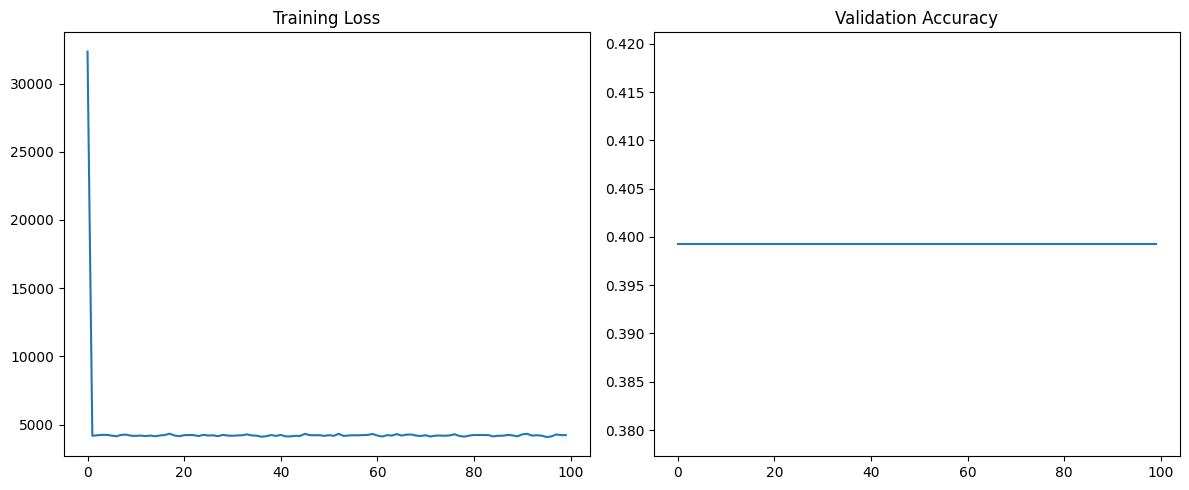

Highest valid acc: 0.39923793395427604 in epoch: 0
Lowest training err: 4093.4976348876953 in epoch 95


In [114]:
k = 200  # 10 50 100 200 500
model = MultiLayerAutoEncoder(num_question=zero_train_matrix.shape[1], k=k).to(device)

# Set optimization hyperparameters.
lr = 0.01
num_epoch = 100

train_plot_gpu_ce(model, lr, train_matrix_gpu, zero_train_matrix_gpu,
      valid_data, num_epoch)